In [130]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [181]:
qb_df = pd.read_csv('qb_fantasy.csv')
qb_df

,Full Name,Position,Team,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,A.J. McCarron,QB,-,5.24,31.7,21,-,8.2,-,1.3,...,2,-,-,0,-,0,0,1,0,-
1,Aaron Rodgers,QB,Green Bay Packers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,...,16,16,2,1,4,0,2,1,3,3
2,Alex Smith,QB,-,1.01,38.1,19.3,15.1,17.1,15.2,20,...,8,-,1,2,5,1,1,-,0,-
3,Alex Tanney,QB,-,Undrafted,34.6,-,-,8,-,-,...,-,-,-,0,-,-,-,0,-,-
4,Andrew Luck,QB,-,1.01,32.7,20,23,20.1,21.1,-,...,-,-,3,0,2,-,0,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,QB,Baltimore Ravens,Undrafted,24.3,21.6,-,-,-,-,...,2,7,-,-,-,-,-,-,0,2
171,Tyrod Taylor,QB,New York Giants,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,...,2,6,0,4,6,4,1,0,0,3
172,Will Grier,QB,Dallas Cowboys,3.36,27.2,22.4,-,-,-,-,...,-,-,-,-,-,-,-,0,-,-
173,Zach Mettenberger,QB,-,6.02,30.9,22.1,11.1,7,-,-,...,-,-,0,1,-,-,-,-,-,-


In [182]:
qb_df_w_team = qb_df.copy()

In [183]:
qb_clean = qb_df.replace({'-':np.nan,'15 gms':15,'9 gms':9,'1 gms':1,'7 gms':7,'2 gms':2,'3 gms':3,'13 gms':13,
                         '5 gms':5,'4.7 vol':4.7,'6.8 vol':6.8,'0.0 vol':0.0,'10.4 vol':10.4,'1.0 vol':1.0,
                          '12.4 vol':12.4,'1.6 vol':1.6,'8.9 vol':8.9,'3.7 vol':3.7,'5.8 vol':5.8,
                         '1.1 vol':1.1,'6.6 vol':6.6,'Undrafted':np.nan
                         }).set_index('Full Name').drop(columns=['Position'])
qb_final_df = qb_clean.drop(columns=['Team']).apply(lambda x: pd.to_numeric(x))
qb_final_df

,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
Full Name,,,,,,,,,,,,,,,,,,,,,
A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,2.0,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN
Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,16.0,16.0,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,8.0,NaN,1.0,2.0,5.0,1.0,1.0,NaN,0.0,NaN
Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,NaN,...,NaN,NaN,3.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,2.0,6.0,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [184]:
qb_final_df['fpts_2014'] = qb_final_df['Fantasy Points Per Game (2014)'] * qb_final_df['Games (2014)']
qb_final_df['fpts_2015'] = qb_final_df['Fantasy Points Per Game (2015)'] * qb_final_df['Games (2015)']
qb_final_df['fpts_2016'] = qb_final_df['Fantasy Points Per Game (2016)'] * qb_final_df['Games (2016)']
qb_final_df['fpts_2017'] = qb_final_df['Fantasy Points Per Game (2017)'] * qb_final_df['Games (2017)']
qb_final_df['fpts_2018'] = qb_final_df['Fantasy Points Per Game (2018)'] * qb_final_df['Games (2018)']
qb_final_df['fpts_2019'] = qb_final_df['Fantasy Points Per Game (2019)'] * qb_final_df['Games (2019)']
qb_final_df['fpts_2020'] = qb_final_df['Fantasy Points Per Game (2020)'] * qb_final_df['Games (2020)']
qb_final_df['fpts_2021'] = qb_final_df['Fantasy Points Per Game (2021)'] * qb_final_df['Games (2021)']
qb_final_df = qb_final_df.reset_index()

In [185]:
qb_final_df.columns

Index(['Full Name', 'Draft Pick', 'Age', 'Breakout Age',
       'Fantasy Points Per Game (2014)', 'Fantasy Points Per Game (2015)',
       'Fantasy Points Per Game (2016)', 'Fantasy Points Per Game (2017)',
       'Fantasy Points Per Game (2018)', 'Fantasy Points Per Game (2019)',
       'Fantasy Points Per Game (2020)', 'Fantasy Points Per Game (2021)',
       'Games (2014)', 'Games (2015)', 'Games (2016)', 'Games (2017)',
       'Games (2018)', 'Games (2019)', 'Games (2020)', 'Games (2021)',
       'Rushing Touchdowns (2014)', 'Rushing Touchdowns (2015)',
       'Rushing Touchdowns (2016)', 'Rushing Touchdowns (2017)',
       'Rushing Touchdowns (2018)', 'Rushing Touchdowns (2019)',
       'Rushing Touchdowns (2020)', 'Rushing Touchdowns (2021)', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021'],
      dtype='object')

In [186]:
qb_final_df['Team'] = qb_df_w_team['Team']
qb_final_df

,Full Name,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Rushing Touchdowns (2021),fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Team
0,A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,...,NaN,NaN,57.4,NaN,2.6,0.2,17.8,0.8000,NaN,-
1,Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,...,3.0,356.8,300.8,382.4,135.8,308.8,276.8,388.2592,337.3008,Green Bay Packers
2,Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,226.5,273.6,228.0,300.0,143.0,NaN,79.5800,NaN,-
3,Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,NaN,-
4,Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,...,NaN,368.0,140.7,316.5,NaN,337.6,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,86.6397,Baltimore Ravens
171,Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,...,3.0,-0.3,274.4,273.0,226.5,43.6,6.0,9.0200,86.7402,New York Giants
172,Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,Dallas Cowboys
173,Zach Mettenberger,6.02,30.9,22.1,11.1,7.0,NaN,NaN,NaN,NaN,...,NaN,77.7,49.0,NaN,NaN,NaN,NaN,NaN,NaN,-


In [228]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [229]:
qb_2017 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
    'Games (2014)', 'Games (2015)','Games (2016)', 
    'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','Draft Pick','Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)'
                      ]].dropna(subset=['Fantasy Points Per Game (2017)'])
qb_2017

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
6,Austin Davis,33.0,-,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
161,Tom Savage,32.1,-,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [230]:
qb_2017.to_csv('qb_2017.csv')

In [231]:
qb_2017_team = pd.read_csv('qb_2017_team.csv').drop(columns=['Unnamed: 0'])
qb_2017_team

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016)
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,NaN,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,16.0,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0
2,Alex Smith,38.1,Kansas City Chiefs,1,15.1,17.1,15.2,20.0,15.0,16.0,15.0,226.5,273.6,228.0,300.0,1.01,19.3,1.0,2.0,5.0
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,16.0,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0
4,Austin Davis,33.0,Seattle Seahawks,0,13.0,7.4,NaN,-0.1,9.0,3.0,NaN,117.0,22.2,NaN,-0.1,NaN,21.3,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,16.0,16.0,12.0,286.4,352.0,258.0,299.2,6.33,21.1,0.0,3.0,0.0
69,Tom Savage,32.1,Houston Texans,0,0.7,NaN,5.9,7.1,2.0,NaN,3.0,1.4,NaN,17.7,56.8,4.35,23.4,0.0,NaN,0.0
70,Trevor Siemian,30.4,Denver Broncos,1,NaN,-0.1,14.0,12.7,NaN,1.0,14.0,NaN,-0.1,196.0,139.7,NaN,21.7,NaN,0.0,0.0
71,Tyler Bray,30.4,Kansas City Chiefs,0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,18.7,NaN,NaN,NaN


In [232]:
team_2017 = pd.read_csv('brady_input_2017.csv')
team_2017

,Team,1
0,-,3.250383
1,Arizona Cardinals,1.326759
2,Atlanta Falcons,1.935694
3,Baltimore Ravens,0.602106
4,Buffalo Bills,0.968663
5,Carolina Panthers,1.155661
6,Chicago Bears,0.759393
7,Cincinnati Bengals,1.122148
8,Cleveland Browns,0.870288
9,Dallas Cowboys,1.933728


In [233]:
qb_2017_final = qb_2017_team.merge(team_2017, on='Team',how='inner')
qb_2017_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),1
0,A.J. McCarron,31.7,Cincinnati Bengals,0,NaN,8.2,NaN,1.3,NaN,7.0,...,NaN,57.4,NaN,2.6,5.24,21.0,NaN,0.0,NaN,1.122148
1,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.0,13.0,...,240.0,250.9,268.8,222.4,2.03,20.9,4.0,3.0,4.0,1.122148
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,16.0,16.0,...,356.8,300.8,382.4,135.8,1.24,19.8,2.0,1.0,4.0,1.407871
3,Brett Hundley,29.0,Green Bay Packers,0,NaN,NaN,-0.1,12.1,NaN,NaN,...,NaN,NaN,-0.4,133.1,5.11,19.2,NaN,NaN,0.0,1.407871
4,Joe Callahan,29.0,Green Bay Packers,0,NaN,NaN,NaN,0.4,NaN,NaN,...,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,1.407871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Marcus Mariota,28.6,Tennessee Titans,1,NaN,17.8,17.9,15.0,NaN,12.0,...,NaN,213.6,268.5,225.0,1.02,18.9,NaN,2.0,2.0,1.533410
69,Matt Cassel,40.1,Tennessee Titans,0,8.9,9.0,4.4,2.2,3.0,8.0,...,26.7,72.0,17.6,4.4,7.16,NaN,0.0,0.0,0.0,1.533410
70,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,16.0,16.0,...,296.0,248.0,350.4,240.0,1.03,20.3,0.0,0.0,0.0,1.935694
71,Mike Glennon,32.5,Chicago Bears,0,15.9,12.8,7.0,9.7,6.0,13.0,...,95.4,166.4,7.0,38.8,3.11,21.7,0.0,0.0,0.0,0.759393


In [234]:
qb_2017_final['y'] = np.where(qb_2017_final['fpts_2017'] > 300,1,0)
qb_2017_final['y'].value_counts()

0    71
1     2
Name: y, dtype: int64

In [235]:
fpts_df_2017 = qb_2017_final[['fpts_2014','fpts_2015', 'fpts_2016']]

In [236]:
konami_df_2017 = qb_2017_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)']]

In [237]:
fppg_df_2017 = qb_2017_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [238]:
games_df_2017 = qb_2017_final[['Games (2014)','Games (2015)','Games (2016)']]

In [239]:
konami_df_2017_final = pd.DataFrame({
    '2014':konami_df_2017['Rushing Touchdowns (2014)'] / games_df_2017['Games (2014)'],
    '2015':konami_df_2017['Rushing Touchdowns (2015)'] / games_df_2017['Games (2015)'],
    '2016':konami_df_2017['Rushing Touchdowns (2016)'] / games_df_2017['Games (2016)'],
                                    })
konami_df_2017_final

,2014,2015,2016
0,NaN,0.000000,NaN
1,0.250,0.230769,0.250000
2,0.125,0.062500,0.250000
3,NaN,NaN,0.000000
4,NaN,NaN,NaN
...,...,...,...
68,NaN,0.166667,0.133333
69,0.000,0.000000,0.000000
70,0.000,0.000000,0.000000
71,0.000,0.000000,0.000000


In [240]:
df_2017 = qb_2017_final[['y','starter']]
df_2017

,y,starter
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
...,...,...
68,0,1
69,0,0
70,0,1
71,0,0


In [241]:
df_2017['age'] = qb_2017_final['Age'] - 5
df_2017

,y,starter,age
0,0,0,26.7
1,0,1,29.6
2,0,1,33.5
3,0,0,24.0
4,0,0,24.0
...,...,...,...
68,0,1,23.6
69,0,0,35.1
70,0,1,32.1
71,0,0,27.5


In [242]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

,y,starter,age,max_pts
0,0,0,26.7,57.4
1,0,1,29.6,268.8
2,0,1,33.5,382.4
3,0,0,24.0,-0.4
4,0,0,24.0,NaN
...,...,...,...,...
68,0,1,23.6,268.5
69,0,0,35.1,72.0
70,0,1,32.1,350.4
71,0,0,27.5,166.4


In [243]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts
0,0,0,26.7,57.4,57.400000
1,0,1,29.6,268.8,253.233333
2,0,1,33.5,382.4,346.666667
3,0,0,24.0,-0.4,-0.400000
4,0,0,24.0,NaN,NaN
...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000
69,0,0,35.1,72.0,38.766667
70,0,1,32.1,350.4,298.133333
71,0,0,27.5,166.4,89.600000


In [244]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts
0,0,0,26.7,57.4,57.400000,NaN
1,0,1,29.6,268.8,253.233333,268.8
2,0,1,33.5,382.4,346.666667,382.4
3,0,0,24.0,-0.4,-0.400000,-0.4
4,0,0,24.0,NaN,NaN,NaN
...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5
69,0,0,35.1,72.0,38.766667,17.6
70,0,1,32.1,350.4,298.133333,350.4
71,0,0,27.5,166.4,89.600000,7.0


In [245]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg
0,0,0,26.7,57.4,57.400000,NaN,8.200000
1,0,1,29.6,268.8,253.233333,268.8,17.033333
2,0,1,33.5,382.4,346.666667,382.4,21.666667
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000
4,0,0,24.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000
69,0,0,35.1,72.0,38.766667,17.6,7.433333
70,0,1,32.1,350.4,298.133333,350.4,18.633333
71,0,0,27.5,166.4,89.600000,7.0,11.900000


In [246]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 300].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000


In [247]:
df_2017['Draft Pick'] = qb_2017_final['Draft Pick']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11


In [248]:
df_2017['supporting_cast'] = qb_2017_final['1']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871
...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393


In [249]:
df_2017['breakout_age'] = qb_2017_final['Breakout Age']
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN
...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7


In [250]:
df_2017['konami'] = konami_df_2017_final.mean(axis=1)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,0.150000
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000


In [251]:
df_2017['games_played_rate'] = games_df_2017.sum(axis=1) / (games_df_2017.count(axis=1)*16)
df_2017

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,0.150000,0.843750
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667


In [252]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = qb_2017_final['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,0.150000,0.843750,Marcus Mariota,2017
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500,Matt Cassel,2017
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000,Matt Ryan,2017
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667,Mike Glennon,2017


In [253]:
final_data = final_data.append(df_2017)
final_data

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,0.150000,0.843750
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667


In [254]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,1,23.6,268.5,241.050000,268.5,17.850000,0.000000,1.02,1.533410,18.9,0.150000,0.843750,Marcus Mariota,2017
69,0,0,35.1,72.0,38.766667,17.6,7.433333,0.000000,7.16,1.533410,NaN,0.000000,0.312500,Matt Cassel,2017
70,0,1,32.1,350.4,298.133333,350.4,18.633333,0.333333,1.03,1.935694,20.3,0.000000,1.000000,Matt Ryan,2017
71,0,0,27.5,166.4,89.600000,7.0,11.900000,0.000000,3.11,0.759393,21.7,0.000000,0.416667,Mike Glennon,2017


### 2018

In [255]:
qb_2018 = qb_final_df[['Full Name','Age', 'Team','Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick',
                      'Breakout Age','Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)'
                      ]].dropna(subset=['Fantasy Points Per Game (2018)'])
qb_2018

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,NaN,7.0,...,57.4,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,16.0,16.0,...,300.8,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,15.0,16.0,...,273.6,228.0,300.0,143.0,1.01,19.3,1.0,2.0,5.0,1.0
4,Andrew Luck,32.7,-,23.0,20.1,21.1,NaN,21.1,16.0,7.0,...,140.7,316.5,NaN,337.6,1.01,20.0,3.0,0.0,2.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.0,13.0,...,250.9,268.8,222.4,185.9,2.03,20.9,4.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Sean Mannion,30.1,Minnesota Vikings,NaN,1.2,-0.3,1.0,0.0,NaN,1.0,...,1.2,-0.3,5.0,0.0,3.25,20.4,NaN,0.0,0.0,0.0
156,Taylor Heinicke,29.2,Washington Commanders,NaN,NaN,NaN,0.6,3.4,NaN,NaN,...,NaN,NaN,0.6,17.0,NaN,19.5,NaN,NaN,NaN,0.0
157,Teddy Bridgewater,29.6,Miami Dolphins,14.4,13.0,NaN,-1.3,2.1,13.0,16.0,...,208.0,NaN,-1.3,8.4,1.32,18.8,1.0,3.0,NaN,0.0
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.0,16.0,...,352.0,258.0,299.2,291.2,6.33,21.1,0.0,3.0,0.0,0.0


In [256]:
qb_2018.to_csv('qb_2018.csv')

In [257]:
qb_2018_team = pd.read_csv('qb_2018_team.csv').drop(columns=['Unnamed: 0'])

team_2018 = pd.read_csv('brady_input_2018.csv')

qb_2018_final = qb_2018_team.merge(team_2018, on='Team',how='inner')
qb_2018_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),...,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),1
0,A.J. McCarron,31.7,Buffalo Bills,0,NaN,8.2,NaN,1.3,0.1,NaN,...,NaN,2.6,0.2,5.24,21.0,NaN,0.0,NaN,0.0,0.641736
1,Derek Anderson,39.0,Buffalo Bills,0,10.1,0.4,3.9,0.2,5.2,5.0,...,19.5,0.6,10.4,6.39,19.2,0.0,0.0,0.0,0.0,0.641736
2,Josh Allen,26.0,Buffalo Bills,1,NaN,NaN,NaN,NaN,18.2,NaN,...,NaN,NaN,218.4,1.07,20.3,NaN,NaN,NaN,NaN,0.641736
3,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,16.0,...,382.4,135.8,308.8,1.24,19.8,2.0,1.0,4.0,0.0,1.087887
4,DeShone Kizer,26.4,Green Bay Packers,0,NaN,NaN,NaN,13.2,2.5,NaN,...,NaN,198.0,7.5,2.20,19.7,NaN,NaN,NaN,5.0,1.087887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Matt Cassel,40.1,Detroit Lions,0,8.9,9.0,4.4,2.2,1.3,3.0,...,17.6,4.4,2.6,7.16,NaN,0.0,0.0,0.0,0.0,1.035481
68,Matthew Stafford,34.3,Detroit Lions,1,16.3,18.9,18.0,17.5,13.9,16.0,...,288.0,280.0,222.4,1.01,19.6,2.0,1.0,2.0,0.0,1.035481
69,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,22.3,16.0,...,350.4,240.0,356.8,1.03,20.3,0.0,0.0,0.0,0.0,1.432762
70,Matt Schaub,41.0,Atlanta Falcons,0,-0.9,15.3,0.1,NaN,0.0,2.0,...,0.3,NaN,0.0,3.27,21.2,0.0,0.0,0.0,NaN,1.432762


In [258]:
qb_2018_final['y'] = np.where(qb_2018_final['fpts_2018'] > 300,1,0)
qb_2018_final['y'].value_counts()

0    63
1     9
Name: y, dtype: int64

In [259]:
fpts_df_2018 = qb_2018_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

konami_df_2018 = qb_2018_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)']]

fppg_df_2018 = qb_2018_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

games_df_2018 = qb_2018_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

konami_df_2018_final = pd.DataFrame({
    '2015':konami_df_2018['Rushing Touchdowns (2015)'] / games_df_2018['Games (2015)'],
    '2016':konami_df_2018['Rushing Touchdowns (2016)'] / games_df_2018['Games (2016)'],
    '2017':konami_df_2018['Rushing Touchdowns (2017)'] / games_df_2018['Games (2017)'],
                                    })

df_2018 = qb_2018_final[['y','starter']]

df_2018['age'] = qb_2018_final['Age'] - 4

df_2018['max_pts'] = fpts_df_2018.max(axis=1)

df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)

df_2018['last_pts'] = fpts_df_2018['fpts_2017']

df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']].mean(axis=1)

df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 300].count(axis = 1) / fpts_df_2018.count(axis=1)

df_2018['Draft Pick'] = qb_2018_final['Draft Pick']

df_2018['supporting_cast'] = qb_2018_final['1']

df_2018['breakout_age'] = qb_2018_final['Breakout Age']

df_2018['konami'] = konami_df_2018_final.mean(axis=1)

df_2018['games_played_rate'] = games_df_2018.sum(axis=1)/(games_df_2018.count(axis=1)*16)

df_2018_id = df_2018.copy()
df_2018_id['id'] = qb_2018_final['Full Name']
df_2018_id['year'] = 2018

final_data = final_data.append(df_2018)

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.00,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.00,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.00,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.00,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0,0,36.1,72.0,30.175000,4.4,5.200000,0.00,7.16,1.035481,NaN,0.000000,0.265625,Matt Cassel,2018
68,0,1,30.3,302.4,282.800000,280.0,18.133333,0.25,1.01,1.035481,19.6,0.062500,1.000000,Matthew Stafford,2018
69,1,1,33.1,350.4,283.600000,240.0,17.466667,0.25,1.03,1.432762,20.3,0.000000,1.000000,Matt Ryan,2018
70,0,0,37.0,30.6,9.700000,NaN,7.700000,0.00,3.27,1.432762,21.2,0.000000,0.145833,Matt Schaub,2018


### 2019

In [260]:
qb_2019 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2019)'])
qb_2019

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,NaN,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,16.0,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
3,Alex Tanney,34.6,-,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,16.0,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,NaN,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.9,16.0,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,NaN,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,0.1,NaN,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,1.0,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [261]:
qb_2019.to_csv('qb_2019.csv')

In [262]:
qb_2019_team = pd.read_csv('qb_2019_team.csv').drop(columns=['Unnamed: 0'])

team_2019 = pd.read_csv('brady_input_2019.csv')

qb_2019_final = qb_2019_team.merge(team_2019, on='Team',how='inner')
qb_2019_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),1
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.128671
1,Deshaun Watson,26.7,Houston Texans,1,NaN,NaN,NaN,24.7,21.3,22.0,...,340.8,330.0,1.12,20.0,NaN,NaN,NaN,2.0,5.0,1.128671
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.073120
3,Tim Boyle,27.7,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.073120
4,Alex Tanney,34.6,New York Giants,0,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.011398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Matt Ryan,37.1,Atlanta Falcons,1,18.5,15.5,21.9,15.0,22.3,18.6,...,356.8,279.0,1.03,20.3,0.0,0.0,0.0,0.0,3.0,1.238662
66,Matt Schaub,41.0,Atlanta Falcons,0,-0.9,15.3,0.1,NaN,0.0,6.4,...,0.0,32.0,3.27,21.2,0.0,0.0,0.0,NaN,0.0,1.238662
67,Philip Rivers,40.5,Los Angeles Chargers,1,17.7,18.3,17.5,17.5,17.9,15.8,...,286.4,252.8,1.04,18.7,0.0,0.0,0.0,0.0,0.0,1.633534
68,Tyrod Taylor,32.8,Los Angeles Chargers,0,-0.3,19.6,18.2,15.1,10.9,1.5,...,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0,1.633534


In [263]:
qb_2019_final['y'] = np.where(qb_2019_final['fpts_2019'] > 300,1,0)
qb_2019_final['y'].value_counts()

0    65
1     5
Name: y, dtype: int64

In [264]:
fpts_df_2019 = qb_2019_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

konami_df_2019 = qb_2019_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)']]

fppg_df_2019 = qb_2019_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)']]

games_df_2019 = qb_2019_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

konami_df_2019_final = pd.DataFrame({
    '2016':konami_df_2019['Rushing Touchdowns (2016)'] / games_df_2019['Games (2016)'],
    '2017':konami_df_2019['Rushing Touchdowns (2017)'] / games_df_2019['Games (2017)'],
    '2018':konami_df_2019['Rushing Touchdowns (2018)'] / games_df_2019['Games (2018)'],
                                    })

df_2019 = qb_2019_final[['y','starter']]

df_2019['age'] = qb_2019_final['Age'] - 3

df_2019['max_pts'] = fpts_df_2019.max(axis=1)

df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)

df_2019['last_pts'] = fpts_df_2019['fpts_2018']

df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019[['Fantasy Points Per Game (2016)', 
                         'Fantasy Points Per Game (2017)','Fantasy Points Per Game (2018)']].mean(axis=1)

df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 300].count(axis = 1) / fpts_df_2019.count(axis=1)

df_2019['Draft Pick'] = qb_2019_final['Draft Pick']

df_2019['supporting_cast'] = qb_2019_final['1']

df_2019['breakout_age'] = qb_2019_final['Breakout Age']

df_2019['konami'] = konami_df_2019_final.mean(axis=1)

df_2019['games_played_rate'] = games_df_2019.sum(axis=1)/(games_df_2019.count(axis=1)*16)

df_2019_id = df_2019.copy()
df_2019_id['id'] = qb_2019_final['Full Name']
df_2019_id['year'] = 2019

final_data = final_data.append(df_2019)

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.0,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.0,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.0,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.0,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,1,34.1,356.8,298.240000,356.8,19.733333,0.4,1.03,1.238662,20.3,0.062500,1.000000,Matt Ryan,2019
66,0,0,38.0,30.6,7.275000,0.0,0.050000,0.0,3.27,1.238662,21.2,0.000000,0.140625,Matt Schaub,2019
67,0,1,37.5,292.8,284.480000,286.4,17.633333,0.0,1.04,1.633534,18.7,0.000000,1.000000,Philip Rivers,2019
68,0,0,29.8,274.4,163.440000,43.6,14.733333,0.0,6.15,1.633534,20.1,0.305556,0.612500,Tyrod Taylor,2019


### 2020

In [265]:
qb_2020 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)'
                    ]].dropna(subset=['Fantasy Points Per Game (2020)'])
qb_2020

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,4.6500,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,0.7200,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
qb_2020.to_csv('qb_2020.csv')

In [267]:
qb_2020_team = pd.read_csv('qb_2020_team.csv').drop(columns=['Unnamed: 0'])

team_2020 = pd.read_csv('brady_input_2020.csv')

qb_2020_final = qb_2020_team.merge(team_2020, on='Team',how='inner')
qb_2020_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),1
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0,1.037354
1,Deshaun Watson,26.7,Houston Texans,1,NaN,NaN,NaN,24.7,21.3,22.0,...,376.3200,1.12,20.0,NaN,NaN,NaN,2.0,5.0,7.0,1.037354
2,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,1.473486
3,Tim Boyle,27.7,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,0.0,...,-0.9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.473486
4,Alex Smith,38.1,Washington Commanders,0,15.1,17.1,15.2,20.0,14.3,NaN,...,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN,0.865133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Tyler Bray,30.4,Chicago Bears,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN,1.447192
78,P.J. Walker,27.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,13.5200,NaN,18.5,NaN,NaN,NaN,NaN,NaN,NaN,1.616799
79,Teddy Bridgewater,29.6,Carolina Panthers,1,14.4,13.0,NaN,-1.3,2.1,10.3,...,252.2205,1.32,18.8,1.0,3.0,NaN,0.0,0.0,0.0,1.616799
80,Ryan Fitzpatrick,39.5,Miami Dolphins,1,15.6,18.8,11.0,12.8,22.0,16.8,...,161.7399,7.36,20.8,2.0,2.0,0.0,0.0,2.0,4.0,0.364208


In [268]:
qb_2020_final['y'] = np.where(qb_2020_final['fpts_2020'] > 300,1,0)
qb_2020_final['y'].value_counts()

0    71
1    11
Name: y, dtype: int64

In [269]:
fpts_df_2020 = qb_2020_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

konami_df_2020 = qb_2020_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)']]

fppg_df_2020 = qb_2020_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

games_df_2020 = qb_2020_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)']]

konami_df_2020_final = pd.DataFrame({
    '2017':konami_df_2020['Rushing Touchdowns (2017)'] / games_df_2020['Games (2017)'],
    '2018':konami_df_2020['Rushing Touchdowns (2018)'] / games_df_2020['Games (2018)'],
    '2019':konami_df_2020['Rushing Touchdowns (2019)'] / games_df_2020['Games (2019)'],
                                    })

df_2020 = qb_2020_final[['y','starter']]

df_2020['age'] = qb_2020_final['Age'] - 2

df_2020['max_pts'] = fpts_df_2020.max(axis=1)

df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)

df_2020['last_pts'] = fpts_df_2020['fpts_2019']

df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020[['Fantasy Points Per Game (2017)', 
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']].mean(axis=1)

df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 300].count(axis = 1) / fpts_df_2020.count(axis=1)

df_2020['Draft Pick'] = qb_2020_final['Draft Pick']

df_2020['supporting_cast'] = qb_2020_final['1']

df_2020['breakout_age'] = qb_2020_final['Breakout Age']

df_2020['konami'] = konami_df_2020_final.mean(axis=1)

df_2020['games_played_rate'] = games_df_2020.sum(axis=1)/(games_df_2020.count(axis=1)*16)

df_2020_id = df_2020.copy()
df_2020_id['id'] = qb_2020_final['Full Name']
df_2020_id['year'] = 2020

final_data = final_data.append(df_2020)

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.4,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.8,253.233333,268.8,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.4,346.666667,382.4,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.4,-0.400000,-0.4,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray,2020
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker,2020
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.000000,0.537500,Teddy Bridgewater,2020
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,0.172222,0.739583,Ryan Fitzpatrick,2020


### 2021

In [270]:
qb_2021 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)',
                       'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019',
                       'fpts_2020','fpts_2021','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)'                      
                    ]].dropna(subset=['Fantasy Points Per Game (2021)'])
qb_2021

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
9,Ben Roethlisberger,40.3,-,19.1,19.0,18.5,18.0,21.8,6.9,18.4813,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Trey Lance,22.1,San Francisco 49ers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [271]:
qb_2021.to_csv('qb_2021.csv')

In [272]:
qb_2021_team = pd.read_csv('qb_2021_team.csv').drop(columns=['Unnamed: 0'])

team_2021 = pd.read_csv('brady_input_2021.csv')

qb_2021_final = qb_2021_team.merge(team_2021, on='Team',how='inner')
qb_2021_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),1
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,1.662298
1,Jordan Love,23.6,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.26,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662298
2,Kurt Benkert,26.9,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662298
3,Andy Dalton,34.6,Chicago Bears,1,15.0,19.3,16.8,13.9,16.9,16.4,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,1.754124
4,Justin Fields,23.2,Chicago Bears,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.11,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.754124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Ryan Tannehill,33.9,Tennessee Titans,1,18.2,16.7,15.4,NaN,13.5,19.0,...,1.08,22.1,1.0,1.0,1.0,NaN,0.0,4.0,7.0,1.524542
81,Lamar Jackson,25.4,Baltimore Ravens,1,NaN,NaN,NaN,NaN,10.0,28.2,...,1.32,18.7,NaN,NaN,NaN,NaN,5.0,7.0,7.0,1.224198
82,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.224198
83,Mike White,27.2,New York Jets,0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.34,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.989744


In [273]:
qb_2021_final['y'] = np.where(qb_2021_final['fpts_2021'] > 300,1,0)
qb_2021_final['y'].value_counts()

0    74
1    11
Name: y, dtype: int64

In [275]:
fpts_df_2021 = qb_2021_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

konami_df_2021 = qb_2021_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)']]

fppg_df_2021 = qb_2021_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)']]

games_df_2021 = qb_2021_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)']]

konami_df_2021_final = pd.DataFrame({
    '2018':konami_df_2021['Rushing Touchdowns (2018)'] / games_df_2021['Games (2018)'],
    '2019':konami_df_2021['Rushing Touchdowns (2019)'] / games_df_2021['Games (2019)'],
    '2020':konami_df_2021['Rushing Touchdowns (2020)'] / games_df_2021['Games (2020)'],
                                    })

df_2021 = qb_2021_final[['y','starter']]

df_2021['age'] = qb_2021_final['Age'] - 1

df_2021['max_pts'] = fpts_df_2021.max(axis=1)

df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)

df_2021['last_pts'] = fpts_df_2021['fpts_2020']

df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021[['Fantasy Points Per Game (2018)', 
                     'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 300].count(axis = 1) / fpts_df_2021.count(axis=1)

df_2021['Draft Pick'] = qb_2021_final['Draft Pick']

df_2021['supporting_cast'] = qb_2021_final['1']

df_2021['breakout_age'] = qb_2021_final['Breakout Age']

df_2021['konami'] = konami_df_2021_final.mean(axis=1)

df_2021['games_played_rate'] = games_df_2021.sum(axis=1)/(games_df_2021.count(axis=1)*16)

df_2021_id = df_2021.copy()
df_2021_id['id'] = qb_2021_final['Full Name']
df_2021_id['year'] = 2021

final_data = final_data.append(df_2021)

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,26.7,57.40,57.400000,NaN,8.200000,0.000000,5.24,1.122148,21.0,0.000000,0.437500,A.J. McCarron,2017
1,0,1,29.6,268.80,253.233333,268.8000,17.033333,0.000000,2.03,1.122148,20.9,0.243590,0.937500,Andy Dalton,2017
2,0,1,33.5,382.40,346.666667,382.4000,21.666667,1.000000,1.24,1.407871,19.8,0.145833,1.000000,Aaron Rodgers,2017
3,0,0,24.0,-0.40,-0.400000,-0.4000,-0.100000,0.000000,5.11,1.407871,19.2,0.000000,0.250000,Brett Hundley,2017
4,0,0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,1.407871,NaN,NaN,NaN,Joe Callahan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.36,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,0.256944,0.875000,Ryan Tannehill,2021
81,0,1,24.4,423.00,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,0.415278,0.958333,Lamar Jackson,2021
82,0,0,23.3,2.90,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley,2021
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White,2021


In [276]:
final_data.to_csv('qb_final_data2.csv')
final_data_id.to_csv('qb_final_data_id2.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [277]:
qb_2022 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)','Games (2021)',
                       'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)',
                       'Rushing Touchdowns (2021)'
                    ]].replace('-',np.nan).dropna(subset=['Team'])
qb_2022

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
8,Ben DiNucci,25.5,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,NaN,2.3200,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
172,Will Grier,27.2,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,3.36,22.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [278]:
qb_2022.to_csv('qb_2022.csv')

In [279]:
qb_2022_team = pd.read_csv('qb_2022_team.csv')

team_2022 = pd.read_csv('brady_input_2022.csv')

qb_2022_final = qb_2022_team.merge(team_2022, on='Team',how='inner').drop(columns=['Unnamed: 0'])
qb_2022_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021),1
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0,1.126287
1,Jordan Love,23.6,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,19.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.126287
2,Kurt Benkert,26.9,Green Bay Packers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.126287
3,Andy Dalton,34.6,New Orleans Saints,0,15.0,19.3,16.8,13.9,16.9,16.4,...,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0,1.229374
4,Ian Book,24.2,New Orleans Saints,0,NaN,NaN,NaN,NaN,NaN,NaN,...,20.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.229374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,P.J. Walker,27.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,18.5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.460060
89,Sam Darnold,25.0,Carolina Panthers,1,NaN,NaN,NaN,NaN,14.1,15.1,...,19.3,NaN,NaN,NaN,NaN,1.0,2.0,2.0,5.0,1.460060
90,Matt Corral,23.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.460060
91,Teddy Bridgewater,29.6,Miami Dolphins,0,14.4,13.0,NaN,-1.3,2.1,10.3,...,18.8,1.0,3.0,NaN,0.0,0.0,0.0,5.0,2.0,1.880024


In [280]:
fpts_df_2022 = qb_2022_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                             'fpts_2021']]

konami_df_2022 = qb_2022_final[['Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                               'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)',
                               'Rushing Touchdowns (2020)','Rushing Touchdowns (2021)']]

fppg_df_2022 = qb_2022_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

games_df_2022 = qb_2022_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)','Games (2021)']]

konami_df_2022_final = pd.DataFrame({
    '2019':konami_df_2022['Rushing Touchdowns (2019)'] / games_df_2022['Games (2019)'],
    '2020':konami_df_2022['Rushing Touchdowns (2020)'] / games_df_2022['Games (2020)'],
    '2021':konami_df_2022['Rushing Touchdowns (2021)'] / games_df_2022['Games (2021)'],
                                    })

df_2022 = qb_2022_final[['starter']]

df_2022['age'] = qb_2022_final['Age']

df_2022['max_pts'] = fpts_df_2022.max(axis=1)

df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)

df_2022['last_pts'] = fpts_df_2022['fpts_2021']

df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022[['Fantasy Points Per Game (2019)', 
                   'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']].mean(axis=1)

df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 300].count(axis = 1) / fpts_df_2022.count(axis=1)

df_2022['Draft Pick'] = qb_2022_final['Draft Pick']

df_2022['supporting_cast'] = qb_2022_final['1']

df_2022['breakout_age'] = qb_2022_final['Breakout Age']

df_2022['konami'] = konami_df_2022_final.mean(axis=1)

df_2022['games_played_rate'] = games_df_2022.sum(axis=1)/(games_df_2022.count(axis=1)*16)

df_2022_id = df_2022.copy()
df_2022_id['id'] = qb_2022_final['Full Name']
df_2022_id['year'] = 2022
df_2022_id

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,1,38.5,388.2592,310.870000,337.3008,20.882500,0.75,1.24,1.126287,19.8,0.145833,0.929688,Aaron Rodgers,2022
1,0,23.6,24.1398,24.139800,24.1398,4.023300,0.00,1.26,1.126287,19.8,0.000000,0.375000,Jordan Love,2022
2,0,26.9,-0.1000,-0.100000,-0.1000,-0.100000,0.00,NaN,1.126287,21.1,0.000000,0.062500,Kurt Benkert,2022
3,0,34.6,268.8000,202.412463,93.2000,13.740900,0.00,2.03,1.229374,20.9,0.102564,0.812500,Andy Dalton,2022
4,0,24.2,4.0000,4.000000,4.0000,4.000000,0.00,4.28,1.229374,20.4,0.000000,0.062500,Ian Book,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,27.3,16.7800,15.150000,16.7800,3.368000,0.00,NaN,1.460060,18.5,0.000000,0.281250,P.J. Walker,2022
89,1,25.0,196.3000,173.715100,170.2404,13.790567,0.00,1.03,1.460060,19.3,0.245726,0.781250,Sam Darnold,2022
90,0,23.3,NaN,NaN,NaN,NaN,NaN,3.30,1.460060,20.6,NaN,NaN,Matt Corral,2022
91,0,29.6,252.2205,136.699986,209.6794,14.030600,0.00,1.32,1.880024,18.8,0.158730,0.642857,Teddy Bridgewater,2022


In [281]:
df_2022

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,1,38.5,388.2592,310.870000,337.3008,20.882500,0.75,1.24,1.126287,19.8,0.145833,0.929688
1,0,23.6,24.1398,24.139800,24.1398,4.023300,0.00,1.26,1.126287,19.8,0.000000,0.375000
2,0,26.9,-0.1000,-0.100000,-0.1000,-0.100000,0.00,NaN,1.126287,21.1,0.000000,0.062500
3,0,34.6,268.8000,202.412463,93.2000,13.740900,0.00,2.03,1.229374,20.9,0.102564,0.812500
4,0,24.2,4.0000,4.000000,4.0000,4.000000,0.00,4.28,1.229374,20.4,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,27.3,16.7800,15.150000,16.7800,3.368000,0.00,NaN,1.460060,18.5,0.000000,0.281250
89,1,25.0,196.3000,173.715100,170.2404,13.790567,0.00,1.03,1.460060,19.3,0.245726,0.781250
90,0,23.3,NaN,NaN,NaN,NaN,NaN,3.30,1.460060,20.6,NaN,NaN
91,0,29.6,252.2205,136.699986,209.6794,14.030600,0.00,1.32,1.880024,18.8,0.158730,0.642857


## XGBOOST

In [282]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [283]:
sum(y)/len(y)

0.09947643979057591

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, stratify=y, test_size=0.3)

In [285]:
sum(y_train)/len(y_train)

0.10112359550561797

In [286]:
sum(y_test)/len(y_test)

0.09565217391304348

In [292]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=8,early_stopping_rounds=30,eval_metric='aucpr')
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.37848
[1]	validation_0-aucpr:0.35000
[2]	validation_0-aucpr:0.35563
[3]	validation_0-aucpr:0.32472
[4]	validation_0-aucpr:0.33372
[5]	validation_0-aucpr:0.32327
[6]	validation_0-aucpr:0.29324
[7]	validation_0-aucpr:0.29660
[8]	validation_0-aucpr:0.32961
[9]	validation_0-aucpr:0.35897
[10]	validation_0-aucpr:0.35807
[11]	validation_0-aucpr:0.36110
[12]	validation_0-aucpr:0.35262
[13]	validation_0-aucpr:0.35227
[14]	validation_0-aucpr:0.35227
[15]	validation_0-aucpr:0.35321
[16]	validation_0-aucpr:0.35256
[17]	validation_0-aucpr:0.33942
[18]	validation_0-aucpr:0.34263
[19]	validation_0-aucpr:0.34124
[20]	validation_0-aucpr:0.34295
[21]	validation_0-aucpr:0.34190
[22]	validation_0-aucpr:0.34586
[23]	validation_0-aucpr:0.34446
[24]	validation_0-aucpr:0.33499
[25]	validation_0-aucpr:0.32882
[26]	validation_0-aucpr:0.32587
[27]	validation_0-aucpr:0.32566
[28]	validation_0-aucpr:0.33637
[29]	validation_0-aucpr:0.33560
[30]	validation_0-aucpr:0.33608


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=30, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, ...)

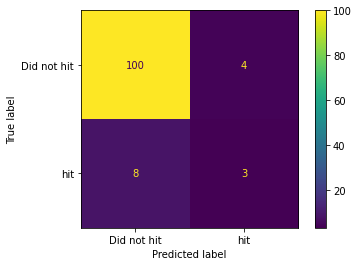

In [293]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [294]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [295]:
eval_set = [(X_test, y_test)]

In [296]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-aucpr:0.20713
[1]	validation_0-aucpr:0.22526
[2]	validation_0-aucpr:0.26830
[3]	validation_0-aucpr:0.34498
[4]	validation_0-aucpr:0.35575
[5]	validation_0-aucpr:0.34681
[6]	validation_0-aucpr:0.36102
[7]	validation_0-aucpr:0.36662
[8]	validation_0-aucpr:0.37639
[0]	validation_0-aucpr:0.36492
[9]	validation_0-aucpr:0.38167
[10]	validation_0-aucpr:0.37776
[1]	validation_0-aucpr:0.37110
[2]	validation_0-aucpr:0.38093
[3]	validation_0-aucpr:0.40406
[4]	validation_0-aucpr:0.42354
[5]	validation_0-aucpr:0.41594
[6]	validation_0-aucpr:0.34593
[7]	validation_0-aucpr:0.34157
[8]	validation_0-aucpr:0.34953
[11]	validation_0-aucpr:0.38043
[9]	validation_0-aucpr:0.36502
[12]	validation_0-aucpr:0.39223
[10]	validation_0-aucpr:0.37607
[13]	validation_0-aucpr:0.40303
[0]	validation_0-aucpr:0.38956
[1]	validation_0-aucpr:0.42598
[14]	validation_0-aucpr:0.40739
[11]	validation_0-aucpr:0.38182
[15]	validation_0-aucpr:0.32561

[15]	validation_0-aucpr:0.32965
[21]	validation_0-aucpr:0.42122
[16]	validation_0-aucpr:0.33797
[22]	validation_0-aucpr:0.41642
[20]	validation_0-aucpr:0.32508
[17]	validation_0-aucpr:0.32787
[23]	validation_0-aucpr:0.40953
[21]	validation_0-aucpr:0.32573
[18]	validation_0-aucpr:0.32919
[24]	validation_0-aucpr:0.42357
[19]	validation_0-aucpr:0.31895
[25]	validation_0-aucpr:0.40982
[20]	validation_0-aucpr:0.32498
[26]	validation_0-aucpr:0.38815
[21]	validation_0-aucpr:0.32337
[22]	validation_0-aucpr:0.31652
[22]	validation_0-aucpr:0.44310
[22]	validation_0-aucpr:0.31534
[23]	validation_0-aucpr:0.45185
[23]	validation_0-aucpr:0.30234
[23]	validation_0-aucpr:0.32430
[24]	validation_0-aucpr:0.46300
[25]	validation_0-aucpr:0.45890
[24]	validation_0-aucpr:0.32157
[25]	validation_0-aucpr:0.31715
[26]	validation_0-aucpr:0.47890
[26]	validation_0-aucpr:0.31370
[27]	validation_0-aucpr:0.48004
[27]	validation_0-aucpr:0.32014
[28]	validation_0-aucpr:0.47442
[28]	validation_0-aucpr:0.32415
[54]	val

[9]	validation_0-aucpr:0.41928
[10]	validation_0-aucpr:0.41024
[2]	validation_0-aucpr:0.32970
[11]	validation_0-aucpr:0.40024
[3]	validation_0-aucpr:0.32155
[4]	validation_0-aucpr:0.34207
[12]	validation_0-aucpr:0.39043
[13]	validation_0-aucpr:0.38695
[14]	validation_0-aucpr:0.39393
[43]	validation_0-aucpr:0.37223
[44]	validation_0-aucpr:0.36348
[87]	validation_0-aucpr:0.40071
[45]	validation_0-aucpr:0.36659
[88]	validation_0-aucpr:0.40112
[46]	validation_0-aucpr:0.36511
[47]	validation_0-aucpr:0.36303
[89]	validation_0-aucpr:0.40112
[48]	validation_0-aucpr:0.30050
[90]	validation_0-aucpr:0.39849
[49]	validation_0-aucpr:0.30035
[91]	validation_0-aucpr:0.39893
[50]	validation_0-aucpr:0.36245
[92]	validation_0-aucpr:0.39893
[93]	validation_0-aucpr:0.39893
[51]	validation_0-aucpr:0.36063
[52]	validation_0-aucpr:0.36110
[53]	validation_0-aucpr:0.35911
[54]	validation_0-aucpr:0.36110
[5]	validation_0-aucpr:0.32747
[55]	validation_0-aucpr:0.36110
[56]	validation_0-aucpr:0.36025
[57]	validati

[58]	validation_0-aucpr:0.41387
[14]	validation_0-aucpr:0.32920
[1]	validation_0-aucpr:0.36323
[59]	validation_0-aucpr:0.41379
[2]	validation_0-aucpr:0.37493
[9]	validation_0-aucpr:0.31698
[3]	validation_0-aucpr:0.44453
[40]	validation_0-aucpr:0.47907
[10]	validation_0-aucpr:0.31698
[4]	validation_0-aucpr:0.49131
[5]	validation_0-aucpr:0.49663
[11]	validation_0-aucpr:0.37812
[41]	validation_0-aucpr:0.48232
[12]	validation_0-aucpr:0.37812
[6]	validation_0-aucpr:0.50273
[42]	validation_0-aucpr:0.48161
[13]	validation_0-aucpr:0.38267
[7]	validation_0-aucpr:0.49663
[43]	validation_0-aucpr:0.48371
[14]	validation_0-aucpr:0.38149
[8]	validation_0-aucpr:0.49131
[44]	validation_0-aucpr:0.46879
[15]	validation_0-aucpr:0.37605
[45]	validation_0-aucpr:0.47474
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.33165
[16]	validation_0-aucpr:0.38420
[46]	validation_0-aucpr:0.46239
[1]	validation_0-aucpr:0.33165
[60]	valid

[96]	validation_0-aucpr:0.56468
[55]	validation_0-aucpr:0.33275
[97]	validation_0-aucpr:0.56468
[56]	validation_0-aucpr:0.33507
[98]	validation_0-aucpr:0.56468
[53]	validation_0-aucpr:0.53514
[57]	validation_0-aucpr:0.33507
[99]	validation_0-aucpr:0.56205
[58]	validation_0-aucpr:0.33419
[59]	validation_0-aucpr:0.33419
[54]	validation_0-aucpr:0.47213
[20]	validation_0-aucpr:0.43275
[55]	validation_0-aucpr:0.47213
[21]	validation_0-aucpr:0.44257
[58]	validation_0-aucpr:0.42990
[56]	validation_0-aucpr:0.47213
[22]	validation_0-aucpr:0.44520
[59]	validation_0-aucpr:0.36779
[23]	validation_0-aucpr:0.44315
[57]	validation_0-aucpr:0.47213
[60]	validation_0-aucpr:0.36958
[24]	validation_0-aucpr:0.44315
[58]	validation_0-aucpr:0.47213
[61]	validation_0-aucpr:0.37035
[25]	validation_0-aucpr:0.44521
[62]	validation_0-aucpr:0.36975
[26]	validation_0-aucpr:0.44521
[27]	validation_0-aucpr:0.44944
[63]	validation_0-aucpr:0.44718
[28]	validation_0-aucpr:0.44944
[64]	validation_0-aucpr:0.44806
[1]	vali

[52]	validation_0-aucpr:0.33211
[94]	validation_0-aucpr:0.56244
[53]	validation_0-aucpr:0.32856
[95]	validation_0-aucpr:0.56103
[96]	validation_0-aucpr:0.56103
[54]	validation_0-aucpr:0.32615
[55]	validation_0-aucpr:0.32933
[97]	validation_0-aucpr:0.57038
[54]	validation_0-aucpr:0.55260
[56]	validation_0-aucpr:0.33078
[98]	validation_0-aucpr:0.55988
[99]	validation_0-aucpr:0.56338
[57]	validation_0-aucpr:0.33584
[55]	validation_0-aucpr:0.55260
[58]	validation_0-aucpr:0.34158
[56]	validation_0-aucpr:0.55260
[5]	validation_0-aucpr:0.24859
[43]	validation_0-aucpr:0.51555
[57]	validation_0-aucpr:0.56509
[22]	validation_0-aucpr:0.44167
[6]	validation_0-aucpr:0.24859
[58]	validation_0-aucpr:0.56826
[44]	validation_0-aucpr:0.50166
[59]	validation_0-aucpr:0.56826
[45]	validation_0-aucpr:0.50166
[60]	validation_0-aucpr:0.56623
[46]	validation_0-aucpr:0.50652
[61]	validation_0-aucpr:0.56733
[47]	validation_0-aucpr:0.50652
[7]	validation_0-aucpr:0.24859
[62]	validation_0-aucpr:0.56436
[23]	valida

[16]	validation_0-aucpr:0.39783
[15]	validation_0-aucpr:0.30724
[38]	validation_0-aucpr:0.44267
[17]	validation_0-aucpr:0.40456
[16]	validation_0-aucpr:0.31093
[61]	validation_0-aucpr:0.43546
[39]	validation_0-aucpr:0.44267
[17]	validation_0-aucpr:0.31537
[18]	validation_0-aucpr:0.39969
[40]	validation_0-aucpr:0.44267
[62]	validation_0-aucpr:0.43357
[18]	validation_0-aucpr:0.31551
[63]	validation_0-aucpr:0.43533
[41]	validation_0-aucpr:0.44267
[19]	validation_0-aucpr:0.31340
[20]	validation_0-aucpr:0.31810
[19]	validation_0-aucpr:0.40411
[21]	validation_0-aucpr:0.31622
[20]	validation_0-aucpr:0.40849
[22]	validation_0-aucpr:0.32220
[21]	validation_0-aucpr:0.40698
[23]	validation_0-aucpr:0.38594
[75]	validation_0-aucpr:0.55904
[22]	validation_0-aucpr:0.40057
[24]	validation_0-aucpr:0.38735
[76]	validation_0-aucpr:0.55904
[25]	validation_0-aucpr:0.38465
[77]	validation_0-aucpr:0.55904
[26]	validation_0-aucpr:0.38465
[78]	validation_0-aucpr:0.55554
[27]	validation_0-aucpr:0.39004
[79]	val

[31]	validation_0-aucpr:0.44503
[73]	validation_0-aucpr:0.39069
[74]	validation_0-aucpr:0.39069
[32]	validation_0-aucpr:0.43069
[14]	validation_0-aucpr:0.34484
[38]	validation_0-aucpr:0.55473
[75]	validation_0-aucpr:0.39179
[15]	validation_0-aucpr:0.33985
[39]	validation_0-aucpr:0.55292
[33]	validation_0-aucpr:0.43069
[76]	validation_0-aucpr:0.39095
[16]	validation_0-aucpr:0.34264
[40]	validation_0-aucpr:0.55866
[34]	validation_0-aucpr:0.42854
[17]	validation_0-aucpr:0.33727
[41]	validation_0-aucpr:0.55922
[11]	validation_0-aucpr:0.34010
[35]	validation_0-aucpr:0.43403
[42]	validation_0-aucpr:0.56249
[18]	validation_0-aucpr:0.33727
[36]	validation_0-aucpr:0.43403
[43]	validation_0-aucpr:0.56249
[19]	validation_0-aucpr:0.40503
[37]	validation_0-aucpr:0.42503
[20]	validation_0-aucpr:0.35632
[44]	validation_0-aucpr:0.56821
[12]	validation_0-aucpr:0.40835
[38]	validation_0-aucpr:0.42469
[21]	validation_0-aucpr:0.41933
[22]	validation_0-aucpr:0.39692
[39]	validation_0-aucpr:0.42880
[13]	val

[47]	validation_0-aucpr:0.40195
[32]	validation_0-aucpr:0.35894
[52]	validation_0-aucpr:0.52443
[31]	validation_0-aucpr:0.43161
[33]	validation_0-aucpr:0.35894
[53]	validation_0-aucpr:0.52443
[32]	validation_0-aucpr:0.49056
[34]	validation_0-aucpr:0.35894
[54]	validation_0-aucpr:0.56129
[33]	validation_0-aucpr:0.48880
[35]	validation_0-aucpr:0.36023
[46]	validation_0-aucpr:0.38640
[24]	validation_0-aucpr:0.31256
[47]	validation_0-aucpr:0.38640
[72]	validation_0-aucpr:0.62950
[25]	validation_0-aucpr:0.31256
[36]	validation_0-aucpr:0.36208
[73]	validation_0-aucpr:0.62950
[48]	validation_0-aucpr:0.38640
[37]	validation_0-aucpr:0.36477
[38]	validation_0-aucpr:0.36181
[74]	validation_0-aucpr:0.60252
[39]	validation_0-aucpr:0.36647
[49]	validation_0-aucpr:0.38640
[40]	validation_0-aucpr:0.36477
[75]	validation_0-aucpr:0.60252
[41]	validation_0-aucpr:0.36425
[50]	validation_0-aucpr:0.38640
[76]	validation_0-aucpr:0.59947
[26]	validation_0-aucpr:0.30228
[77]	validation_0-aucpr:0.59947
[42]	val

[95]	validation_0-aucpr:0.53476
[9]	validation_0-aucpr:0.30017
[9]	validation_0-aucpr:0.48449
[96]	validation_0-aucpr:0.53476
[3]	validation_0-aucpr:0.27794
[10]	validation_0-aucpr:0.27795
[10]	validation_0-aucpr:0.48092
[4]	validation_0-aucpr:0.29637
[97]	validation_0-aucpr:0.53405
[11]	validation_0-aucpr:0.29854
[11]	validation_0-aucpr:0.48600
[5]	validation_0-aucpr:0.28451
[12]	validation_0-aucpr:0.49490
[98]	validation_0-aucpr:0.53405
[12]	validation_0-aucpr:0.29803
[36]	validation_0-aucpr:0.43416
[99]	validation_0-aucpr:0.53405
[13]	validation_0-aucpr:0.48989
[6]	validation_0-aucpr:0.30410
[16]	validation_0-aucpr:0.46211
[14]	validation_0-aucpr:0.49490
[7]	validation_0-aucpr:0.28376
[15]	validation_0-aucpr:0.48575
[16]	validation_0-aucpr:0.52963
[8]	validation_0-aucpr:0.31409
[17]	validation_0-aucpr:0.52085
[18]	validation_0-aucpr:0.58169
[9]	validation_0-aucpr:0.31910
[19]	validation_0-aucpr:0.55663
[20]	validation_0-aucpr:0.56646
[17]	validation_0-aucpr:0.46066
[10]	validation_0

[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-aucpr:0.35599
[1]	validation_0-aucpr:0.35599
[15]	validation_0-aucpr:0.44646
[16]	validation_0-aucpr:0.44132
[17]	validation_0-aucpr:0.44646
[18]	validation_0-aucpr:0.45168
[2]	validation_0-aucpr:0.35599
[3]	validation_0-aucpr:0.35599
[45]	validation_0-aucpr:0.28218
[4]	validation_0-aucpr:0.35599
[54]	validation_0-aucpr:0.31762
[46]	validation_0-aucpr:0.27949
[5]	validation_0-aucpr:0.35599
[47]	validation_0-aucpr:0.27949
[6]	validation_0-aucpr:0.35599
[55]	validation_0-aucpr:0.31762
[48]	validation_0-aucpr:0.28092
[7]	validation_0-aucpr:0.35599
[56]	validation_0-aucpr:0.31762
[49]	validation_0-aucpr:0.28018
[8]	validation_0-aucpr:0.35599
[54]	validation_0-aucpr:0.48343
[57]	validation_0-aucpr:0.31469
[58]	validation_0-aucpr:0.31469
[59]	validation_0-aucpr:0.30368
[55]	validation_0-aucpr:0.56858
[60]	validation_0-aucpr:0.30368
[56]	validation_0-aucpr:0.56858
[61]	vali

[4]	validation_0-aucpr:0.27454
[25]	validation_0-aucpr:0.37633
[5]	validation_0-aucpr:0.27454
[26]	validation_0-aucpr:0.37633
[6]	validation_0-aucpr:0.27454
[27]	validation_0-aucpr:0.37633
[28]	validation_0-aucpr:0.37633
[29]	validation_0-aucpr:0.37633
[30]	validation_0-aucpr:0.37633
[31]	validation_0-aucpr:0.37633
[32]	validation_0-aucpr:0.37633
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-aucpr:0.33165
[16]	validation_0-aucpr:0.37493
[1]	validation_0-aucpr:0.33165
[17]	validation_0-aucpr:0.37493
[18]	validation_0-aucpr:0.37493
[2]	validation_0-aucpr:0.33165
[19]	validation_0-aucpr:0.37493
[3]	validation_0-aucpr:0.33165
[20]	validation_0-aucpr:0.37493
[4]	validation_0-aucpr:0.33165
[5]	validation_0-aucpr:0.33165
[22]	validation_0-aucpr:0.35481
[21]	validation_0-aucpr:0.37493
[6]	validation_0-aucpr:0.33165
[22]	validation_0-aucpr:0.37493
[6]	validation_0-aucpr:0.31656
[7]	validation_0-aucpr:0.31656
[8]	valida

[19]	validation_0-aucpr:0.36124
[25]	validation_0-aucpr:0.28141
[20]	validation_0-aucpr:0.36124
[5]	validation_0-aucpr:0.37505
[21]	validation_0-aucpr:0.36124
[6]	validation_0-aucpr:0.37505
[7]	validation_0-aucpr:0.37505
[22]	validation_0-aucpr:0.36124
[8]	validation_0-aucpr:0.37505
[3]	validation_0-aucpr:0.43777
[23]	validation_0-aucpr:0.36124
[9]	validation_0-aucpr:0.37505
[10]	validation_0-aucpr:0.37505
[24]	validation_0-aucpr:0.36124
[24]	validation_0-aucpr:0.34795
[4]	validation_0-aucpr:0.38016
[25]	validation_0-aucpr:0.37781
[11]	validation_0-aucpr:0.37505
[25]	validation_0-aucpr:0.36124
[5]	validation_0-aucpr:0.38570
[26]	validation_0-aucpr:0.37781
[6]	validation_0-aucpr:0.38734
[27]	validation_0-aucpr:0.37781
[26]	validation_0-aucpr:0.36124
[7]	validation_0-aucpr:0.38734
[28]	validation_0-aucpr:0.37467
[8]	validation_0-aucpr:0.38734
[29]	validation_0-aucpr:0.37295
[9]	validation_0-aucpr:0.38734
[27]	validation_0-aucpr:0.41163
[30]	validation_0-aucpr:0.37295
[28]	validation_0-au

[57]	validation_0-aucpr:0.27256
[40]	validation_0-aucpr:0.50875
[58]	validation_0-aucpr:0.27256
[59]	validation_0-aucpr:0.27762
[41]	validation_0-aucpr:0.50875
[60]	validation_0-aucpr:0.27256
[42]	validation_0-aucpr:0.50875
[20]	validation_0-aucpr:0.42266
[53]	validation_0-aucpr:0.51426
[43]	validation_0-aucpr:0.50875
[21]	validation_0-aucpr:0.42266
[54]	validation_0-aucpr:0.51426
[44]	validation_0-aucpr:0.50875
[22]	validation_0-aucpr:0.42266
[55]	validation_0-aucpr:0.51426
[16]	validation_0-aucpr:0.36663
[56]	validation_0-aucpr:0.51426
[17]	validation_0-aucpr:0.41207
[9]	validation_0-aucpr:0.30880
[10]	validation_0-aucpr:0.29927
[58]	validation_0-aucpr:0.37951
[28]	validation_0-aucpr:0.24859
[11]	validation_0-aucpr:0.28423
[12]	validation_0-aucpr:0.29882
[29]	validation_0-aucpr:0.24859
[13]	validation_0-aucpr:0.28519
[30]	validation_0-aucpr:0.24859
[14]	validation_0-aucpr:0.30278
[59]	validation_0-aucpr:0.37951
[31]	validation_0-aucpr:0.24859
[60]	validation_0-aucpr:0.37951
[61]	vali

[28]	validation_0-aucpr:0.30306
[72]	validation_0-aucpr:0.43920
[29]	validation_0-aucpr:0.30306
[73]	validation_0-aucpr:0.43920
[30]	validation_0-aucpr:0.30306
[74]	validation_0-aucpr:0.43920
[31]	validation_0-aucpr:0.30306
[32]	validation_0-aucpr:0.30306
[33]	validation_0-aucpr:0.30306
[75]	validation_0-aucpr:0.43920
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-aucpr:0.35189
[70]	validation_0-aucpr:0.33342
[5]	validation_0-aucpr:0.31147
[24]	validation_0-aucpr:0.32385
[71]	validation_0-aucpr:0.33041
[6]	validation_0-aucpr:0.31147
[72]	validation_0-aucpr:0.33041
[25]	validation_0-aucpr:0.32101
[7]	validation_0-aucpr:0.31147
[73]	validation_0-aucpr:0.32532
[26]	validation_0-aucpr:0.31762
[8]	validation_0-aucpr:0.31147
[27]	validation_0-aucpr:0.32047
[9]	validation_0-aucpr:0.31147
[28]	validation_0-aucpr:0.32047
[10]	validation_0-aucpr:0.31147
[29]	validation_0-aucpr:0.32047
[6]	validation_0-aucpr:0.43069
[11]	va

[18]	validation_0-aucpr:0.35818
[19]	validation_0-aucpr:0.35818
[15]	validation_0-aucpr:0.26369
[20]	validation_0-aucpr:0.35818
[16]	validation_0-aucpr:0.26369
[21]	validation_0-aucpr:0.35818
[22]	validation_0-aucpr:0.35818
[17]	validation_0-aucpr:0.26369
[23]	validation_0-aucpr:0.35818
[18]	validation_0-aucpr:0.26369
[24]	validation_0-aucpr:0.35818
[19]	validation_0-aucpr:0.26369
[28]	validation_0-aucpr:0.40939
[20]	validation_0-aucpr:0.26369
[21]	validation_0-aucpr:0.26369
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-aucpr:0.35189
[29]	validation_0-aucpr:0.40939
[1]	validation_0-aucpr:0.35189
[30]	validation_0-aucpr:0.40636
[2]	validation_0-aucpr:0.35189
[27]	validation_0-aucpr:0.31296
[31]	validation_0-aucpr:0.40939
[28]	validation_0-aucpr:0.31296
[32]	validation_0-aucpr:0.40636
[29]	validation_0-aucpr:0.31296
[33]	validation_0-aucpr:0.40636
[34]	validation_0-aucpr:0.40636
[35]	validation_0-aucpr:0.43936
[

[15]	validation_0-aucpr:0.28336
[6]	validation_0-aucpr:0.25645
[7]	validation_0-aucpr:0.26130
[16]	validation_0-aucpr:0.29070
[8]	validation_0-aucpr:0.25645
[17]	validation_0-aucpr:0.28632
[9]	validation_0-aucpr:0.26130
[18]	validation_0-aucpr:0.27589
[10]	validation_0-aucpr:0.25645
[20]	validation_0-aucpr:0.39613
[21]	validation_0-aucpr:0.39613
[22]	validation_0-aucpr:0.39613
[23]	validation_0-aucpr:0.39042
[24]	validation_0-aucpr:0.45609
[25]	validation_0-aucpr:0.45609
[45]	validation_0-aucpr:0.29035
[26]	validation_0-aucpr:0.45609
[46]	validation_0-aucpr:0.29035
[4]	validation_0-aucpr:0.40252
[27]	validation_0-aucpr:0.46250
[47]	validation_0-aucpr:0.29035
[5]	validation_0-aucpr:0.41760
[6]	validation_0-aucpr:0.41760
[48]	validation_0-aucpr:0.28947
[7]	validation_0-aucpr:0.41760
[19]	validation_0-aucpr:0.28222
[49]	validation_0-aucpr:0.28884
[20]	validation_0-aucpr:0.29293
[50]	validation_0-aucpr:0.29517
[11]	validation_0-aucpr:0.24666
[8]	validation_0-aucpr:0.41760
[51]	validation_0

[4]	validation_0-aucpr:0.35189
[60]	validation_0-aucpr:0.43793
[5]	validation_0-aucpr:0.35189
[61]	validation_0-aucpr:0.43793
[32]	validation_0-aucpr:0.46648
[6]	validation_0-aucpr:0.31472
[50]	validation_0-aucpr:0.29111
[7]	validation_0-aucpr:0.31472
[33]	validation_0-aucpr:0.44932
[8]	validation_0-aucpr:0.31472
[34]	validation_0-aucpr:0.44932
[35]	validation_0-aucpr:0.44932
[9]	validation_0-aucpr:0.31472
[36]	validation_0-aucpr:0.45523
[37]	validation_0-aucpr:0.44932
[10]	validation_0-aucpr:0.31472
[38]	validation_0-aucpr:0.44932
[11]	validation_0-aucpr:0.31472
[39]	validation_0-aucpr:0.44932
[63]	validation_0-aucpr:0.33840
[40]	validation_0-aucpr:0.44932
[64]	validation_0-aucpr:0.33342
[65]	validation_0-aucpr:0.33342
[66]	validation_0-aucpr:0.33184
[67]	validation_0-aucpr:0.33184
[68]	validation_0-aucpr:0.33342
[69]	validation_0-aucpr:0.33342
[88]	validation_0-aucpr:0.48946
[62]	validation_0-aucpr:0.43793
[63]	validation_0-aucpr:0.43948
[89]	validation_0-aucpr:0.48946
[90]	validatio

[8]	validation_0-aucpr:0.26369
[9]	validation_0-aucpr:0.26369
[20]	validation_0-aucpr:0.32322
[10]	validation_0-aucpr:0.26369
[21]	validation_0-aucpr:0.32322
[11]	validation_0-aucpr:0.26369
[22]	validation_0-aucpr:0.31467
[12]	validation_0-aucpr:0.26369
[23]	validation_0-aucpr:0.32322
[13]	validation_0-aucpr:0.26369
[24]	validation_0-aucpr:0.32322
[14]	validation_0-aucpr:0.26369
[25]	validation_0-aucpr:0.32501
[26]	validation_0-aucpr:0.32915
[14]	validation_0-aucpr:0.35818
[95]	validation_0-aucpr:0.50834
[15]	validation_0-aucpr:0.35818
[96]	validation_0-aucpr:0.50834
[16]	validation_0-aucpr:0.35818
[97]	validation_0-aucpr:0.50834
[17]	validation_0-aucpr:0.35818
[98]	validation_0-aucpr:0.50834
[99]	validation_0-aucpr:0.50834
[18]	validation_0-aucpr:0.35818
[19]	validation_0-aucpr:0.35818
[20]	validation_0-aucpr:0.35818
[15]	validation_0-aucpr:0.26369
[16]	validation_0-aucpr:0.26369
[17]	validation_0-aucpr:0.26369
[18]	validation_0-aucpr:0.26369
[19]	validation_0-aucpr:0.26369
[CV] END g

[3]	validation_0-aucpr:0.43667
[11]	validation_0-aucpr:0.37366
[25]	validation_0-aucpr:0.39081
[4]	validation_0-aucpr:0.43667
[12]	validation_0-aucpr:0.38765
[5]	validation_0-aucpr:0.44412
[13]	validation_0-aucpr:0.39517
[6]	validation_0-aucpr:0.44695
[14]	validation_0-aucpr:0.30906
[7]	validation_0-aucpr:0.53625
[8]	validation_0-aucpr:0.53625
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-aucpr:0.21406
[1]	validation_0-aucpr:0.24561
[2]	validation_0-aucpr:0.24561
[69]	validation_0-aucpr:0.28982
[66]	validation_0-aucpr:0.38019
[67]	validation_0-aucpr:0.38019
[68]	validation_0-aucpr:0.38019
[70]	validation_0-aucpr:0.29129
[69]	validation_0-aucpr:0.38019
[71]	validation_0-aucpr:0.29129
[70]	validation_0-aucpr:0.38019
[72]	validation_0-aucpr:0.28982
[71]	validation_0-aucpr:0.38019
[73]	validation_0-aucpr:0.29129
[74]	validation_0-aucpr:0.29129
[33]	validation_0-aucpr:0.50454
[CV] END gamma=0, learning_rate=0.01, m

[71]	validation_0-aucpr:0.61937
[72]	validation_0-aucpr:0.61632
[37]	validation_0-aucpr:0.40529
[73]	validation_0-aucpr:0.61767
[38]	validation_0-aucpr:0.39786
[74]	validation_0-aucpr:0.62013
[39]	validation_0-aucpr:0.40136
[34]	validation_0-aucpr:0.32550
[40]	validation_0-aucpr:0.39885
[41]	validation_0-aucpr:0.40635
[42]	validation_0-aucpr:0.39885
[35]	validation_0-aucpr:0.32704
[43]	validation_0-aucpr:0.40260
[36]	validation_0-aucpr:0.32165
[9]	validation_0-aucpr:0.34335
[44]	validation_0-aucpr:0.40371
[37]	validation_0-aucpr:0.32204
[10]	validation_0-aucpr:0.32377
[11]	validation_0-aucpr:0.34335
[38]	validation_0-aucpr:0.32523
[12]	validation_0-aucpr:0.32389
[39]	validation_0-aucpr:0.32549
[13]	validation_0-aucpr:0.32389
[40]	validation_0-aucpr:0.32505
[14]	validation_0-aucpr:0.31975
[35]	validation_0-aucpr:0.41359
[41]	validation_0-aucpr:0.32555
[15]	validation_0-aucpr:0.31627
[36]	validation_0-aucpr:0.41378
[16]	validation_0-aucpr:0.32616
[75]	validation_0-aucpr:0.63416
[4]	valid

[30]	validation_0-aucpr:0.40520
[40]	validation_0-aucpr:0.30982
[31]	validation_0-aucpr:0.40520
[41]	validation_0-aucpr:0.30628
[32]	validation_0-aucpr:0.40401
[42]	validation_0-aucpr:0.31419
[43]	validation_0-aucpr:0.31040
[33]	validation_0-aucpr:0.40401
[22]	validation_0-aucpr:0.38042
[23]	validation_0-aucpr:0.36471
[24]	validation_0-aucpr:0.36092
[25]	validation_0-aucpr:0.38953
[25]	validation_0-aucpr:0.36092
[26]	validation_0-aucpr:0.36366
[27]	validation_0-aucpr:0.36971
[28]	validation_0-aucpr:0.37526
[26]	validation_0-aucpr:0.39322
[17]	validation_0-aucpr:0.31848
[27]	validation_0-aucpr:0.38276
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.23898
[28]	validation_0-aucpr:0.38276
[29]	validation_0-aucpr:0.38974
[1]	validation_0-aucpr:0.27454
[30]	validation_0-aucpr:0.39322
[2]	validation_0-aucpr:0.27454
[3]	validation_0-aucpr:0.27454
[31]	validation_0-aucpr:0.39322
[4]	validation_0-aucpr:0.27454
[5]	v

[44]	validation_0-aucpr:0.32505
[45]	validation_0-aucpr:0.32787
[46]	validation_0-aucpr:0.32154
[47]	validation_0-aucpr:0.32154
[48]	validation_0-aucpr:0.32154
[9]	validation_0-aucpr:0.31656
[49]	validation_0-aucpr:0.31690
[50]	validation_0-aucpr:0.32064
[10]	validation_0-aucpr:0.31656
[51]	validation_0-aucpr:0.31807
[52]	validation_0-aucpr:0.31343
[11]	validation_0-aucpr:0.31656
[53]	validation_0-aucpr:0.31947
[1]	validation_0-aucpr:0.33165
[36]	validation_0-aucpr:0.45728
[2]	validation_0-aucpr:0.33165
[3]	validation_0-aucpr:0.37896
[37]	validation_0-aucpr:0.45728
[4]	validation_0-aucpr:0.37896
[5]	validation_0-aucpr:0.37896
[6]	validation_0-aucpr:0.37896
[7]	validation_0-aucpr:0.37896
[38]	validation_0-aucpr:0.43972
[39]	validation_0-aucpr:0.44766
[8]	validation_0-aucpr:0.37896
[30]	validation_0-aucpr:0.51824
[12]	validation_0-aucpr:0.31656
[40]	validation_0-aucpr:0.45153
[9]	validation_0-aucpr:0.37896
[31]	validation_0-aucpr:0.51824
[13]	validation_0-aucpr:0.31656
[41]	validation_0-

[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.23295
[1]	validation_0-aucpr:0.26285
[27]	validation_0-aucpr:0.40237
[2]	validation_0-aucpr:0.25287
[28]	validation_0-aucpr:0.40237
[3]	validation_0-aucpr:0.26153
[29]	validation_0-aucpr:0.40237
[30]	validation_0-aucpr:0.40237
[4]	validation_0-aucpr:0.32294
[31]	validation_0-aucpr:0.39589
[32]	validation_0-aucpr:0.39589
[33]	validation_0-aucpr:0.39589
[34]	validation_0-aucpr:0.40078
[40]	validation_0-aucpr:0.46200
[41]	validation_0-aucpr:0.46200
[42]	validation_0-aucpr:0.46116
[43]	validation_0-aucpr:0.45961
[44]	validation_0-aucpr:0.45961
[77]	validation_0-aucpr:0.52800
[45]	validation_0-aucpr:0.46156
[78]	validation_0-aucpr:0.52537
[46]	validation_0-aucpr:0.44611
[79]	validation_0-aucpr:0.52711
[80]	validation_0-aucpr:0.46660
[81]	validation_0-aucpr:0.46750
[82]	validation_0-aucpr:0.45992
[83]	validation_0-aucpr:0.46385
[84]	validation_0-aucpr:0.46499
[5

[17]	validation_0-aucpr:0.51482
[56]	validation_0-aucpr:0.47800
[57]	validation_0-aucpr:0.48252
[18]	validation_0-aucpr:0.51482
[20]	validation_0-aucpr:0.27155
[58]	validation_0-aucpr:0.48202
[59]	validation_0-aucpr:0.48552
[21]	validation_0-aucpr:0.26737
[60]	validation_0-aucpr:0.48138
[61]	validation_0-aucpr:0.48046
[63]	validation_0-aucpr:0.32153
[22]	validation_0-aucpr:0.27686
[23]	validation_0-aucpr:0.28278
[64]	validation_0-aucpr:0.32217
[98]	validation_0-aucpr:0.44992
[62]	validation_0-aucpr:0.48455
[24]	validation_0-aucpr:0.29018
[63]	validation_0-aucpr:0.48478
[65]	validation_0-aucpr:0.32193
[99]	validation_0-aucpr:0.45003
[25]	validation_0-aucpr:0.28888
[64]	validation_0-aucpr:0.48303
[66]	validation_0-aucpr:0.32795
[65]	validation_0-aucpr:0.48303
[67]	validation_0-aucpr:0.32674
[21]	validation_0-aucpr:0.29975
[68]	validation_0-aucpr:0.32674
[22]	validation_0-aucpr:0.28698
[23]	validation_0-aucpr:0.28885
[69]	validation_0-aucpr:0.32021
[44]	validation_0-aucpr:0.46727
[45]	val

[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[0]	validation_0-aucpr:0.42125
[22]	validation_0-aucpr:0.40387
[1]	validation_0-aucpr:0.42536
[2]	validation_0-aucpr:0.42536
[23]	validation_0-aucpr:0.40569
[3]	validation_0-aucpr:0.42536
[24]	validation_0-aucpr:0.40569
[4]	validation_0-aucpr:0.46254
[25]	validation_0-aucpr:0.40779
[66]	validation_0-aucpr:0.32803
[5]	validation_0-aucpr:0.47562
[6]	validation_0-aucpr:0.45478
[67]	validation_0-aucpr:0.32659
[7]	validation_0-aucpr:0.44906
[68]	validation_0-aucpr:0.32594
[69]	validation_0-aucpr:0.33034
[8]	validation_0-aucpr:0.47562
[70]	validation_0-aucpr:0.33019
[9]	validation_0-aucpr:0.44906
[71]	validation_0-aucpr:0.33019
[10]	validation_0-aucpr:0.45579
[11]	validation_0-aucpr:0.44906
[15]	validation_0-aucpr:0.34638
[72]	validation_0-aucpr:0.33019
[19]	validation_0-aucpr:0.43814
[16]	validation_0-aucpr:0.34545
[20]	validation_0-aucpr:0.44755
[59]	validation_0-aucpr:0.53976
[17]	valid

[88]	validation_0-aucpr:0.31465
[5]	validation_0-aucpr:0.30981
[89]	validation_0-aucpr:0.31324
[11]	validation_0-aucpr:0.30568
[90]	validation_0-aucpr:0.30606
[91]	validation_0-aucpr:0.31371
[12]	validation_0-aucpr:0.30349
[18]	validation_0-aucpr:0.28802
[92]	validation_0-aucpr:0.31358
[13]	validation_0-aucpr:0.30823
[93]	validation_0-aucpr:0.31154
[19]	validation_0-aucpr:0.28802
[94]	validation_0-aucpr:0.31358
[14]	validation_0-aucpr:0.31464
[20]	validation_0-aucpr:0.28802
[95]	validation_0-aucpr:0.31325
[96]	validation_0-aucpr:0.31325
[21]	validation_0-aucpr:0.29325
[22]	validation_0-aucpr:0.28872
[97]	validation_0-aucpr:0.31413
[98]	validation_0-aucpr:0.31413
[23]	validation_0-aucpr:0.29155
[99]	validation_0-aucpr:0.31053
[68]	validation_0-aucpr:0.46285
[16]	validation_0-aucpr:0.35709
[69]	validation_0-aucpr:0.46611
[17]	validation_0-aucpr:0.35912
[70]	validation_0-aucpr:0.46611
[71]	validation_0-aucpr:0.46611
[18]	validation_0-aucpr:0.39430
[72]	validation_0-aucpr:0.46441
[6]	valid

[71]	validation_0-aucpr:0.42208
[20]	validation_0-aucpr:0.39611
[3]	validation_0-aucpr:0.34132
[21]	validation_0-aucpr:0.39568
[72]	validation_0-aucpr:0.42284
[4]	validation_0-aucpr:0.32879
[22]	validation_0-aucpr:0.41007
[23]	validation_0-aucpr:0.41304
[5]	validation_0-aucpr:0.34272
[6]	validation_0-aucpr:0.34272
[7]	validation_0-aucpr:0.33784
[8]	validation_0-aucpr:0.33889
[9]	validation_0-aucpr:0.33760
[10]	validation_0-aucpr:0.33760
[11]	validation_0-aucpr:0.33760
[12]	validation_0-aucpr:0.32848
[13]	validation_0-aucpr:0.33162
[14]	validation_0-aucpr:0.33803
[11]	validation_0-aucpr:0.38753
[24]	validation_0-aucpr:0.40712
[12]	validation_0-aucpr:0.38753
[25]	validation_0-aucpr:0.41304
[13]	validation_0-aucpr:0.38753
[14]	validation_0-aucpr:0.38753
[26]	validation_0-aucpr:0.41304
[27]	validation_0-aucpr:0.41304
[15]	validation_0-aucpr:0.38695
[28]	validation_0-aucpr:0.41304
[16]	validation_0-aucpr:0.38695
[17]	validation_0-aucpr:0.38695
[29]	validation_0-aucpr:0.41548
[30]	validation

[91]	validation_0-aucpr:0.49041
[17]	validation_0-aucpr:0.47209
[79]	validation_0-aucpr:0.44162
[92]	validation_0-aucpr:0.49159
[80]	validation_0-aucpr:0.44209
[18]	validation_0-aucpr:0.46885
[93]	validation_0-aucpr:0.49242
[81]	validation_0-aucpr:0.44200
[94]	validation_0-aucpr:0.49242
[19]	validation_0-aucpr:0.46979
[82]	validation_0-aucpr:0.44207
[20]	validation_0-aucpr:0.46574
[83]	validation_0-aucpr:0.43649
[84]	validation_0-aucpr:0.43238
[21]	validation_0-aucpr:0.45965
[95]	validation_0-aucpr:0.49508
[85]	validation_0-aucpr:0.43539
[22]	validation_0-aucpr:0.45957
[96]	validation_0-aucpr:0.49508
[52]	validation_0-aucpr:0.38812
[53]	validation_0-aucpr:0.38884
[48]	validation_0-aucpr:0.42492
[86]	validation_0-aucpr:0.43624
[87]	validation_0-aucpr:0.43404
[54]	validation_0-aucpr:0.38847
[97]	validation_0-aucpr:0.49242
[49]	validation_0-aucpr:0.42492
[88]	validation_0-aucpr:0.43580
[98]	validation_0-aucpr:0.49013
[55]	validation_0-aucpr:0.38884
[50]	validation_0-aucpr:0.42492
[89]	val

[75]	validation_0-aucpr:0.53001
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.40252
[23]	validation_0-aucpr:0.28738
[76]	validation_0-aucpr:0.53503
[12]	validation_0-aucpr:0.31511
[24]	validation_0-aucpr:0.28873
[77]	validation_0-aucpr:0.53412
[78]	validation_0-aucpr:0.52861
[25]	validation_0-aucpr:0.28753
[79]	validation_0-aucpr:0.52861
[13]	validation_0-aucpr:0.31021
[15]	validation_0-aucpr:0.47794
[14]	validation_0-aucpr:0.31835
[16]	validation_0-aucpr:0.48096
[10]	validation_0-aucpr:0.24295
[15]	validation_0-aucpr:0.31632
[17]	validation_0-aucpr:0.48942
[11]	validation_0-aucpr:0.24295
[18]	validation_0-aucpr:0.48942
[12]	validation_0-aucpr:0.23831
[19]	validation_0-aucpr:0.48822
[20]	validation_0-aucpr:0.52535
[13]	validation_0-aucpr:0.23831
[21]	validation_0-aucpr:0.52802
[14]	validation_0-aucpr:0.23831
[26]	validation_0-aucpr:0.27708
[15]	validation_0-aucpr:0.23831
[16]	validation_0-aucpr:0.23831
[

[86]	validation_0-aucpr:0.31323
[22]	validation_0-aucpr:0.48530
[79]	validation_0-aucpr:0.60547
[80]	validation_0-aucpr:0.60547
[81]	validation_0-aucpr:0.60519
[82]	validation_0-aucpr:0.60519
[83]	validation_0-aucpr:0.60216
[84]	validation_0-aucpr:0.60216
[85]	validation_0-aucpr:0.60216
[86]	validation_0-aucpr:0.60063
[87]	validation_0-aucpr:0.61046
[1]	validation_0-aucpr:0.30618
[30]	validation_0-aucpr:0.31360
[2]	validation_0-aucpr:0.28423
[23]	validation_0-aucpr:0.47691
[3]	validation_0-aucpr:0.27217
[31]	validation_0-aucpr:0.30791
[24]	validation_0-aucpr:0.48530
[4]	validation_0-aucpr:0.27156
[5]	validation_0-aucpr:0.27223
[32]	validation_0-aucpr:0.30672
[6]	validation_0-aucpr:0.26785
[7]	validation_0-aucpr:0.27534
[25]	validation_0-aucpr:0.48530
[33]	validation_0-aucpr:0.30327
[26]	validation_0-aucpr:0.48530
[34]	validation_0-aucpr:0.31559
[35]	validation_0-aucpr:0.30945
[27]	validation_0-aucpr:0.48530
[28]	validation_0-aucpr:0.47961
[50]	validation_0-aucpr:0.43822
[36]	validation

[47]	validation_0-aucpr:0.31972
[48]	validation_0-aucpr:0.32381
[27]	validation_0-aucpr:0.28517
[28]	validation_0-aucpr:0.28517
[25]	validation_0-aucpr:0.38334
[29]	validation_0-aucpr:0.28934
[26]	validation_0-aucpr:0.38748
[27]	validation_0-aucpr:0.38748
[28]	validation_0-aucpr:0.38748
[29]	validation_0-aucpr:0.38334
[22]	validation_0-aucpr:0.41007
[61]	validation_0-aucpr:0.36990
[62]	validation_0-aucpr:0.36706
[23]	validation_0-aucpr:0.41304
[30]	validation_0-aucpr:0.38748
[63]	validation_0-aucpr:0.36706
[24]	validation_0-aucpr:0.40712
[25]	validation_0-aucpr:0.41304
[64]	validation_0-aucpr:0.36706
[31]	validation_0-aucpr:0.38684
[26]	validation_0-aucpr:0.41304
[65]	validation_0-aucpr:0.36706
[27]	validation_0-aucpr:0.41304
[66]	validation_0-aucpr:0.36990
[49]	validation_0-aucpr:0.32800
[67]	validation_0-aucpr:0.36990
[28]	validation_0-aucpr:0.41304
[50]	validation_0-aucpr:0.33309
[51]	validation_0-aucpr:0.33105
[37]	validation_0-aucpr:0.47541
[52]	validation_0-aucpr:0.33105
[53]	val

[58]	validation_0-aucpr:0.40561
[59]	validation_0-aucpr:0.40751
[17]	validation_0-aucpr:0.37747
[60]	validation_0-aucpr:0.40751
[61]	validation_0-aucpr:0.40751
[26]	validation_0-aucpr:0.30164
[62]	validation_0-aucpr:0.40751
[18]	validation_0-aucpr:0.37747
[27]	validation_0-aucpr:0.29997
[63]	validation_0-aucpr:0.40751
[64]	validation_0-aucpr:0.40751
[28]	validation_0-aucpr:0.30124
[19]	validation_0-aucpr:0.37747
[65]	validation_0-aucpr:0.40751
[66]	validation_0-aucpr:0.40751
[20]	validation_0-aucpr:0.37747
[67]	validation_0-aucpr:0.40751
[21]	validation_0-aucpr:0.37104
[26]	validation_0-aucpr:0.40426
[27]	validation_0-aucpr:0.40426
[62]	validation_0-aucpr:0.44560
[3]	validation_0-aucpr:0.30540
[28]	validation_0-aucpr:0.40426
[63]	validation_0-aucpr:0.44406
[4]	validation_0-aucpr:0.31392
[29]	validation_0-aucpr:0.40426
[86]	validation_0-aucpr:0.55060
[5]	validation_0-aucpr:0.31392
[64]	validation_0-aucpr:0.44406
[30]	validation_0-aucpr:0.40426
[6]	validation_0-aucpr:0.30540
[65]	validat

[17]	validation_0-aucpr:0.43115
[18]	validation_0-aucpr:0.41828
[19]	validation_0-aucpr:0.42257
[20]	validation_0-aucpr:0.42290
[10]	validation_0-aucpr:0.35628
[11]	validation_0-aucpr:0.36576
[20]	validation_0-aucpr:0.60400
[12]	validation_0-aucpr:0.37235
[13]	validation_0-aucpr:0.36576
[13]	validation_0-aucpr:0.42529
[14]	validation_0-aucpr:0.36430
[15]	validation_0-aucpr:0.37319
[21]	validation_0-aucpr:0.41974
[21]	validation_0-aucpr:0.60337
[22]	validation_0-aucpr:0.42290
[22]	validation_0-aucpr:0.60430
[23]	validation_0-aucpr:0.41940
[23]	validation_0-aucpr:0.60400
[24]	validation_0-aucpr:0.61477
[24]	validation_0-aucpr:0.41765
[25]	validation_0-aucpr:0.61957
[25]	validation_0-aucpr:0.41765
[14]	validation_0-aucpr:0.42529
[26]	validation_0-aucpr:0.61300
[16]	validation_0-aucpr:0.35051
[26]	validation_0-aucpr:0.40845
[15]	validation_0-aucpr:0.41868
[27]	validation_0-aucpr:0.40054
[16]	validation_0-aucpr:0.37749
[28]	validation_0-aucpr:0.38693
[17]	validation_0-aucpr:0.36887
[13]	val

[31]	validation_0-aucpr:0.58456
[32]	validation_0-aucpr:0.58456
[33]	validation_0-aucpr:0.58456
[34]	validation_0-aucpr:0.58456
[35]	validation_0-aucpr:0.58030
[93]	validation_0-aucpr:0.41948
[20]	validation_0-aucpr:0.39654
[94]	validation_0-aucpr:0.41948
[21]	validation_0-aucpr:0.39139
[95]	validation_0-aucpr:0.41948
[22]	validation_0-aucpr:0.39618
[96]	validation_0-aucpr:0.41948
[23]	validation_0-aucpr:0.39601
[97]	validation_0-aucpr:0.41948
[98]	validation_0-aucpr:0.41948
[24]	validation_0-aucpr:0.41012
[99]	validation_0-aucpr:0.41948
[25]	validation_0-aucpr:0.40173
[26]	validation_0-aucpr:0.37991
[27]	validation_0-aucpr:0.38785
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-aucpr:0.32160
[1]	validation_0-aucpr:0.26146
[2]	validation_0-aucpr:0.36499
[28]	validation_0-aucpr:0.38680
[29]	validation_0-aucpr:0.39604
[30]	validation_0-aucpr:0.40299
[31]	validation_0-aucpr:0.40548
[36]	validation_0-aucpr:0.57617
[

[45]	validation_0-aucpr:0.52356
[23]	validation_0-aucpr:0.38767
[46]	validation_0-aucpr:0.52311
[24]	validation_0-aucpr:0.39568
[47]	validation_0-aucpr:0.52107
[25]	validation_0-aucpr:0.39212
[26]	validation_0-aucpr:0.41028
[14]	validation_0-aucpr:0.41548
[6]	validation_0-aucpr:0.38753
[27]	validation_0-aucpr:0.41028
[7]	validation_0-aucpr:0.38753
[15]	validation_0-aucpr:0.41844
[28]	validation_0-aucpr:0.39638
[8]	validation_0-aucpr:0.39082
[16]	validation_0-aucpr:0.41548
[29]	validation_0-aucpr:0.39899
[9]	validation_0-aucpr:0.39082
[37]	validation_0-aucpr:0.31648
[17]	validation_0-aucpr:0.42076
[39]	validation_0-aucpr:0.39472
[38]	validation_0-aucpr:0.31268
[40]	validation_0-aucpr:0.39770
[18]	validation_0-aucpr:0.45798
[10]	validation_0-aucpr:0.39994
[39]	validation_0-aucpr:0.31220
[41]	validation_0-aucpr:0.37987
[19]	validation_0-aucpr:0.46009
[11]	validation_0-aucpr:0.39994
[40]	validation_0-aucpr:0.31420
[42]	validation_0-aucpr:0.39296
[12]	validation_0-aucpr:0.39994
[20]	validat

[14]	validation_0-aucpr:0.37568
[15]	validation_0-aucpr:0.38974
[16]	validation_0-aucpr:0.38974
[87]	validation_0-aucpr:0.53110
[17]	validation_0-aucpr:0.39168
[18]	validation_0-aucpr:0.39168
[19]	validation_0-aucpr:0.39666
[20]	validation_0-aucpr:0.39168
[21]	validation_0-aucpr:0.39666
[22]	validation_0-aucpr:0.40077
[23]	validation_0-aucpr:0.40111
[24]	validation_0-aucpr:0.40676
[25]	validation_0-aucpr:0.40676
[88]	validation_0-aucpr:0.53110
[26]	validation_0-aucpr:0.34375
[89]	validation_0-aucpr:0.53110
[90]	validation_0-aucpr:0.53110
[27]	validation_0-aucpr:0.34757
[26]	validation_0-aucpr:0.49956
[91]	validation_0-aucpr:0.53110
[28]	validation_0-aucpr:0.34346
[77]	validation_0-aucpr:0.56683
[92]	validation_0-aucpr:0.53110
[29]	validation_0-aucpr:0.34439
[93]	validation_0-aucpr:0.53110
[78]	validation_0-aucpr:0.56217
[30]	validation_0-aucpr:0.34540
[27]	validation_0-aucpr:0.50138
[94]	validation_0-aucpr:0.53110
[31]	validation_0-aucpr:0.34837
[28]	validation_0-aucpr:0.50138
[95]	val

[11]	validation_0-aucpr:0.43176
[22]	validation_0-aucpr:0.31198
[30]	validation_0-aucpr:0.32484
[12]	validation_0-aucpr:0.44378
[31]	validation_0-aucpr:0.32262
[13]	validation_0-aucpr:0.43037
[32]	validation_0-aucpr:0.32901
[33]	validation_0-aucpr:0.33156
[14]	validation_0-aucpr:0.43037
[34]	validation_0-aucpr:0.33156
[15]	validation_0-aucpr:0.42198
[35]	validation_0-aucpr:0.33227
[16]	validation_0-aucpr:0.42372
[36]	validation_0-aucpr:0.33227
[17]	validation_0-aucpr:0.42866
[37]	validation_0-aucpr:0.33156
[18]	validation_0-aucpr:0.42424
[19]	validation_0-aucpr:0.43065
[20]	validation_0-aucpr:0.43065
[21]	validation_0-aucpr:0.42424
[22]	validation_0-aucpr:0.41918
[24]	validation_0-aucpr:0.44315
[69]	validation_0-aucpr:0.47850
[25]	validation_0-aucpr:0.44521
[70]	validation_0-aucpr:0.47850
[26]	validation_0-aucpr:0.44521
[27]	validation_0-aucpr:0.44944
[71]	validation_0-aucpr:0.48066
[28]	validation_0-aucpr:0.44944
[72]	validation_0-aucpr:0.48298
[29]	validation_0-aucpr:0.44293
[73]	val

[12]	validation_0-aucpr:0.38285
[60]	validation_0-aucpr:0.45166
[13]	validation_0-aucpr:0.36397
[14]	validation_0-aucpr:0.38048
[61]	validation_0-aucpr:0.45202
[15]	validation_0-aucpr:0.38658
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.16931
[16]	validation_0-aucpr:0.40319
[1]	validation_0-aucpr:0.21244
[17]	validation_0-aucpr:0.40099
[2]	validation_0-aucpr:0.21244
[18]	validation_0-aucpr:0.42211
[25]	validation_0-aucpr:0.32226
[3]	validation_0-aucpr:0.25171
[26]	validation_0-aucpr:0.32690
[39]	validation_0-aucpr:0.46244
[27]	validation_0-aucpr:0.33323
[40]	validation_0-aucpr:0.46546
[28]	validation_0-aucpr:0.32226
[41]	validation_0-aucpr:0.46895
[42]	validation_0-aucpr:0.47197
[29]	validation_0-aucpr:0.32226
[43]	validation_0-aucpr:0.47107
[30]	validation_0-aucpr:0.32226
[44]	validation_0-aucpr:0.46814
[31]	validation_0-aucpr:0.32690
[32]	validation_0-aucpr:0.32824
[45]	validation_0-aucpr:0.46602

[22]	validation_0-aucpr:0.43736
[23]	validation_0-aucpr:0.44668
[91]	validation_0-aucpr:0.33193
[92]	validation_0-aucpr:0.33193
[93]	validation_0-aucpr:0.33193
[94]	validation_0-aucpr:0.33193
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-aucpr:0.42125
[95]	validation_0-aucpr:0.33193
[24]	validation_0-aucpr:0.45428
[96]	validation_0-aucpr:0.33193
[1]	validation_0-aucpr:0.42536
[41]	validation_0-aucpr:0.31668
[25]	validation_0-aucpr:0.46786
[2]	validation_0-aucpr:0.46254
[3]	validation_0-aucpr:0.47562
[26]	validation_0-aucpr:0.47136
[42]	validation_0-aucpr:0.31427
[27]	validation_0-aucpr:0.53939
[4]	validation_0-aucpr:0.44906
[28]	validation_0-aucpr:0.53939
[5]	validation_0-aucpr:0.45579
[43]	validation_0-aucpr:0.31736
[29]	validation_0-aucpr:0.53867
[3]	validation_0-aucpr:0.32529
[4]	validation_0-aucpr:0.30575
[5]	validation_0-aucpr:0.33654
[30]	validation_0-aucpr:0.54015
[31]	validation_0-aucpr:0.54915
[19]	va

[34]	validation_0-aucpr:0.43490
[9]	validation_0-aucpr:0.28124
[35]	validation_0-aucpr:0.33183
[35]	validation_0-aucpr:0.43319
[36]	validation_0-aucpr:0.33064
[10]	validation_0-aucpr:0.28517
[36]	validation_0-aucpr:0.43256
[11]	validation_0-aucpr:0.28124
[84]	validation_0-aucpr:0.33401
[12]	validation_0-aucpr:0.28124
[13]	validation_0-aucpr:0.28124
[14]	validation_0-aucpr:0.29114
[15]	validation_0-aucpr:0.30558
[85]	validation_0-aucpr:0.33401
[24]	validation_0-aucpr:0.41198
[86]	validation_0-aucpr:0.33401
[87]	validation_0-aucpr:0.33401
[25]	validation_0-aucpr:0.40557
[88]	validation_0-aucpr:0.33401
[89]	validation_0-aucpr:0.33401
[26]	validation_0-aucpr:0.42707
[90]	validation_0-aucpr:0.33401
[16]	validation_0-aucpr:0.31576
[91]	validation_0-aucpr:0.33401
[92]	validation_0-aucpr:0.33401
[27]	validation_0-aucpr:0.42066
[18]	validation_0-aucpr:0.44911
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.2401

[20]	validation_0-aucpr:0.30680
[44]	validation_0-aucpr:0.50693
[73]	validation_0-aucpr:0.51420
[33]	validation_0-aucpr:0.48987
[21]	validation_0-aucpr:0.29343
[45]	validation_0-aucpr:0.50457
[34]	validation_0-aucpr:0.49055
[46]	validation_0-aucpr:0.50693
[12]	validation_0-aucpr:0.36704
[47]	validation_0-aucpr:0.50457
[13]	validation_0-aucpr:0.39861
[48]	validation_0-aucpr:0.49148
[24]	validation_0-aucpr:0.37781
[30]	validation_0-aucpr:0.30189
[14]	validation_0-aucpr:0.38624
[31]	validation_0-aucpr:0.30189
[25]	validation_0-aucpr:0.37781
[15]	validation_0-aucpr:0.39795
[32]	validation_0-aucpr:0.30207
[26]	validation_0-aucpr:0.37829
[16]	validation_0-aucpr:0.39772
[33]	validation_0-aucpr:0.30207
[17]	validation_0-aucpr:0.38743
[27]	validation_0-aucpr:0.37978
[18]	validation_0-aucpr:0.39033
[34]	validation_0-aucpr:0.30972
[28]	validation_0-aucpr:0.38620
[53]	validation_0-aucpr:0.37623
[29]	validation_0-aucpr:0.38443
[54]	validation_0-aucpr:0.37623
[30]	validation_0-aucpr:0.38686
[35]	val

[45]	validation_0-aucpr:0.42265
[36]	validation_0-aucpr:0.36763
[46]	validation_0-aucpr:0.42419
[13]	validation_0-aucpr:0.24374
[47]	validation_0-aucpr:0.42099
[14]	validation_0-aucpr:0.25208
[15]	validation_0-aucpr:0.25502
[33]	validation_0-aucpr:0.30886
[16]	validation_0-aucpr:0.26000
[17]	validation_0-aucpr:0.26000
[18]	validation_0-aucpr:0.26000
[19]	validation_0-aucpr:0.29066
[34]	validation_0-aucpr:0.30617
[35]	validation_0-aucpr:0.30617
[20]	validation_0-aucpr:0.29121
[21]	validation_0-aucpr:0.29121
[22]	validation_0-aucpr:0.30646
[30]	validation_0-aucpr:0.48991
[23]	validation_0-aucpr:0.30321
[24]	validation_0-aucpr:0.29250
[36]	validation_0-aucpr:0.29974
[25]	validation_0-aucpr:0.31951
[37]	validation_0-aucpr:0.29881
[31]	validation_0-aucpr:0.50784
[38]	validation_0-aucpr:0.30193
[26]	validation_0-aucpr:0.32323
[17]	validation_0-aucpr:0.32020
[32]	validation_0-aucpr:0.50585
[27]	validation_0-aucpr:0.32182
[39]	validation_0-aucpr:0.29800
[28]	validation_0-aucpr:0.31870
[29]	val

[39]	validation_0-aucpr:0.55819
[40]	validation_0-aucpr:0.56247
[41]	validation_0-aucpr:0.55975
[42]	validation_0-aucpr:0.56646
[16]	validation_0-aucpr:0.44851
[43]	validation_0-aucpr:0.56247
[11]	validation_0-aucpr:0.31096
[17]	validation_0-aucpr:0.45000
[1]	validation_0-aucpr:0.42536
[18]	validation_0-aucpr:0.45000
[2]	validation_0-aucpr:0.46254
[12]	validation_0-aucpr:0.31029
[19]	validation_0-aucpr:0.43854
[3]	validation_0-aucpr:0.47562
[20]	validation_0-aucpr:0.43854
[4]	validation_0-aucpr:0.44906
[21]	validation_0-aucpr:0.43854
[13]	validation_0-aucpr:0.30984
[5]	validation_0-aucpr:0.51626
[22]	validation_0-aucpr:0.44192
[14]	validation_0-aucpr:0.30984
[6]	validation_0-aucpr:0.51055
[7]	validation_0-aucpr:0.50382
[15]	validation_0-aucpr:0.30984
[16]	validation_0-aucpr:0.30104
[17]	validation_0-aucpr:0.29590
[5]	validation_0-aucpr:0.28818
[6]	validation_0-aucpr:0.29392
[7]	validation_0-aucpr:0.30025
[8]	validation_0-aucpr:0.30468
[9]	validation_0-aucpr:0.29841
[10]	validation_0-au

[45]	validation_0-aucpr:0.32611
[46]	validation_0-aucpr:0.32611
[5]	validation_0-aucpr:0.38753
[62]	validation_0-aucpr:0.40395
[6]	validation_0-aucpr:0.38753
[63]	validation_0-aucpr:0.40747
[7]	validation_0-aucpr:0.38753
[64]	validation_0-aucpr:0.40415
[65]	validation_0-aucpr:0.40585
[66]	validation_0-aucpr:0.40289
[67]	validation_0-aucpr:0.39018
[8]	validation_0-aucpr:0.39082
[68]	validation_0-aucpr:0.38848
[9]	validation_0-aucpr:0.39082
[20]	validation_0-aucpr:0.51959
[10]	validation_0-aucpr:0.39994
[13]	validation_0-aucpr:0.41084
[21]	validation_0-aucpr:0.52732
[11]	validation_0-aucpr:0.39994
[69]	validation_0-aucpr:0.39112
[22]	validation_0-aucpr:0.53408
[14]	validation_0-aucpr:0.41495
[3]	validation_0-aucpr:0.40252
[23]	validation_0-aucpr:0.43239
[15]	validation_0-aucpr:0.42117
[4]	validation_0-aucpr:0.40252
[24]	validation_0-aucpr:0.44424
[16]	validation_0-aucpr:0.42985
[25]	validation_0-aucpr:0.44424
[5]	validation_0-aucpr:0.40252
[17]	validation_0-aucpr:0.42011
[26]	validation_

[56]	validation_0-aucpr:0.44222
[57]	validation_0-aucpr:0.44784
[25]	validation_0-aucpr:0.50152
[58]	validation_0-aucpr:0.44709
[26]	validation_0-aucpr:0.50152
[18]	validation_0-aucpr:0.34059
[27]	validation_0-aucpr:0.50396
[42]	validation_0-aucpr:0.42861
[19]	validation_0-aucpr:0.35246
[43]	validation_0-aucpr:0.42861
[28]	validation_0-aucpr:0.49843
[20]	validation_0-aucpr:0.33739
[44]	validation_0-aucpr:0.42861
[45]	validation_0-aucpr:0.43762
[29]	validation_0-aucpr:0.49768
[21]	validation_0-aucpr:0.33106
[46]	validation_0-aucpr:0.43942
[22]	validation_0-aucpr:0.33106
[30]	validation_0-aucpr:0.49265
[23]	validation_0-aucpr:0.32696
[31]	validation_0-aucpr:0.49501
[24]	validation_0-aucpr:0.32071
[47]	validation_0-aucpr:0.43942
[25]	validation_0-aucpr:0.32923
[48]	validation_0-aucpr:0.44017
[3]	validation_0-aucpr:0.26369
[49]	validation_0-aucpr:0.44017
[4]	validation_0-aucpr:0.24810
[50]	validation_0-aucpr:0.44017
[5]	validation_0-aucpr:0.28387
[53]	validation_0-aucpr:0.47939
[26]	valida

[27]	validation_0-aucpr:0.40091
[28]	validation_0-aucpr:0.40001
[29]	validation_0-aucpr:0.40001
[30]	validation_0-aucpr:0.40091
[31]	validation_0-aucpr:0.40001
[38]	validation_0-aucpr:0.41184
[39]	validation_0-aucpr:0.41685
[40]	validation_0-aucpr:0.40424
[41]	validation_0-aucpr:0.41437
[42]	validation_0-aucpr:0.41513
[43]	validation_0-aucpr:0.41145
[44]	validation_0-aucpr:0.41145
[7]	validation_0-aucpr:0.43667
[8]	validation_0-aucpr:0.43667
[9]	validation_0-aucpr:0.43667
[10]	validation_0-aucpr:0.43667
[11]	validation_0-aucpr:0.43667
[7]	validation_0-aucpr:0.26868
[12]	validation_0-aucpr:0.43667
[8]	validation_0-aucpr:0.30319
[13]	validation_0-aucpr:0.43667
[9]	validation_0-aucpr:0.29207
[14]	validation_0-aucpr:0.43667
[10]	validation_0-aucpr:0.29375
[42]	validation_0-aucpr:0.45419
[15]	validation_0-aucpr:0.43667
[16]	validation_0-aucpr:0.43667
[17]	validation_0-aucpr:0.43667
[43]	validation_0-aucpr:0.45419
[18]	validation_0-aucpr:0.43667
[11]	validation_0-aucpr:0.29207
[44]	validatio

[85]	validation_0-aucpr:0.43431
[35]	validation_0-aucpr:0.27633
[36]	validation_0-aucpr:0.27633
[37]	validation_0-aucpr:0.27633
[86]	validation_0-aucpr:0.43431
[38]	validation_0-aucpr:0.27673
[39]	validation_0-aucpr:0.27673
[87]	validation_0-aucpr:0.44050
[19]	validation_0-aucpr:0.44695
[88]	validation_0-aucpr:0.43586
[20]	validation_0-aucpr:0.44695
[49]	validation_0-aucpr:0.37216
[21]	validation_0-aucpr:0.44695
[50]	validation_0-aucpr:0.37216
[22]	validation_0-aucpr:0.44695
[51]	validation_0-aucpr:0.37216
[23]	validation_0-aucpr:0.44695
[52]	validation_0-aucpr:0.37374
[24]	validation_0-aucpr:0.44695
[53]	validation_0-aucpr:0.37374
[25]	validation_0-aucpr:0.45110
[54]	validation_0-aucpr:0.37374
[26]	validation_0-aucpr:0.45110
[55]	validation_0-aucpr:0.37374
[27]	validation_0-aucpr:0.45708
[56]	validation_0-aucpr:0.37430
[26]	validation_0-aucpr:0.33342
[27]	validation_0-aucpr:0.33342
[28]	validation_0-aucpr:0.33342
[35]	validation_0-aucpr:0.31328
[29]	validation_0-aucpr:0.33342
[36]	val

[23]	validation_0-aucpr:0.28644
[16]	validation_0-aucpr:0.29989
[16]	validation_0-aucpr:0.33335
[24]	validation_0-aucpr:0.28644
[17]	validation_0-aucpr:0.29989
[17]	validation_0-aucpr:0.29775
[18]	validation_0-aucpr:0.29989
[18]	validation_0-aucpr:0.29775
[19]	validation_0-aucpr:0.29775
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.5s
[0]	validation_0-aucpr:0.35599
[19]	validation_0-aucpr:0.29989
[1]	validation_0-aucpr:0.35599
[20]	validation_0-aucpr:0.29775
[20]	validation_0-aucpr:0.29989
[32]	validation_0-aucpr:0.44491
[33]	validation_0-aucpr:0.44842
[34]	validation_0-aucpr:0.44842
[21]	validation_0-aucpr:0.29775
[17]	validation_0-aucpr:0.44646
[35]	validation_0-aucpr:0.44579
[22]	validation_0-aucpr:0.29520
[18]	validation_0-aucpr:0.45168
[36]	validation_0-aucpr:0.44579
[23]	validation_0-aucpr:0.29775
[19]	validation_0-aucpr:0.45168
[37]	validation_0-aucpr:0.44842
[20]	validation_0-aucpr:0.45168
[38]	validation_0-aucpr:0.44842

[25]	validation_0-aucpr:0.33380
[35]	validation_0-aucpr:0.37633
[26]	validation_0-aucpr:0.33380
[36]	validation_0-aucpr:0.37633
[27]	validation_0-aucpr:0.33380
[28]	validation_0-aucpr:0.33380
[29]	validation_0-aucpr:0.32879
[71]	validation_0-aucpr:0.43872
[72]	validation_0-aucpr:0.43872
[73]	validation_0-aucpr:0.43872
[11]	validation_0-aucpr:0.31656
[74]	validation_0-aucpr:0.43872
[12]	validation_0-aucpr:0.31656
[75]	validation_0-aucpr:0.43872
[13]	validation_0-aucpr:0.31656
[18]	validation_0-aucpr:0.37493
[76]	validation_0-aucpr:0.43872
[14]	validation_0-aucpr:0.31656
[19]	validation_0-aucpr:0.37493
[77]	validation_0-aucpr:0.43872
[15]	validation_0-aucpr:0.31656
[78]	validation_0-aucpr:0.43872
[16]	validation_0-aucpr:0.31656
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.33165
[79]	validation_0-aucpr:0.43872
[1]	validation_0-aucpr:0.33165
[80]	validation_0-aucpr:0.43872
[81]	validation_0-aucpr:0.438

[64]	validation_0-aucpr:0.49663
[10]	validation_0-aucpr:0.26221
[65]	validation_0-aucpr:0.49663
[7]	validation_0-aucpr:0.36972
[11]	validation_0-aucpr:0.25925
[18]	validation_0-aucpr:0.33116
[19]	validation_0-aucpr:0.33116
[12]	validation_0-aucpr:0.25841
[20]	validation_0-aucpr:0.33116
[8]	validation_0-aucpr:0.36972
[13]	validation_0-aucpr:0.26143
[21]	validation_0-aucpr:0.33116
[9]	validation_0-aucpr:0.36972
[25]	validation_0-aucpr:0.42767
[26]	validation_0-aucpr:0.42767
[27]	validation_0-aucpr:0.42767
[28]	validation_0-aucpr:0.42767
[10]	validation_0-aucpr:0.36124
[29]	validation_0-aucpr:0.42767
[30]	validation_0-aucpr:0.42767
[11]	validation_0-aucpr:0.36124
[12]	validation_0-aucpr:0.36124
[13]	validation_0-aucpr:0.36124
[22]	validation_0-aucpr:0.33116
[23]	validation_0-aucpr:0.34795
[66]	validation_0-aucpr:0.49663
[4]	validation_0-aucpr:0.30383
[14]	validation_0-aucpr:0.26209
[67]	validation_0-aucpr:0.49663
[5]	validation_0-aucpr:0.28838
[15]	validation_0-aucpr:0.25921
[68]	validati

[54]	validation_0-aucpr:0.50866
[90]	validation_0-aucpr:0.42149
[55]	validation_0-aucpr:0.50866
[91]	validation_0-aucpr:0.41972
[56]	validation_0-aucpr:0.50866
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.42125
[92]	validation_0-aucpr:0.42090
[1]	validation_0-aucpr:0.42536
[22]	validation_0-aucpr:0.42266
[26]	validation_0-aucpr:0.43866
[14]	validation_0-aucpr:0.27620
[23]	validation_0-aucpr:0.42266
[2]	validation_0-aucpr:0.42536
[27]	validation_0-aucpr:0.43866
[15]	validation_0-aucpr:0.29512
[24]	validation_0-aucpr:0.42266
[3]	validation_0-aucpr:0.42536
[16]	validation_0-aucpr:0.30798
[28]	validation_0-aucpr:0.43866
[25]	validation_0-aucpr:0.42652
[4]	validation_0-aucpr:0.42536
[29]	validation_0-aucpr:0.43866
[26]	validation_0-aucpr:0.42266
[17]	validation_0-aucpr:0.30844
[30]	validation_0-aucpr:0.43866
[18]	validation_0-aucpr:0.31565
[27]	validation_0-aucpr:0.42652
[19]	validation_0-aucpr:0.30260
[3

[4]	validation_0-aucpr:0.43069
[35]	validation_0-aucpr:0.45478
[53]	validation_0-aucpr:0.33470
[20]	validation_0-aucpr:0.29438
[5]	validation_0-aucpr:0.43069
[36]	validation_0-aucpr:0.45478
[54]	validation_0-aucpr:0.33470
[6]	validation_0-aucpr:0.43069
[7]	validation_0-aucpr:0.43069
[55]	validation_0-aucpr:0.33273
[8]	validation_0-aucpr:0.43069
[9]	validation_0-aucpr:0.42495
[37]	validation_0-aucpr:0.45478
[10]	validation_0-aucpr:0.42495
[38]	validation_0-aucpr:0.45478
[56]	validation_0-aucpr:0.33273
[11]	validation_0-aucpr:0.41981
[57]	validation_0-aucpr:0.33453
[12]	validation_0-aucpr:0.41981
[58]	validation_0-aucpr:0.33453
[39]	validation_0-aucpr:0.45478
[13]	validation_0-aucpr:0.42495
[14]	validation_0-aucpr:0.42495
[40]	validation_0-aucpr:0.44906
[59]	validation_0-aucpr:0.32979
[28]	validation_0-aucpr:0.30306
[60]	validation_0-aucpr:0.32979
[29]	validation_0-aucpr:0.30306
[61]	validation_0-aucpr:0.33697
[30]	validation_0-aucpr:0.30306
[62]	validation_0-aucpr:0.33697
[31]	validatio

[28]	validation_0-aucpr:0.31656
[30]	validation_0-aucpr:0.44296
[15]	validation_0-aucpr:0.26369
[18]	validation_0-aucpr:0.37887
[29]	validation_0-aucpr:0.31656
[31]	validation_0-aucpr:0.44296
[16]	validation_0-aucpr:0.26369
[19]	validation_0-aucpr:0.37887
[32]	validation_0-aucpr:0.44296
[17]	validation_0-aucpr:0.26369
[20]	validation_0-aucpr:0.37887
[21]	validation_0-aucpr:0.37887
[18]	validation_0-aucpr:0.26369
[22]	validation_0-aucpr:0.37887
[23]	validation_0-aucpr:0.37887
[24]	validation_0-aucpr:0.37887
[19]	validation_0-aucpr:0.26369
[33]	validation_0-aucpr:0.44296
[34]	validation_0-aucpr:0.43183
[12]	validation_0-aucpr:0.30249
[35]	validation_0-aucpr:0.46181
[36]	validation_0-aucpr:0.47063
[37]	validation_0-aucpr:0.47063
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.36322
[38]	validation_0-aucpr:0.47063
[13]	validation_0-aucpr:0.29564
[1]	validation_0-aucpr:0.36578
[39]	validation_0-aucpr:0.47

[1]	validation_0-aucpr:0.38241
[25]	validation_0-aucpr:0.42767
[18]	validation_0-aucpr:0.25007
[19]	validation_0-aucpr:0.27704
[2]	validation_0-aucpr:0.37505
[26]	validation_0-aucpr:0.42767
[19]	validation_0-aucpr:0.25122
[20]	validation_0-aucpr:0.27108
[3]	validation_0-aucpr:0.37505
[27]	validation_0-aucpr:0.42767
[21]	validation_0-aucpr:0.27013
[4]	validation_0-aucpr:0.37505
[28]	validation_0-aucpr:0.42767
[20]	validation_0-aucpr:0.25348
[29]	validation_0-aucpr:0.42767
[21]	validation_0-aucpr:0.25493
[30]	validation_0-aucpr:0.42767
[62]	validation_0-aucpr:0.39283
[63]	validation_0-aucpr:0.39283
[64]	validation_0-aucpr:0.39283
[65]	validation_0-aucpr:0.39283
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.34364
[66]	validation_0-aucpr:0.39283
[1]	validation_0-aucpr:0.29536
[67]	validation_0-aucpr:0.39283
[2]	validation_0-aucpr:0.27732
[7]	validation_0-aucpr:0.28843
[68]	validation_0-aucpr:0.39283
[3

[3]	validation_0-aucpr:0.32610
[43]	validation_0-aucpr:0.34455
[41]	validation_0-aucpr:0.47626
[44]	validation_0-aucpr:0.34455
[45]	validation_0-aucpr:0.34455
[4]	validation_0-aucpr:0.32209
[5]	validation_0-aucpr:0.29914
[20]	validation_0-aucpr:0.42266
[46]	validation_0-aucpr:0.34455
[6]	validation_0-aucpr:0.30953
[47]	validation_0-aucpr:0.34455
[21]	validation_0-aucpr:0.42266
[53]	validation_0-aucpr:0.28669
[22]	validation_0-aucpr:0.42266
[54]	validation_0-aucpr:0.29302
[23]	validation_0-aucpr:0.42266
[55]	validation_0-aucpr:0.29224
[56]	validation_0-aucpr:0.29224
[24]	validation_0-aucpr:0.42266
[57]	validation_0-aucpr:0.29224
[25]	validation_0-aucpr:0.42652
[22]	validation_0-aucpr:0.23839
[58]	validation_0-aucpr:0.29097
[23]	validation_0-aucpr:0.23839
[7]	validation_0-aucpr:0.36663
[24]	validation_0-aucpr:0.23839
[8]	validation_0-aucpr:0.36663
[25]	validation_0-aucpr:0.23839
[26]	validation_0-aucpr:0.41837
[42]	validation_0-aucpr:0.47626
[26]	validation_0-aucpr:0.23839
[9]	validation

[32]	validation_0-aucpr:0.46648
[72]	validation_0-aucpr:0.45826
[33]	validation_0-aucpr:0.44932
[48]	validation_0-aucpr:0.29111
[49]	validation_0-aucpr:0.29111
[34]	validation_0-aucpr:0.44932
[35]	validation_0-aucpr:0.44932
[73]	validation_0-aucpr:0.45826
[36]	validation_0-aucpr:0.45523
[50]	validation_0-aucpr:0.29111
[37]	validation_0-aucpr:0.44932
[38]	validation_0-aucpr:0.44932
[72]	validation_0-aucpr:0.34586
[74]	validation_0-aucpr:0.45476
[39]	validation_0-aucpr:0.44932
[40]	validation_0-aucpr:0.44932
[41]	validation_0-aucpr:0.44932
[75]	validation_0-aucpr:0.45826
[48]	validation_0-aucpr:0.50382
[73]	validation_0-aucpr:0.34586
[42]	validation_0-aucpr:0.44932
[49]	validation_0-aucpr:0.50382
[74]	validation_0-aucpr:0.34586
[50]	validation_0-aucpr:0.50382
[75]	validation_0-aucpr:0.34410
[51]	validation_0-aucpr:0.50382
[76]	validation_0-aucpr:0.34385
[77]	validation_0-aucpr:0.34385
[52]	validation_0-aucpr:0.50382
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, sc

[2]	validation_0-aucpr:0.33762
[15]	validation_0-aucpr:0.35818
[3]	validation_0-aucpr:0.32019
[4]	validation_0-aucpr:0.31346
[16]	validation_0-aucpr:0.26369
[5]	validation_0-aucpr:0.30768
[6]	validation_0-aucpr:0.30768
[17]	validation_0-aucpr:0.26369
[7]	validation_0-aucpr:0.30768
[18]	validation_0-aucpr:0.26369
[19]	validation_0-aucpr:0.31656
[27]	validation_0-aucpr:0.37949
[19]	validation_0-aucpr:0.26369
[20]	validation_0-aucpr:0.31656
[20]	validation_0-aucpr:0.26369
[21]	validation_0-aucpr:0.31656
[21]	validation_0-aucpr:0.26369
[28]	validation_0-aucpr:0.45001
[22]	validation_0-aucpr:0.31656
[22]	validation_0-aucpr:0.26369
[23]	validation_0-aucpr:0.31656
[29]	validation_0-aucpr:0.44296
[30]	validation_0-aucpr:0.45001
[24]	validation_0-aucpr:0.31656
[31]	validation_0-aucpr:0.46412
[16]	validation_0-aucpr:0.35818
[23]	validation_0-aucpr:0.26369
[17]	validation_0-aucpr:0.37887
[24]	validation_0-aucpr:0.26369
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_po

[8]	validation_0-aucpr:0.40941
[82]	validation_0-aucpr:0.29129
[62]	validation_0-aucpr:0.42332
[9]	validation_0-aucpr:0.41209
[83]	validation_0-aucpr:0.29129
[63]	validation_0-aucpr:0.42713
[64]	validation_0-aucpr:0.43300
[10]	validation_0-aucpr:0.41351
[84]	validation_0-aucpr:0.29129
[65]	validation_0-aucpr:0.43300
[85]	validation_0-aucpr:0.29663
[11]	validation_0-aucpr:0.41698
[86]	validation_0-aucpr:0.29663
[12]	validation_0-aucpr:0.42048
[66]	validation_0-aucpr:0.42855
[67]	validation_0-aucpr:0.43146
[13]	validation_0-aucpr:0.41638
[87]	validation_0-aucpr:0.29663
[68]	validation_0-aucpr:0.43654
[14]	validation_0-aucpr:0.42048
[88]	validation_0-aucpr:0.29663
[69]	validation_0-aucpr:0.44004
[25]	validation_0-aucpr:0.37082
[70]	validation_0-aucpr:0.39283
[26]	validation_0-aucpr:0.37724
[71]	validation_0-aucpr:0.39283
[72]	validation_0-aucpr:0.39283
[27]	validation_0-aucpr:0.36167
[73]	validation_0-aucpr:0.39283
[74]	validation_0-aucpr:0.39283
[75]	validation_0-aucpr:0.38198
[76]	valid

[67]	validation_0-aucpr:0.38173
[68]	validation_0-aucpr:0.38662
[12]	validation_0-aucpr:0.41924
[13]	validation_0-aucpr:0.41211
[14]	validation_0-aucpr:0.41924
[15]	validation_0-aucpr:0.41211
[16]	validation_0-aucpr:0.40296
[17]	validation_0-aucpr:0.40705
[18]	validation_0-aucpr:0.40888
[19]	validation_0-aucpr:0.40889
[20]	validation_0-aucpr:0.40950
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-aucpr:0.32160
[15]	validation_0-aucpr:0.29935
[16]	validation_0-aucpr:0.31921
[17]	validation_0-aucpr:0.31690
[18]	validation_0-aucpr:0.32574
[19]	validation_0-aucpr:0.32805
[20]	validation_0-aucpr:0.32805
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.36809
[1]	validation_0-aucpr:0.36809
[2]	validation_0-aucpr:0.42548
[3]	validation_0-aucpr:0.43887
[4]	validation_0-aucpr:0.43220
[5]	validation_0-aucpr:0.45038
[1]	validation_0-aucpr

[11]	validation_0-aucpr:0.33704
[12]	validation_0-aucpr:0.34160
[31]	validation_0-aucpr:0.41844
[13]	validation_0-aucpr:0.34160
[32]	validation_0-aucpr:0.41548
[14]	validation_0-aucpr:0.34117
[33]	validation_0-aucpr:0.43649
[15]	validation_0-aucpr:0.34117
[34]	validation_0-aucpr:0.42304
[16]	validation_0-aucpr:0.34117
[35]	validation_0-aucpr:0.42304
[17]	validation_0-aucpr:0.34117
[18]	validation_0-aucpr:0.32873
[36]	validation_0-aucpr:0.45481
[16]	validation_0-aucpr:0.39082
[17]	validation_0-aucpr:0.39082
[37]	validation_0-aucpr:0.46128
[18]	validation_0-aucpr:0.39082
[38]	validation_0-aucpr:0.46128
[19]	validation_0-aucpr:0.39994
[20]	validation_0-aucpr:0.39994
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.39830
[21]	validation_0-aucpr:0.39994
[1]	validation_0-aucpr:0.34547
[2]	validation_0-aucpr:0.32773
[3]	validation_0-aucpr:0.31656
[22]	validation_0-aucpr:0.39994
[23]	validation_0-aucpr:0.39994

[28]	validation_0-aucpr:0.41090
[8]	validation_0-aucpr:0.42446
[12]	validation_0-aucpr:0.31993
[13]	validation_0-aucpr:0.33914
[9]	validation_0-aucpr:0.40627
[13]	validation_0-aucpr:0.31141
[14]	validation_0-aucpr:0.33914
[10]	validation_0-aucpr:0.40345
[14]	validation_0-aucpr:0.31993
[15]	validation_0-aucpr:0.33914
[55]	validation_0-aucpr:0.44971
[15]	validation_0-aucpr:0.31993
[56]	validation_0-aucpr:0.43907
[16]	validation_0-aucpr:0.31141
[16]	validation_0-aucpr:0.33914
[17]	validation_0-aucpr:0.31993
[57]	validation_0-aucpr:0.44526
[18]	validation_0-aucpr:0.31993
[17]	validation_0-aucpr:0.33914
[33]	validation_0-aucpr:0.30791
[19]	validation_0-aucpr:0.32469
[18]	validation_0-aucpr:0.35748
[34]	validation_0-aucpr:0.31116
[20]	validation_0-aucpr:0.32469
[35]	validation_0-aucpr:0.30856
[19]	validation_0-aucpr:0.35748
[58]	validation_0-aucpr:0.44526
[36]	validation_0-aucpr:0.30791
[20]	validation_0-aucpr:0.35459
[21]	validation_0-aucpr:0.31616
[59]	validation_0-aucpr:0.44526
[22]	valid

[85]	validation_0-aucpr:0.44967
[86]	validation_0-aucpr:0.44924
[87]	validation_0-aucpr:0.44995
[88]	validation_0-aucpr:0.44948
[13]	validation_0-aucpr:0.52241
[14]	validation_0-aucpr:0.52241
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.36930
[15]	validation_0-aucpr:0.52241
[1]	validation_0-aucpr:0.38241
[16]	validation_0-aucpr:0.51214
[2]	validation_0-aucpr:0.38241
[17]	validation_0-aucpr:0.51214
[18]	validation_0-aucpr:0.51214
[26]	validation_0-aucpr:0.30558
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.4s
[0]	validation_0-aucpr:0.47835
[19]	validation_0-aucpr:0.51510
[1]	validation_0-aucpr:0.40420
[20]	validation_0-aucpr:0.46074
[21]	validation_0-aucpr:0.37818
[2]	validation_0-aucpr:0.34189
[22]	validation_0-aucpr:0.38032
[23]	validation_0-aucpr:0.46589
[3]	validation_0-aucpr:0.33875
[27]	validation_0-aucpr:0.31669
[24]	validation_0-a

[50]	validation_0-aucpr:0.31857
[51]	validation_0-aucpr:0.31448
[20]	validation_0-aucpr:0.40429
[71]	validation_0-aucpr:0.46371
[21]	validation_0-aucpr:0.40633
[72]	validation_0-aucpr:0.46483
[37]	validation_0-aucpr:0.51057
[22]	validation_0-aucpr:0.40750
[73]	validation_0-aucpr:0.46182
[23]	validation_0-aucpr:0.40750
[38]	validation_0-aucpr:0.55090
[74]	validation_0-aucpr:0.46108
[24]	validation_0-aucpr:0.41991
[25]	validation_0-aucpr:0.42502
[75]	validation_0-aucpr:0.46188
[26]	validation_0-aucpr:0.42611
[27]	validation_0-aucpr:0.42991
[76]	validation_0-aucpr:0.45919
[39]	validation_0-aucpr:0.51404
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.8s
[0]	validation_0-aucpr:0.31519
[77]	validation_0-aucpr:0.46011
[40]	validation_0-aucpr:0.51404
[1]	validation_0-aucpr:0.31069
[78]	validation_0-aucpr:0.46313
[2]	validation_0-aucpr:0.29757
[79]	validation_0-aucpr:0.46017
[23]	validation_0-aucpr:0.23415
[3]	validation_0-aucpr:0.2714

[15]	validation_0-aucpr:0.28718
[16]	validation_0-aucpr:0.28718
[17]	validation_0-aucpr:0.28802
[18]	validation_0-aucpr:0.28802
[19]	validation_0-aucpr:0.28802
[20]	validation_0-aucpr:0.28802
[21]	validation_0-aucpr:0.32680
[22]	validation_0-aucpr:0.32654
[23]	validation_0-aucpr:0.33476
[24]	validation_0-aucpr:0.33429
[25]	validation_0-aucpr:0.34054
[26]	validation_0-aucpr:0.34054
[27]	validation_0-aucpr:0.32002
[95]	validation_0-aucpr:0.31440
[18]	validation_0-aucpr:0.39430
[96]	validation_0-aucpr:0.31212
[97]	validation_0-aucpr:0.31212
[19]	validation_0-aucpr:0.38451
[20]	validation_0-aucpr:0.39737
[98]	validation_0-aucpr:0.31231
[21]	validation_0-aucpr:0.39942
[27]	validation_0-aucpr:0.40652
[22]	validation_0-aucpr:0.41036
[23]	validation_0-aucpr:0.41036
[28]	validation_0-aucpr:0.40948
[24]	validation_0-aucpr:0.41036
[92]	validation_0-aucpr:0.54001
[29]	validation_0-aucpr:0.40759
[93]	validation_0-aucpr:0.54001
[94]	validation_0-aucpr:0.54001
[CV] END gamma=0.25, learning_rate=0.05,

[8]	validation_0-aucpr:0.32132
[50]	validation_0-aucpr:0.48728
[20]	validation_0-aucpr:0.39994
[9]	validation_0-aucpr:0.32132
[21]	validation_0-aucpr:0.39994
[10]	validation_0-aucpr:0.32132
[51]	validation_0-aucpr:0.41369
[22]	validation_0-aucpr:0.41410
[8]	validation_0-aucpr:0.34198
[11]	validation_0-aucpr:0.32132
[52]	validation_0-aucpr:0.39657
[23]	validation_0-aucpr:0.41706
[9]	validation_0-aucpr:0.34102
[53]	validation_0-aucpr:0.40883
[24]	validation_0-aucpr:0.40957
[54]	validation_0-aucpr:0.42687
[10]	validation_0-aucpr:0.34102
[11]	validation_0-aucpr:0.33704
[12]	validation_0-aucpr:0.34160
[12]	validation_0-aucpr:0.31942
[25]	validation_0-aucpr:0.41548
[13]	validation_0-aucpr:0.34160
[26]	validation_0-aucpr:0.41548
[13]	validation_0-aucpr:0.31296
[14]	validation_0-aucpr:0.34117
[27]	validation_0-aucpr:0.41548
[14]	validation_0-aucpr:0.31296
[15]	validation_0-aucpr:0.34117
[15]	validation_0-aucpr:0.32412
[28]	validation_0-aucpr:0.41548
[16]	validation_0-aucpr:0.31500
[17]	validat

[10]	validation_0-aucpr:0.31392
[28]	validation_0-aucpr:0.39035
[11]	validation_0-aucpr:0.30540
[36]	validation_0-aucpr:0.36862
[29]	validation_0-aucpr:0.38785
[10]	validation_0-aucpr:0.33530
[37]	validation_0-aucpr:0.35457
[11]	validation_0-aucpr:0.33530
[12]	validation_0-aucpr:0.31392
[38]	validation_0-aucpr:0.37751
[12]	validation_0-aucpr:0.33530
[13]	validation_0-aucpr:0.30540
[39]	validation_0-aucpr:0.37330
[13]	validation_0-aucpr:0.33530
[14]	validation_0-aucpr:0.31392
[40]	validation_0-aucpr:0.37262
[15]	validation_0-aucpr:0.31392
[14]	validation_0-aucpr:0.33530
[41]	validation_0-aucpr:0.37262
[15]	validation_0-aucpr:0.33530
[16]	validation_0-aucpr:0.30540
[42]	validation_0-aucpr:0.37330
[16]	validation_0-aucpr:0.33530
[64]	validation_0-aucpr:0.56780
[17]	validation_0-aucpr:0.29871
[36]	validation_0-aucpr:0.45116
[65]	validation_0-aucpr:0.56639
[18]	validation_0-aucpr:0.29871
[66]	validation_0-aucpr:0.57169
[37]	validation_0-aucpr:0.49480
[19]	validation_0-aucpr:0.29871
[67]	val

[2]	validation_0-aucpr:0.25287
[28]	validation_0-aucpr:0.33983
[29]	validation_0-aucpr:0.33689
[75]	validation_0-aucpr:0.49127
[76]	validation_0-aucpr:0.49127
[40]	validation_0-aucpr:0.48375
[55]	validation_0-aucpr:0.37978
[56]	validation_0-aucpr:0.37978
[57]	validation_0-aucpr:0.37978
[58]	validation_0-aucpr:0.38075
[59]	validation_0-aucpr:0.38035
[60]	validation_0-aucpr:0.38686
[41]	validation_0-aucpr:0.48568
[42]	validation_0-aucpr:0.48568
[43]	validation_0-aucpr:0.48467
[44]	validation_0-aucpr:0.48769
[61]	validation_0-aucpr:0.38686
[45]	validation_0-aucpr:0.48702
[46]	validation_0-aucpr:0.49174
[62]	validation_0-aucpr:0.38856
[63]	validation_0-aucpr:0.38355
[3]	validation_0-aucpr:0.26091
[4]	validation_0-aucpr:0.33475
[5]	validation_0-aucpr:0.31358
[6]	validation_0-aucpr:0.29351
[7]	validation_0-aucpr:0.29859
[64]	validation_0-aucpr:0.38355
[47]	validation_0-aucpr:0.49614
[48]	validation_0-aucpr:0.49903
[8]	validation_0-aucpr:0.29283
[65]	validation_0-aucpr:0.38449
[49]	validation

[45]	validation_0-aucpr:0.31066
[46]	validation_0-aucpr:0.31236
[28]	validation_0-aucpr:0.37813
[19]	validation_0-aucpr:0.41085
[29]	validation_0-aucpr:0.39254
[37]	validation_0-aucpr:0.55511
[20]	validation_0-aucpr:0.40387
[38]	validation_0-aucpr:0.55814
[21]	validation_0-aucpr:0.40976
[39]	validation_0-aucpr:0.55814
[22]	validation_0-aucpr:0.40929
[40]	validation_0-aucpr:0.55814
[41]	validation_0-aucpr:0.56578
[23]	validation_0-aucpr:0.42171
[24]	validation_0-aucpr:0.43095
[42]	validation_0-aucpr:0.56578
[25]	validation_0-aucpr:0.42681
[43]	validation_0-aucpr:0.56263
[29]	validation_0-aucpr:0.28152
[30]	validation_0-aucpr:0.25574
[62]	validation_0-aucpr:0.59108
[31]	validation_0-aucpr:0.28641
[63]	validation_0-aucpr:0.59108
[32]	validation_0-aucpr:0.28458
[64]	validation_0-aucpr:0.59018
[33]	validation_0-aucpr:0.28458
[65]	validation_0-aucpr:0.58964
[34]	validation_0-aucpr:0.25757
[47]	validation_0-aucpr:0.31418
[66]	validation_0-aucpr:0.59017
[35]	validation_0-aucpr:0.28210
[48]	val

[61]	validation_0-aucpr:0.45621
[95]	validation_0-aucpr:0.37299
[18]	validation_0-aucpr:0.34281
[96]	validation_0-aucpr:0.37299
[62]	validation_0-aucpr:0.45971
[19]	validation_0-aucpr:0.34932
[97]	validation_0-aucpr:0.37299
[63]	validation_0-aucpr:0.45482
[98]	validation_0-aucpr:0.37325
[20]	validation_0-aucpr:0.33536
[67]	validation_0-aucpr:0.32396
[99]	validation_0-aucpr:0.37325
[18]	validation_0-aucpr:0.47691
[19]	validation_0-aucpr:0.47691
[20]	validation_0-aucpr:0.47691
[68]	validation_0-aucpr:0.32849
[21]	validation_0-aucpr:0.47691
[69]	validation_0-aucpr:0.32849
[21]	validation_0-aucpr:0.31729
[22]	validation_0-aucpr:0.48530
[75]	validation_0-aucpr:0.57460
[70]	validation_0-aucpr:0.32849
[22]	validation_0-aucpr:0.31623
[76]	validation_0-aucpr:0.57716
[23]	validation_0-aucpr:0.47691
[71]	validation_0-aucpr:0.32849
[23]	validation_0-aucpr:0.32478
[72]	validation_0-aucpr:0.32396
[77]	validation_0-aucpr:0.57716
[24]	validation_0-aucpr:0.30989
[73]	validation_0-aucpr:0.32619
[78]	val

[28]	validation_0-aucpr:0.39895
[18]	validation_0-aucpr:0.33788
[19]	validation_0-aucpr:0.33465
[18]	validation_0-aucpr:0.46831
[20]	validation_0-aucpr:0.34366
[19]	validation_0-aucpr:0.44592
[21]	validation_0-aucpr:0.35295
[26]	validation_0-aucpr:0.41436
[20]	validation_0-aucpr:0.44592
[21]	validation_0-aucpr:0.28517
[27]	validation_0-aucpr:0.42306
[21]	validation_0-aucpr:0.45630
[22]	validation_0-aucpr:0.28517
[23]	validation_0-aucpr:0.28517
[22]	validation_0-aucpr:0.45630
[28]	validation_0-aucpr:0.39950
[24]	validation_0-aucpr:0.28517
[41]	validation_0-aucpr:0.31300
[25]	validation_0-aucpr:0.28517
[29]	validation_0-aucpr:0.40839
[42]	validation_0-aucpr:0.31300
[30]	validation_0-aucpr:0.41548
[26]	validation_0-aucpr:0.28981
[30]	validation_0-aucpr:0.40066
[43]	validation_0-aucpr:0.31709
[31]	validation_0-aucpr:0.41844
[27]	validation_0-aucpr:0.29479
[44]	validation_0-aucpr:0.31300
[31]	validation_0-aucpr:0.40066
[32]	validation_0-aucpr:0.41928
[28]	validation_0-aucpr:0.29479
[45]	val

[40]	validation_0-aucpr:0.37262
[41]	validation_0-aucpr:0.37262
[66]	validation_0-aucpr:0.40230
[90]	validation_0-aucpr:0.39431
[91]	validation_0-aucpr:0.39481
[42]	validation_0-aucpr:0.37330
[92]	validation_0-aucpr:0.39481
[43]	validation_0-aucpr:0.37820
[93]	validation_0-aucpr:0.39481
[44]	validation_0-aucpr:0.37605
[94]	validation_0-aucpr:0.39682
[95]	validation_0-aucpr:0.39545
[45]	validation_0-aucpr:0.37605
[96]	validation_0-aucpr:0.39657
[46]	validation_0-aucpr:0.37605
[97]	validation_0-aucpr:0.39657
[47]	validation_0-aucpr:0.37605
[98]	validation_0-aucpr:0.39846
[68]	validation_0-aucpr:0.57169
[69]	validation_0-aucpr:0.57514
[64]	validation_0-aucpr:0.44929
[70]	validation_0-aucpr:0.57514
[65]	validation_0-aucpr:0.44929
[48]	validation_0-aucpr:0.37605
[71]	validation_0-aucpr:0.57287
[66]	validation_0-aucpr:0.44439
[49]	validation_0-aucpr:0.37643
[72]	validation_0-aucpr:0.53345
[67]	validation_0-aucpr:0.44929
[73]	validation_0-aucpr:0.53301
[68]	validation_0-aucpr:0.44929
[74]	val

[37]	validation_0-aucpr:0.58209
[51]	validation_0-aucpr:0.43785
[38]	validation_0-aucpr:0.57937
[39]	validation_0-aucpr:0.58366
[40]	validation_0-aucpr:0.58366
[41]	validation_0-aucpr:0.58136
[52]	validation_0-aucpr:0.49870
[42]	validation_0-aucpr:0.57840
[43]	validation_0-aucpr:0.58403
[53]	validation_0-aucpr:0.49870
[44]	validation_0-aucpr:0.57495
[45]	validation_0-aucpr:0.57495
[54]	validation_0-aucpr:0.49870
[42]	validation_0-aucpr:0.62157
[55]	validation_0-aucpr:0.49724
[43]	validation_0-aucpr:0.62027
[56]	validation_0-aucpr:0.49724
[39]	validation_0-aucpr:0.36279
[44]	validation_0-aucpr:0.62027
[29]	validation_0-aucpr:0.37589
[45]	validation_0-aucpr:0.62027
[40]	validation_0-aucpr:0.36279
[46]	validation_0-aucpr:0.58793
[30]	validation_0-aucpr:0.37360
[47]	validation_0-aucpr:0.57780
[48]	validation_0-aucpr:0.57780
[31]	validation_0-aucpr:0.37181
[49]	validation_0-aucpr:0.57780
[50]	validation_0-aucpr:0.57780
[41]	validation_0-aucpr:0.36324
[32]	validation_0-aucpr:0.37181
[51]	val

[24]	validation_0-aucpr:0.33210
[25]	validation_0-aucpr:0.33447
[66]	validation_0-aucpr:0.39317
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.40252
[67]	validation_0-aucpr:0.39317
[1]	validation_0-aucpr:0.41386
[26]	validation_0-aucpr:0.33389
[68]	validation_0-aucpr:0.39418
[27]	validation_0-aucpr:0.33107
[24]	validation_0-aucpr:0.54030
[69]	validation_0-aucpr:0.39418
[28]	validation_0-aucpr:0.33294
[25]	validation_0-aucpr:0.60332
[17]	validation_0-aucpr:0.38841
[70]	validation_0-aucpr:0.39646
[29]	validation_0-aucpr:0.33480
[26]	validation_0-aucpr:0.60332
[18]	validation_0-aucpr:0.40249
[27]	validation_0-aucpr:0.60041
[71]	validation_0-aucpr:0.39646
[19]	validation_0-aucpr:0.40249
[28]	validation_0-aucpr:0.60012
[72]	validation_0-aucpr:0.39646
[20]	validation_0-aucpr:0.39974
[21]	validation_0-aucpr:0.33752
[22]	validation_0-aucpr:0.33481
[23]	validation_0-aucpr:0.33735
[50]	validation_0-aucpr:0.39556
[

[24]	validation_0-aucpr:0.33834
[25]	validation_0-aucpr:0.33692
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.43442
[26]	validation_0-aucpr:0.32355
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.32884
[27]	validation_0-aucpr:0.32304
[28]	validation_0-aucpr:0.32304
[1]	validation_0-aucpr:0.43442
[2]	validation_0-aucpr:0.45405
[3]	validation_0-aucpr:0.47672
[29]	validation_0-aucpr:0.32304
[30]	validation_0-aucpr:0.32100
[88]	validation_0-aucpr:0.41957
[31]	validation_0-aucpr:0.31943
[32]	validation_0-aucpr:0.31943
[89]	validation_0-aucpr:0.41957
[33]	validation_0-aucpr:0.31812
[90]	validation_0-aucpr:0.41957
[34]	validation_0-aucpr:0.31557
[91]	validation_0-aucpr:0.41957
[92]	validation_0-aucpr:0.41957
[93]	validation_0-aucpr:0.41957
[20]	validation_0-aucpr:0.38774
[94]	validation_0-aucpr:0.41957
[95]	validation_0-aucpr:0.4

[9]	validation_0-aucpr:0.49663
[55]	validation_0-aucpr:0.39026
[13]	validation_0-aucpr:0.35367
[56]	validation_0-aucpr:0.39026
[14]	validation_0-aucpr:0.35120
[15]	validation_0-aucpr:0.35700
[57]	validation_0-aucpr:0.39026
[16]	validation_0-aucpr:0.35985
[58]	validation_0-aucpr:0.39026
[17]	validation_0-aucpr:0.35334
[59]	validation_0-aucpr:0.39026
[60]	validation_0-aucpr:0.39026
[18]	validation_0-aucpr:0.35334
[31]	validation_0-aucpr:0.41069
[19]	validation_0-aucpr:0.33846
[36]	validation_0-aucpr:0.45952
[32]	validation_0-aucpr:0.41448
[37]	validation_0-aucpr:0.44926
[33]	validation_0-aucpr:0.45847
[34]	validation_0-aucpr:0.45847
[38]	validation_0-aucpr:0.39391
[39]	validation_0-aucpr:0.39594
[40]	validation_0-aucpr:0.39056
[35]	validation_0-aucpr:0.47525
[41]	validation_0-aucpr:0.39014
[42]	validation_0-aucpr:0.39805
[36]	validation_0-aucpr:0.47525
[43]	validation_0-aucpr:0.39299
[37]	validation_0-aucpr:0.47525
[32]	validation_0-aucpr:0.40767
[45]	validation_0-aucpr:0.50250
[33]	vali

[3]	validation_0-aucpr:0.37896
[4]	validation_0-aucpr:0.37896
[5]	validation_0-aucpr:0.37698
[6]	validation_0-aucpr:0.38891
[7]	validation_0-aucpr:0.40359
[8]	validation_0-aucpr:0.40359
[9]	validation_0-aucpr:0.40359
[10]	validation_0-aucpr:0.40359
[11]	validation_0-aucpr:0.40359
[12]	validation_0-aucpr:0.42683
[13]	validation_0-aucpr:0.43189
[14]	validation_0-aucpr:0.43531
[23]	validation_0-aucpr:0.41128
[15]	validation_0-aucpr:0.43531
[24]	validation_0-aucpr:0.41520
[16]	validation_0-aucpr:0.43531
[25]	validation_0-aucpr:0.41583
[17]	validation_0-aucpr:0.43627
[75]	validation_0-aucpr:0.52566
[26]	validation_0-aucpr:0.41273
[27]	validation_0-aucpr:0.41654
[28]	validation_0-aucpr:0.41654
[29]	validation_0-aucpr:0.41654
[38]	validation_0-aucpr:0.34297
[76]	validation_0-aucpr:0.52566
[42]	validation_0-aucpr:0.58212
[77]	validation_0-aucpr:0.52566
[43]	validation_0-aucpr:0.57798
[39]	validation_0-aucpr:0.34424
[78]	validation_0-aucpr:0.52566
[44]	validation_0-aucpr:0.57798
[79]	validation

[71]	validation_0-aucpr:0.51214
[95]	validation_0-aucpr:0.47400
[4]	validation_0-aucpr:0.51670
[12]	validation_0-aucpr:0.43101
[72]	validation_0-aucpr:0.51214
[5]	validation_0-aucpr:0.52241
[13]	validation_0-aucpr:0.42687
[73]	validation_0-aucpr:0.51486
[6]	validation_0-aucpr:0.52241
[96]	validation_0-aucpr:0.47400
[97]	validation_0-aucpr:0.47400
[7]	validation_0-aucpr:0.52241
[98]	validation_0-aucpr:0.47400
[8]	validation_0-aucpr:0.52241
[99]	validation_0-aucpr:0.47400
[9]	validation_0-aucpr:0.52267
[69]	validation_0-aucpr:0.47145
[10]	validation_0-aucpr:0.52267
[70]	validation_0-aucpr:0.47145
[71]	validation_0-aucpr:0.47145
[72]	validation_0-aucpr:0.47145
[73]	validation_0-aucpr:0.47072
[74]	validation_0-aucpr:0.47072
[75]	validation_0-aucpr:0.47072
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.31476
[76]	validation_0-aucpr:0.47072
[1]	validation_0-aucpr:0.35431
[77]	validation_0-aucpr:0.47072
[2]	

[18]	validation_0-aucpr:0.53981
[24]	validation_0-aucpr:0.30369
[19]	validation_0-aucpr:0.54622
[25]	validation_0-aucpr:0.31440
[26]	validation_0-aucpr:0.32438
[27]	validation_0-aucpr:0.32752
[1]	validation_0-aucpr:0.46421
[2]	validation_0-aucpr:0.36904
[42]	validation_0-aucpr:0.42599
[3]	validation_0-aucpr:0.34637
[43]	validation_0-aucpr:0.42599
[4]	validation_0-aucpr:0.33980
[36]	validation_0-aucpr:0.40111
[44]	validation_0-aucpr:0.42599
[5]	validation_0-aucpr:0.32687
[37]	validation_0-aucpr:0.40372
[45]	validation_0-aucpr:0.42599
[38]	validation_0-aucpr:0.40372
[46]	validation_0-aucpr:0.42599
[39]	validation_0-aucpr:0.40372
[47]	validation_0-aucpr:0.42599
[40]	validation_0-aucpr:0.40372
[41]	validation_0-aucpr:0.40372
[42]	validation_0-aucpr:0.40372
[48]	validation_0-aucpr:0.42873
[6]	validation_0-aucpr:0.31661
[7]	validation_0-aucpr:0.32422
[43]	validation_0-aucpr:0.41186
[44]	validation_0-aucpr:0.41563
[55]	validation_0-aucpr:0.46760
[56]	validation_0-aucpr:0.46760
[57]	validation

[34]	validation_0-aucpr:0.41708
[58]	validation_0-aucpr:0.49357
[15]	validation_0-aucpr:0.33421
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.37536
[59]	validation_0-aucpr:0.49357
[60]	validation_0-aucpr:0.49357
[61]	validation_0-aucpr:0.49357
[62]	validation_0-aucpr:0.49357
[1]	validation_0-aucpr:0.32196
[16]	validation_0-aucpr:0.31665
[2]	validation_0-aucpr:0.31341
[17]	validation_0-aucpr:0.31483
[3]	validation_0-aucpr:0.34093
[18]	validation_0-aucpr:0.31227
[19]	validation_0-aucpr:0.31665
[4]	validation_0-aucpr:0.32761
[5]	validation_0-aucpr:0.34567
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.40252
[6]	validation_0-aucpr:0.34567
[7]	validation_0-aucpr:0.32800
[20]	validation_0-aucpr:0.31213
[1]	validation_0-aucpr:0.40252
[2]	validation_0-aucpr:0.39483
[3]	validation_0-aucpr:0.39483
[8]	validation_0-aucpr:0.32800
[

[8]	validation_0-aucpr:0.31318
[9]	validation_0-aucpr:0.31101
[10]	validation_0-aucpr:0.31101
[10]	validation_0-aucpr:0.49679
[56]	validation_0-aucpr:0.42219
[57]	validation_0-aucpr:0.42219
[11]	validation_0-aucpr:0.49981
[11]	validation_0-aucpr:0.30708
[12]	validation_0-aucpr:0.31251
[12]	validation_0-aucpr:0.49981
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.27454
[1]	validation_0-aucpr:0.26369
[13]	validation_0-aucpr:0.31348
[13]	validation_0-aucpr:0.49981
[2]	validation_0-aucpr:0.28866
[14]	validation_0-aucpr:0.31348
[3]	validation_0-aucpr:0.26369
[14]	validation_0-aucpr:0.50331
[15]	validation_0-aucpr:0.31348
[4]	validation_0-aucpr:0.30540
[16]	validation_0-aucpr:0.31348
[15]	validation_0-aucpr:0.49958
[5]	validation_0-aucpr:0.30540
[17]	validation_0-aucpr:0.32239
[6]	validation_0-aucpr:0.30540
[16]	validation_0-aucpr:0.50534
[17]	validation_0-aucpr:0.50534
[18]	validation_0-aucpr:0.50139
[15]	v

[30]	validation_0-aucpr:0.31633
[49]	validation_0-aucpr:0.57967
[23]	validation_0-aucpr:0.44072
[31]	validation_0-aucpr:0.32234
[32]	validation_0-aucpr:0.32480
[50]	validation_0-aucpr:0.58545
[51]	validation_0-aucpr:0.58132
[33]	validation_0-aucpr:0.32480
[34]	validation_0-aucpr:0.32480
[24]	validation_0-aucpr:0.45397
[35]	validation_0-aucpr:0.32352
[36]	validation_0-aucpr:0.32781
[25]	validation_0-aucpr:0.44986
[56]	validation_0-aucpr:0.42157
[26]	validation_0-aucpr:0.45487
[57]	validation_0-aucpr:0.42157
[27]	validation_0-aucpr:0.48017
[58]	validation_0-aucpr:0.42157
[21]	validation_0-aucpr:0.41364
[59]	validation_0-aucpr:0.42157
[60]	validation_0-aucpr:0.42157
[61]	validation_0-aucpr:0.42157
[62]	validation_0-aucpr:0.42157
[63]	validation_0-aucpr:0.42157
[64]	validation_0-aucpr:0.42157
[22]	validation_0-aucpr:0.41433
[73]	validation_0-aucpr:0.52566
[16]	validation_0-aucpr:0.31212
[17]	validation_0-aucpr:0.31212
[74]	validation_0-aucpr:0.52566
[18]	validation_0-aucpr:0.30398
[23]	val

[13]	validation_0-aucpr:0.55947
[12]	validation_0-aucpr:0.34677
[61]	validation_0-aucpr:0.51232
[14]	validation_0-aucpr:0.56636
[62]	validation_0-aucpr:0.51232
[15]	validation_0-aucpr:0.56861
[16]	validation_0-aucpr:0.44290
[17]	validation_0-aucpr:0.44469
[63]	validation_0-aucpr:0.51232
[13]	validation_0-aucpr:0.36034
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.24508
[14]	validation_0-aucpr:0.36534
[1]	validation_0-aucpr:0.28746
[2]	validation_0-aucpr:0.27254
[3]	validation_0-aucpr:0.28341
[24]	validation_0-aucpr:0.47913
[4]	validation_0-aucpr:0.26716
[25]	validation_0-aucpr:0.48696
[5]	validation_0-aucpr:0.27318
[26]	validation_0-aucpr:0.48696
[6]	validation_0-aucpr:0.26461
[27]	validation_0-aucpr:0.50741
[28]	validation_0-aucpr:0.56397
[29]	validation_0-aucpr:0.55908
[30]	validation_0-aucpr:0.56244
[15]	validation_0-aucpr:0.31988
[64]	validation_0-aucpr:0.51232
[65]	validation_0-aucpr:0.51690
[16

[23]	validation_0-aucpr:0.40805
[24]	validation_0-aucpr:0.40976
[25]	validation_0-aucpr:0.39932
[26]	validation_0-aucpr:0.37972
[27]	validation_0-aucpr:0.37972
[28]	validation_0-aucpr:0.29953
[29]	validation_0-aucpr:0.29953
[30]	validation_0-aucpr:0.30070
[31]	validation_0-aucpr:0.29774
[9]	validation_0-aucpr:0.31347
[7]	validation_0-aucpr:0.39892
[10]	validation_0-aucpr:0.31347
[8]	validation_0-aucpr:0.37586
[32]	validation_0-aucpr:0.28680
[11]	validation_0-aucpr:0.31189
[9]	validation_0-aucpr:0.36439
[33]	validation_0-aucpr:0.28680
[12]	validation_0-aucpr:0.31952
[10]	validation_0-aucpr:0.36848
[13]	validation_0-aucpr:0.31647
[34]	validation_0-aucpr:0.28680
[11]	validation_0-aucpr:0.34125
[14]	validation_0-aucpr:0.31538
[35]	validation_0-aucpr:0.28680
[15]	validation_0-aucpr:0.31538
[12]	validation_0-aucpr:0.33732
[16]	validation_0-aucpr:0.31047
[13]	validation_0-aucpr:0.34080
[17]	validation_0-aucpr:0.31047
[34]	validation_0-aucpr:0.43015
[35]	validation_0-aucpr:0.49927
[36]	validat

[23]	validation_0-aucpr:0.35773
[37]	validation_0-aucpr:0.47525
[22]	validation_0-aucpr:0.39838
[23]	validation_0-aucpr:0.40708
[38]	validation_0-aucpr:0.47525
[66]	validation_0-aucpr:0.40059
[24]	validation_0-aucpr:0.39838
[39]	validation_0-aucpr:0.47620
[67]	validation_0-aucpr:0.40059
[68]	validation_0-aucpr:0.40059
[25]	validation_0-aucpr:0.39838
[36]	validation_0-aucpr:0.45852
[69]	validation_0-aucpr:0.40059
[26]	validation_0-aucpr:0.39838
[70]	validation_0-aucpr:0.40059
[71]	validation_0-aucpr:0.40059
[27]	validation_0-aucpr:0.41027
[72]	validation_0-aucpr:0.40059
[28]	validation_0-aucpr:0.41027
[73]	validation_0-aucpr:0.40059
[37]	validation_0-aucpr:0.45697
[38]	validation_0-aucpr:0.45871
[15]	validation_0-aucpr:0.49958
[16]	validation_0-aucpr:0.50534
[39]	validation_0-aucpr:0.46180
[40]	validation_0-aucpr:0.45697
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.37991
[41]	validation_0-aucpr:0.4569

[19]	validation_0-aucpr:0.31604
[26]	validation_0-aucpr:0.53796
[27]	validation_0-aucpr:0.53426
[28]	validation_0-aucpr:0.53426
[8]	validation_0-aucpr:0.33530
[29]	validation_0-aucpr:0.54006
[9]	validation_0-aucpr:0.34166
[30]	validation_0-aucpr:0.54006
[10]	validation_0-aucpr:0.34166
[31]	validation_0-aucpr:0.54720
[11]	validation_0-aucpr:0.33877
[32]	validation_0-aucpr:0.54684
[12]	validation_0-aucpr:0.35315
[49]	validation_0-aucpr:0.57967
[13]	validation_0-aucpr:0.35648
[63]	validation_0-aucpr:0.42157
[50]	validation_0-aucpr:0.58132
[51]	validation_0-aucpr:0.58073
[52]	validation_0-aucpr:0.58073
[53]	validation_0-aucpr:0.58073
[28]	validation_0-aucpr:0.37498
[14]	validation_0-aucpr:0.41709
[70]	validation_0-aucpr:0.52566
[20]	validation_0-aucpr:0.31688
[71]	validation_0-aucpr:0.52566
[15]	validation_0-aucpr:0.41709
[21]	validation_0-aucpr:0.31604
[72]	validation_0-aucpr:0.52566
[22]	validation_0-aucpr:0.31604
[16]	validation_0-aucpr:0.41709
[23]	validation_0-aucpr:0.31604
[73]	valid

[51]	validation_0-aucpr:0.38261
[20]	validation_0-aucpr:0.28644
[40]	validation_0-aucpr:0.53119
[52]	validation_0-aucpr:0.36963
[41]	validation_0-aucpr:0.53625
[21]	validation_0-aucpr:0.28644
[53]	validation_0-aucpr:0.36963
[42]	validation_0-aucpr:0.53625
[22]	validation_0-aucpr:0.28644
[54]	validation_0-aucpr:0.35678
[43]	validation_0-aucpr:0.40343
[23]	validation_0-aucpr:0.28644
[44]	validation_0-aucpr:0.40343
[47]	validation_0-aucpr:0.38470
[48]	validation_0-aucpr:0.38470
[49]	validation_0-aucpr:0.38470
[14]	validation_0-aucpr:0.33863
[15]	validation_0-aucpr:0.33092
[16]	validation_0-aucpr:0.32319
[50]	validation_0-aucpr:0.38470
[17]	validation_0-aucpr:0.30927
[51]	validation_0-aucpr:0.38470
[17]	validation_0-aucpr:0.44695
[18]	validation_0-aucpr:0.31183
[52]	validation_0-aucpr:0.38650
[18]	validation_0-aucpr:0.44695
[53]	validation_0-aucpr:0.38470
[19]	validation_0-aucpr:0.29642
[54]	validation_0-aucpr:0.38470
[19]	validation_0-aucpr:0.44695
[20]	validation_0-aucpr:0.29642
[55]	val

[12]	validation_0-aucpr:0.27454
[28]	validation_0-aucpr:0.47696
[29]	validation_0-aucpr:0.47696
[13]	validation_0-aucpr:0.27454
[53]	validation_0-aucpr:0.43275
[30]	validation_0-aucpr:0.47928
[14]	validation_0-aucpr:0.27454
[54]	validation_0-aucpr:0.43275
[31]	validation_0-aucpr:0.47928
[15]	validation_0-aucpr:0.27454
[55]	validation_0-aucpr:0.43275
[32]	validation_0-aucpr:0.47928
[16]	validation_0-aucpr:0.27454
[33]	validation_0-aucpr:0.47928
[56]	validation_0-aucpr:0.43275
[17]	validation_0-aucpr:0.27454
[34]	validation_0-aucpr:0.47928
[18]	validation_0-aucpr:0.27454
[35]	validation_0-aucpr:0.47928
[36]	validation_0-aucpr:0.47928
[19]	validation_0-aucpr:0.27454
[37]	validation_0-aucpr:0.47928
[57]	validation_0-aucpr:0.42977
[58]	validation_0-aucpr:0.42977
[2]	validation_0-aucpr:0.31788
[38]	validation_0-aucpr:0.47928
[3]	validation_0-aucpr:0.30671
[59]	validation_0-aucpr:0.42977
[39]	validation_0-aucpr:0.47928
[60]	validation_0-aucpr:0.42977
[40]	validation_0-aucpr:0.47928
[4]	valida

[40]	validation_0-aucpr:0.44853
[28]	validation_0-aucpr:0.30687
[41]	validation_0-aucpr:0.44853
[3]	validation_0-aucpr:0.36180
[29]	validation_0-aucpr:0.30687
[42]	validation_0-aucpr:0.44853
[4]	validation_0-aucpr:0.37493
[30]	validation_0-aucpr:0.30687
[5]	validation_0-aucpr:0.37493
[43]	validation_0-aucpr:0.44853
[44]	validation_0-aucpr:0.44853
[6]	validation_0-aucpr:0.37493
[45]	validation_0-aucpr:0.44853
[7]	validation_0-aucpr:0.36180
[8]	validation_0-aucpr:0.37493
[9]	validation_0-aucpr:0.37493
[46]	validation_0-aucpr:0.44853
[47]	validation_0-aucpr:0.44853
[37]	validation_0-aucpr:0.39026
[48]	validation_0-aucpr:0.44250
[49]	validation_0-aucpr:0.44853
[50]	validation_0-aucpr:0.44250
[51]	validation_0-aucpr:0.43840
[52]	validation_0-aucpr:0.43840
[53]	validation_0-aucpr:0.43840
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.39830
[54]	validation_0-aucpr:0.44405
[1]	validation_0-aucpr:0.34547
[2]	v

[3]	validation_0-aucpr:0.23867
[4]	validation_0-aucpr:0.23867
[15]	validation_0-aucpr:0.28838
[5]	validation_0-aucpr:0.23867
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   0.3s
[0]	validation_0-aucpr:0.49409
[1]	validation_0-aucpr:0.44101
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.25655
[6]	validation_0-aucpr:0.23867
[1]	validation_0-aucpr:0.25655
[2]	validation_0-aucpr:0.25655
[3]	validation_0-aucpr:0.25655
[4]	validation_0-aucpr:0.25655
[7]	validation_0-aucpr:0.23867
[16]	validation_0-aucpr:0.28838
[5]	validation_0-aucpr:0.25655
[8]	validation_0-aucpr:0.33403
[6]	validation_0-aucpr:0.25655
[17]	validation_0-aucpr:0.30383
[9]	validation_0-aucpr:0.34573
[7]	validation_0-aucpr:0.25655
[18]	validation_0-aucpr:0.28838
[8]	validation_0-aucpr:0.25655
[9]	validation_0-aucpr:0.26454
[19]	validation_0-aucpr:0.28838
[10]	validation_0-aucpr:0.26454
[20]

[73]	validation_0-aucpr:0.37794
[53]	validation_0-aucpr:0.51670
[54]	validation_0-aucpr:0.51670
[55]	validation_0-aucpr:0.51670
[56]	validation_0-aucpr:0.51670
[34]	validation_0-aucpr:0.24859
[38]	validation_0-aucpr:0.28964
[35]	validation_0-aucpr:0.24859
[36]	validation_0-aucpr:0.50875
[39]	validation_0-aucpr:0.28964
[36]	validation_0-aucpr:0.24859
[37]	validation_0-aucpr:0.50875
[40]	validation_0-aucpr:0.28964
[38]	validation_0-aucpr:0.50875
[37]	validation_0-aucpr:0.24859
[39]	validation_0-aucpr:0.50875
[41]	validation_0-aucpr:0.28964
[38]	validation_0-aucpr:0.24859
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.31519
[40]	validation_0-aucpr:0.50875
[39]	validation_0-aucpr:0.24859
[42]	validation_0-aucpr:0.28964
[1]	validation_0-aucpr:0.32320
[41]	validation_0-aucpr:0.50875
[43]	validation_0-aucpr:0.28964
[2]	validation_0-aucpr:0.32491
[42]	validation_0-aucpr:0.50875
[3]	validation_0-aucpr:0.32610
[4

[20]	validation_0-aucpr:0.31192
[21]	validation_0-aucpr:0.32736
[22]	validation_0-aucpr:0.31192
[23]	validation_0-aucpr:0.31192
[24]	validation_0-aucpr:0.31192
[16]	validation_0-aucpr:0.39483
[25]	validation_0-aucpr:0.32015
[17]	validation_0-aucpr:0.39483
[18]	validation_0-aucpr:0.39483
[26]	validation_0-aucpr:0.31192
[19]	validation_0-aucpr:0.39483
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.37635
[27]	validation_0-aucpr:0.31192
[20]	validation_0-aucpr:0.39483
[21]	validation_0-aucpr:0.39483
[28]	validation_0-aucpr:0.31192
[1]	validation_0-aucpr:0.37493
[22]	validation_0-aucpr:0.39483
[29]	validation_0-aucpr:0.31192
[2]	validation_0-aucpr:0.37493
[30]	validation_0-aucpr:0.30337
[3]	validation_0-aucpr:0.37493
[4]	validation_0-aucpr:0.37493
[5]	validation_0-aucpr:0.37493
[6]	validation_0-aucpr:0.37493
[20]	validation_0-aucpr:0.30981
[21]	validation_0-aucpr:0.30981
[22]	validation_0-aucpr:0.30981
[31

[47]	validation_0-aucpr:0.39104
[48]	validation_0-aucpr:0.39104
[19]	validation_0-aucpr:0.36504
[49]	validation_0-aucpr:0.39104
[50]	validation_0-aucpr:0.39104
[51]	validation_0-aucpr:0.39104
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   0.2s
[0]	validation_0-aucpr:0.24508
[52]	validation_0-aucpr:0.39104
[20]	validation_0-aucpr:0.36504
[53]	validation_0-aucpr:0.39104
[1]	validation_0-aucpr:0.28746
[54]	validation_0-aucpr:0.39104
[23]	validation_0-aucpr:0.36046
[21]	validation_0-aucpr:0.36504
[55]	validation_0-aucpr:0.39104
[24]	validation_0-aucpr:0.36626
[56]	validation_0-aucpr:0.39104
[2]	validation_0-aucpr:0.27069
[57]	validation_0-aucpr:0.39104
[22]	validation_0-aucpr:0.36504
[3]	validation_0-aucpr:0.25618
[25]	validation_0-aucpr:0.37396
[58]	validation_0-aucpr:0.39104
[23]	validation_0-aucpr:0.36504
[26]	validation_0-aucpr:0.36668
[59]	validation_0-aucpr:0.39104
[4]	validation_0-aucpr:0.26122
[27]	validation_0-aucpr:0.36757


[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.4s
[0]	validation_0-aucpr:0.42784
[19]	validation_0-aucpr:0.28353
[3]	validation_0-aucpr:0.35189
[1]	validation_0-aucpr:0.43069
[20]	validation_0-aucpr:0.27720
[2]	validation_0-aucpr:0.43069
[18]	validation_0-aucpr:0.42536
[1]	validation_0-aucpr:0.32818
[16]	validation_0-aucpr:0.24885
[3]	validation_0-aucpr:0.43069
[19]	validation_0-aucpr:0.48009
[17]	validation_0-aucpr:0.24885
[2]	validation_0-aucpr:0.31341
[4]	validation_0-aucpr:0.43069
[20]	validation_0-aucpr:0.48009
[18]	validation_0-aucpr:0.24885
[3]	validation_0-aucpr:0.31341
[5]	validation_0-aucpr:0.43069
[21]	validation_0-aucpr:0.48009
[4]	validation_0-aucpr:0.31341
[22]	validation_0-aucpr:0.48009
[5]	validation_0-aucpr:0.32196
[23]	validation_0-aucpr:0.48009
[6]	validation_0-aucpr:0.31341
[19]	validation_0-aucpr:0.24885
[24]	validation_0-aucpr:0.48009
[32]	validation_0-aucpr:0.29967
[7]	validation_0-aucpr:0.31341
[20]	validat

[26]	validation_0-aucpr:0.31590
[27]	validation_0-aucpr:0.32004
[28]	validation_0-aucpr:0.31590
[29]	validation_0-aucpr:0.31590
[4]	validation_0-aucpr:0.33165
[30]	validation_0-aucpr:0.31590
[5]	validation_0-aucpr:0.33165
[6]	validation_0-aucpr:0.33165
[7]	validation_0-aucpr:0.33165
[8]	validation_0-aucpr:0.33165
[9]	validation_0-aucpr:0.33165
[15]	validation_0-aucpr:0.26369
[16]	validation_0-aucpr:0.26369
[17]	validation_0-aucpr:0.26369
[18]	validation_0-aucpr:0.26369
[19]	validation_0-aucpr:0.26369
[20]	validation_0-aucpr:0.26369
[21]	validation_0-aucpr:0.26369
[24]	validation_0-aucpr:0.31656
[25]	validation_0-aucpr:0.31656
[26]	validation_0-aucpr:0.31656
[27]	validation_0-aucpr:0.31656
[28]	validation_0-aucpr:0.31656
[29]	validation_0-aucpr:0.31656
[10]	validation_0-aucpr:0.33165
[29]	validation_0-aucpr:0.43592
[11]	validation_0-aucpr:0.36882
[12]	validation_0-aucpr:0.36882
[13]	validation_0-aucpr:0.38104
[14]	validation_0-aucpr:0.38104
[15]	validation_0-aucpr:0.38104
[16]	validatio

[51]	validation_0-aucpr:0.61329
[52]	validation_0-aucpr:0.60984
[53]	validation_0-aucpr:0.61235
[36]	validation_0-aucpr:0.40408
[54]	validation_0-aucpr:0.61235
[55]	validation_0-aucpr:0.61235
[56]	validation_0-aucpr:0.61080
[57]	validation_0-aucpr:0.61699
[58]	validation_0-aucpr:0.61742
[90]	validation_0-aucpr:0.49544
[15]	validation_0-aucpr:0.31684
[59]	validation_0-aucpr:0.62334
[60]	validation_0-aucpr:0.61742
[16]	validation_0-aucpr:0.33819
[91]	validation_0-aucpr:0.49544
[61]	validation_0-aucpr:0.62334
[62]	validation_0-aucpr:0.61123
[17]	validation_0-aucpr:0.34085
[44]	validation_0-aucpr:0.38708
[92]	validation_0-aucpr:0.49544
[18]	validation_0-aucpr:0.33987
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.3s
[0]	validation_0-aucpr:0.51789
[1]	validation_0-aucpr:0.49713
[2]	validation_0-aucpr:0.43054
[45]	validation_0-aucpr:0.39682
[3]	validation_0-aucpr:0.41612
[19]	validation_0-aucpr:0.33987
[20]	validation_0-aucpr:0.32557

[71]	validation_0-aucpr:0.38619
[72]	validation_0-aucpr:0.39125
[18]	validation_0-aucpr:0.38582
[73]	validation_0-aucpr:0.39125
[19]	validation_0-aucpr:0.37981
[20]	validation_0-aucpr:0.37981
[21]	validation_0-aucpr:0.41067
[74]	validation_0-aucpr:0.38926
[75]	validation_0-aucpr:0.38275
[22]	validation_0-aucpr:0.41067
[76]	validation_0-aucpr:0.38420
[23]	validation_0-aucpr:0.41492
[77]	validation_0-aucpr:0.38420
[24]	validation_0-aucpr:0.41239
[18]	validation_0-aucpr:0.39082
[25]	validation_0-aucpr:0.42299
[19]	validation_0-aucpr:0.38312
[54]	validation_0-aucpr:0.39559
[55]	validation_0-aucpr:0.39509
[20]	validation_0-aucpr:0.35626
[56]	validation_0-aucpr:0.39171
[21]	validation_0-aucpr:0.35626
[57]	validation_0-aucpr:0.33208
[22]	validation_0-aucpr:0.35541
[58]	validation_0-aucpr:0.33415
[59]	validation_0-aucpr:0.33226
[23]	validation_0-aucpr:0.34718
[60]	validation_0-aucpr:0.39785
[24]	validation_0-aucpr:0.35215
[61]	validation_0-aucpr:0.39785
[25]	validation_0-aucpr:0.35215
[62]	val

[7]	validation_0-aucpr:0.39483
[8]	validation_0-aucpr:0.39483
[9]	validation_0-aucpr:0.39483
[10]	validation_0-aucpr:0.39483
[11]	validation_0-aucpr:0.39483
[86]	validation_0-aucpr:0.58268
[87]	validation_0-aucpr:0.58268
[12]	validation_0-aucpr:0.39483
[20]	validation_0-aucpr:0.32428
[88]	validation_0-aucpr:0.58268
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   0.3s
[0]	validation_0-aucpr:0.24018
[89]	validation_0-aucpr:0.58268
[21]	validation_0-aucpr:0.32428
[90]	validation_0-aucpr:0.58268
[22]	validation_0-aucpr:0.32428
[91]	validation_0-aucpr:0.58268
[92]	validation_0-aucpr:0.58268
[23]	validation_0-aucpr:0.34038
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.34882
[93]	validation_0-aucpr:0.58268
[24]	validation_0-aucpr:0.34038
[1]	validation_0-aucpr:0.36522
[94]	validation_0-aucpr:0.58268
[95]	validation_0-aucpr:0.58268
[2]	validation_0-aucpr

[46]	validation_0-aucpr:0.49203
[82]	validation_0-aucpr:0.51632
[47]	validation_0-aucpr:0.49203
[83]	validation_0-aucpr:0.51632
[48]	validation_0-aucpr:0.49724
[84]	validation_0-aucpr:0.51632
[68]	validation_0-aucpr:0.39969
[85]	validation_0-aucpr:0.51632
[69]	validation_0-aucpr:0.41146
[70]	validation_0-aucpr:0.41146
[14]	validation_0-aucpr:0.31141
[71]	validation_0-aucpr:0.41281
[15]	validation_0-aucpr:0.31141
[72]	validation_0-aucpr:0.41932
[31]	validation_0-aucpr:0.39589
[73]	validation_0-aucpr:0.41932
[16]	validation_0-aucpr:0.31993
[74]	validation_0-aucpr:0.41932
[17]	validation_0-aucpr:0.31141
[75]	validation_0-aucpr:0.42182
[18]	validation_0-aucpr:0.31141
[32]	validation_0-aucpr:0.39589
[19]	validation_0-aucpr:0.31993
[20]	validation_0-aucpr:0.30687
[33]	validation_0-aucpr:0.39589
[21]	validation_0-aucpr:0.29835
[22]	validation_0-aucpr:0.30687
[34]	validation_0-aucpr:0.40950
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0

[14]	validation_0-aucpr:0.26136
[91]	validation_0-aucpr:0.53501
[15]	validation_0-aucpr:0.26087
[92]	validation_0-aucpr:0.53307
[36]	validation_0-aucpr:0.43127
[16]	validation_0-aucpr:0.26786
[24]	validation_0-aucpr:0.29673
[17]	validation_0-aucpr:0.26786
[37]	validation_0-aucpr:0.43363
[18]	validation_0-aucpr:0.27831
[93]	validation_0-aucpr:0.53501
[94]	validation_0-aucpr:0.53199
[25]	validation_0-aucpr:0.30193
[95]	validation_0-aucpr:0.53199
[26]	validation_0-aucpr:0.30022
[38]	validation_0-aucpr:0.43363
[29]	validation_0-aucpr:0.34038
[30]	validation_0-aucpr:0.33853
[39]	validation_0-aucpr:0.43629
[31]	validation_0-aucpr:0.33853
[40]	validation_0-aucpr:0.43768
[82]	validation_0-aucpr:0.47090
[27]	validation_0-aucpr:0.48009
[83]	validation_0-aucpr:0.46846
[84]	validation_0-aucpr:0.47055
[28]	validation_0-aucpr:0.48009
[85]	validation_0-aucpr:0.47090
[29]	validation_0-aucpr:0.47828
[86]	validation_0-aucpr:0.47055
[30]	validation_0-aucpr:0.38465
[31]	validation_0-aucpr:0.38996
[32]	val

[64]	validation_0-aucpr:0.39428
[65]	validation_0-aucpr:0.39428
[66]	validation_0-aucpr:0.39428
[67]	validation_0-aucpr:0.39428
[68]	validation_0-aucpr:0.39659
[69]	validation_0-aucpr:0.39659
[73]	validation_0-aucpr:0.43337
[74]	validation_0-aucpr:0.43337
[70]	validation_0-aucpr:0.39397
[5]	validation_0-aucpr:0.42266
[71]	validation_0-aucpr:0.40072
[72]	validation_0-aucpr:0.39659
[6]	validation_0-aucpr:0.42652
[30]	validation_0-aucpr:0.32350
[7]	validation_0-aucpr:0.41386
[31]	validation_0-aucpr:0.31886
[8]	validation_0-aucpr:0.42652
[9]	validation_0-aucpr:0.42382
[32]	validation_0-aucpr:0.31760
[10]	validation_0-aucpr:0.42382
[33]	validation_0-aucpr:0.31139
[11]	validation_0-aucpr:0.41669
[34]	validation_0-aucpr:0.31930
[35]	validation_0-aucpr:0.31600
[30]	validation_0-aucpr:0.40608
[36]	validation_0-aucpr:0.31760
[68]	validation_0-aucpr:0.33595
[69]	validation_0-aucpr:0.33595
[35]	validation_0-aucpr:0.50655
[70]	validation_0-aucpr:0.33595
[71]	validation_0-aucpr:0.33595
[36]	validati

[19]	validation_0-aucpr:0.52224
[31]	validation_0-aucpr:0.43767
[64]	validation_0-aucpr:0.45603
[20]	validation_0-aucpr:0.52224
[32]	validation_0-aucpr:0.43767
[21]	validation_0-aucpr:0.52224
[33]	validation_0-aucpr:0.43361
[34]	validation_0-aucpr:0.43361
[65]	validation_0-aucpr:0.44614
[22]	validation_0-aucpr:0.52224
[35]	validation_0-aucpr:0.42834
[66]	validation_0-aucpr:0.45103
[23]	validation_0-aucpr:0.52224
[67]	validation_0-aucpr:0.45103
[22]	validation_0-aucpr:0.32654
[36]	validation_0-aucpr:0.31901
[24]	validation_0-aucpr:0.52224
[68]	validation_0-aucpr:0.45103
[25]	validation_0-aucpr:0.52224
[23]	validation_0-aucpr:0.32790
[69]	validation_0-aucpr:0.44614
[26]	validation_0-aucpr:0.52224
[70]	validation_0-aucpr:0.44614
[27]	validation_0-aucpr:0.39621
[37]	validation_0-aucpr:0.31777
[24]	validation_0-aucpr:0.33366
[28]	validation_0-aucpr:0.39621
[38]	validation_0-aucpr:0.31777
[25]	validation_0-aucpr:0.33496
[33]	validation_0-aucpr:0.40463
[29]	validation_0-aucpr:0.39621
[39]	val

[3]	validation_0-aucpr:0.37493
[4]	validation_0-aucpr:0.37493
[21]	validation_0-aucpr:0.39076
[22]	validation_0-aucpr:0.39076
[23]	validation_0-aucpr:0.41520
[5]	validation_0-aucpr:0.37961
[6]	validation_0-aucpr:0.44145
[7]	validation_0-aucpr:0.48657
[8]	validation_0-aucpr:0.48888
[9]	validation_0-aucpr:0.48888
[10]	validation_0-aucpr:0.48888
[11]	validation_0-aucpr:0.48888
[9]	validation_0-aucpr:0.34732
[10]	validation_0-aucpr:0.34732
[11]	validation_0-aucpr:0.35960
[12]	validation_0-aucpr:0.34976
[13]	validation_0-aucpr:0.35547
[14]	validation_0-aucpr:0.35960
[26]	validation_0-aucpr:0.42336
[15]	validation_0-aucpr:0.34976
[27]	validation_0-aucpr:0.42657
[28]	validation_0-aucpr:0.42657
[29]	validation_0-aucpr:0.42657
[24]	validation_0-aucpr:0.38834
[30]	validation_0-aucpr:0.44529
[31]	validation_0-aucpr:0.44529
[25]	validation_0-aucpr:0.38834
[26]	validation_0-aucpr:0.38834
[32]	validation_0-aucpr:0.44529
[33]	validation_0-aucpr:0.44529
[27]	validation_0-aucpr:0.38834
[28]	validation_

[16]	validation_0-aucpr:0.50288
[82]	validation_0-aucpr:0.42574
[83]	validation_0-aucpr:0.42574
[35]	validation_0-aucpr:0.44061
[68]	validation_0-aucpr:0.50483
[8]	validation_0-aucpr:0.32564
[36]	validation_0-aucpr:0.44568
[9]	validation_0-aucpr:0.34392
[37]	validation_0-aucpr:0.44568
[10]	validation_0-aucpr:0.32417
[38]	validation_0-aucpr:0.44568
[11]	validation_0-aucpr:0.32721
[39]	validation_0-aucpr:0.44568
[12]	validation_0-aucpr:0.32942
[40]	validation_0-aucpr:0.50398
[84]	validation_0-aucpr:0.42574
[13]	validation_0-aucpr:0.33238
[41]	validation_0-aucpr:0.50398
[85]	validation_0-aucpr:0.42574
[86]	validation_0-aucpr:0.42574
[95]	validation_0-aucpr:0.51764
[33]	validation_0-aucpr:0.42328
[96]	validation_0-aucpr:0.51764
[34]	validation_0-aucpr:0.42328
[97]	validation_0-aucpr:0.51764
[35]	validation_0-aucpr:0.42328
[98]	validation_0-aucpr:0.51764
[36]	validation_0-aucpr:0.42328
[10]	validation_0-aucpr:0.31028
[99]	validation_0-aucpr:0.51764
[37]	validation_0-aucpr:0.42328
[11]	valid

[20]	validation_0-aucpr:0.48269
[16]	validation_0-aucpr:0.26109
[21]	validation_0-aucpr:0.52556
[17]	validation_0-aucpr:0.28786
[22]	validation_0-aucpr:0.53395
[8]	validation_0-aucpr:0.24295
[23]	validation_0-aucpr:0.53809
[9]	validation_0-aucpr:0.24295
[89]	validation_0-aucpr:0.55074
[24]	validation_0-aucpr:0.53809
[25]	validation_0-aucpr:0.53809
[90]	validation_0-aucpr:0.55074
[18]	validation_0-aucpr:0.27817
[10]	validation_0-aucpr:0.24295
[91]	validation_0-aucpr:0.55074
[11]	validation_0-aucpr:0.24295
[92]	validation_0-aucpr:0.55074
[12]	validation_0-aucpr:0.23831
[19]	validation_0-aucpr:0.29125
[93]	validation_0-aucpr:0.55074
[13]	validation_0-aucpr:0.23831
[94]	validation_0-aucpr:0.55074
[14]	validation_0-aucpr:0.23831
[73]	validation_0-aucpr:0.57328
[95]	validation_0-aucpr:0.55136
[96]	validation_0-aucpr:0.55136
[15]	validation_0-aucpr:0.23831
[16]	validation_0-aucpr:0.23831
[17]	validation_0-aucpr:0.23831
[24]	validation_0-aucpr:0.27266
[CV] END gamma=1.0, learning_rate=0.05, ma

[57]	validation_0-aucpr:0.36366
[35]	validation_0-aucpr:0.44610
[58]	validation_0-aucpr:0.36462
[48]	validation_0-aucpr:0.54712
[49]	validation_0-aucpr:0.53777
[50]	validation_0-aucpr:0.54415
[51]	validation_0-aucpr:0.55338
[52]	validation_0-aucpr:0.57041
[5]	validation_0-aucpr:0.42252
[53]	validation_0-aucpr:0.56715
[6]	validation_0-aucpr:0.43116
[7]	validation_0-aucpr:0.43116
[5]	validation_0-aucpr:0.27324
[8]	validation_0-aucpr:0.41867
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   0.6s
[0]	validation_0-aucpr:0.26234
[6]	validation_0-aucpr:0.29146
[9]	validation_0-aucpr:0.42142
[10]	validation_0-aucpr:0.42602
[7]	validation_0-aucpr:0.29146
[11]	validation_0-aucpr:0.42877
[8]	validation_0-aucpr:0.29807
[9]	validation_0-aucpr:0.31927
[36]	validation_0-aucpr:0.44196
[10]	validation_0-aucpr:0.30306
[54]	validation_0-aucpr:0.56715
[59]	validation_0-aucpr:0.36562
[37]	validation_0-aucpr:0.42497
[11]	validation_0-aucpr:0.31471
[60]	vali

[50]	validation_0-aucpr:0.32047
[7]	validation_0-aucpr:0.32233
[26]	validation_0-aucpr:0.40384
[8]	validation_0-aucpr:0.31409
[27]	validation_0-aucpr:0.41157
[9]	validation_0-aucpr:0.33777
[51]	validation_0-aucpr:0.32865
[28]	validation_0-aucpr:0.40759
[34]	validation_0-aucpr:0.31976
[52]	validation_0-aucpr:0.32865
[29]	validation_0-aucpr:0.39986
[27]	validation_0-aucpr:0.36477
[35]	validation_0-aucpr:0.31976
[30]	validation_0-aucpr:0.40174
[36]	validation_0-aucpr:0.31721
[37]	validation_0-aucpr:0.31721
[31]	validation_0-aucpr:0.40589
[28]	validation_0-aucpr:0.37235
[97]	validation_0-aucpr:0.39659
[29]	validation_0-aucpr:0.36852
[30]	validation_0-aucpr:0.37944
[98]	validation_0-aucpr:0.39659
[31]	validation_0-aucpr:0.39020
[99]	validation_0-aucpr:0.39659
[32]	validation_0-aucpr:0.39959
[33]	validation_0-aucpr:0.40054
[7]	validation_0-aucpr:0.44932
[53]	validation_0-aucpr:0.32561
[8]	validation_0-aucpr:0.44932
[54]	validation_0-aucpr:0.32561
[9]	validation_0-aucpr:0.44932
[55]	validatio

[31]	validation_0-aucpr:0.34845
[18]	validation_0-aucpr:0.31432
[11]	validation_0-aucpr:0.31656
[32]	validation_0-aucpr:0.34845
[71]	validation_0-aucpr:0.45826
[12]	validation_0-aucpr:0.31656
[33]	validation_0-aucpr:0.34845
[13]	validation_0-aucpr:0.31656
[72]	validation_0-aucpr:0.45207
[73]	validation_0-aucpr:0.45949
[34]	validation_0-aucpr:0.34725
[14]	validation_0-aucpr:0.31656
[6]	validation_0-aucpr:0.30768
[15]	validation_0-aucpr:0.31318
[7]	validation_0-aucpr:0.31355
[16]	validation_0-aucpr:0.30268
[74]	validation_0-aucpr:0.46149
[75]	validation_0-aucpr:0.45860
[8]	validation_0-aucpr:0.31355
[76]	validation_0-aucpr:0.46149
[2]	validation_0-aucpr:0.31993
[9]	validation_0-aucpr:0.31715
[19]	validation_0-aucpr:0.40878
[77]	validation_0-aucpr:0.46576
[10]	validation_0-aucpr:0.33530
[20]	validation_0-aucpr:0.40878
[3]	validation_0-aucpr:0.31993
[11]	validation_0-aucpr:0.33530
[21]	validation_0-aucpr:0.40878
[21]	validation_0-aucpr:0.49981
[4]	validation_0-aucpr:0.31993
[22]	validation

[54]	validation_0-aucpr:0.53318
[55]	validation_0-aucpr:0.53318
[56]	validation_0-aucpr:0.52676
[73]	validation_0-aucpr:0.41932
[57]	validation_0-aucpr:0.52676
[74]	validation_0-aucpr:0.41932
[58]	validation_0-aucpr:0.52605
[75]	validation_0-aucpr:0.41932
[59]	validation_0-aucpr:0.52605
[76]	validation_0-aucpr:0.41932
[88]	validation_0-aucpr:0.51632
[60]	validation_0-aucpr:0.52605
[77]	validation_0-aucpr:0.42574
[89]	validation_0-aucpr:0.51764
[78]	validation_0-aucpr:0.42574
[79]	validation_0-aucpr:0.42574
[90]	validation_0-aucpr:0.51764
[45]	validation_0-aucpr:0.35132
[91]	validation_0-aucpr:0.51764
[61]	validation_0-aucpr:0.46035
[46]	validation_0-aucpr:0.35987
[92]	validation_0-aucpr:0.51764
[47]	validation_0-aucpr:0.36761
[93]	validation_0-aucpr:0.51764
[48]	validation_0-aucpr:0.37676
[94]	validation_0-aucpr:0.51764
[49]	validation_0-aucpr:0.37756
[95]	validation_0-aucpr:0.51764
[62]	validation_0-aucpr:0.45833
[61]	validation_0-aucpr:0.52605
[50]	validation_0-aucpr:0.37756
[63]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=30,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimato

In [297]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_score': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [298]:
getTrainScores(gsearch1)

({'best_score': 0.9138576779026217,
  'best_param': {'gamma': 0.25,
   'learning_rate': 0.05,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.8726591760299626params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.8838951310861423params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.8651685393258427params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.8913857677902621params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.8801498127340824params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.8651685393258427params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.898876404494382params{'gamma': 0, 'learning_rate'

In [299]:
param_grid2 = {
    'max_depth':[4],
    'learning_rate':[0.05],
    'gamma':[0.25,0.50,0.75],
    'reg_lambda':[10.0,20.0,30.0],
    'scale_pos_weight':[1]
}

In [300]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2,n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.4s
[0]	validation_0-aucpr:0.40252
[1]	validation_0-aucpr:0.40252
[2]	validation_0-aucpr:0.40252
[3]	validation_0-aucpr:0.40252
[4]	validation_0-aucpr:0.40252
[5]	validation_0-aucpr:0.40252
[6]	validation_0-aucpr:0.40252
[7]	validation_0-aucpr:0.40252
[8]	validation_0-aucpr:0.40252
[9]	validation_0-aucpr:0.40252
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   0.5s
[0]	validation_0-aucpr:0.24018
[10]	validation_0-aucpr:0.40252
[1]	validation_0-aucpr:0.31463
[11]	validation_0-aucpr:0.40252
[2]	validation_0-aucpr:0.31463
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   0.7s
[0]	validation_0-aucpr:0.24018
[1]	validation_0-aucpr:0.24018
[12]	validation_0-aucpr:0.40252
[3]	validation_0-aucpr:0.40047
[13]	validation_0-aucp

[30]	validation_0-aucpr:0.34227
[33]	validation_0-aucpr:0.38789
[34]	validation_0-aucpr:0.41410
[31]	validation_0-aucpr:0.34227
[34]	validation_0-aucpr:0.35667
[32]	validation_0-aucpr:0.34550
[37]	validation_0-aucpr:0.38607
[35]	validation_0-aucpr:0.35667
[33]	validation_0-aucpr:0.34645
[38]	validation_0-aucpr:0.39522
[36]	validation_0-aucpr:0.35963
[34]	validation_0-aucpr:0.34645
[40]	validation_0-aucpr:0.45053
[39]	validation_0-aucpr:0.40729
[35]	validation_0-aucpr:0.34645
[37]	validation_0-aucpr:0.43062
[41]	validation_0-aucpr:0.45848
[36]	validation_0-aucpr:0.34645
[40]	validation_0-aucpr:0.40729
[42]	validation_0-aucpr:0.45848
[41]	validation_0-aucpr:0.40614
[37]	validation_0-aucpr:0.34645
[38]	validation_0-aucpr:0.34536
[42]	validation_0-aucpr:0.40729
[39]	validation_0-aucpr:0.34645
[43]	validation_0-aucpr:0.40614
[40]	validation_0-aucpr:0.34645
[43]	validation_0-aucpr:0.46111
[41]	validation_0-aucpr:0.33994
[44]	validation_0-aucpr:0.52131
[42]	validation_0-aucpr:0.33994
[45]	val

[50]	validation_0-aucpr:0.48949
[72]	validation_0-aucpr:0.38970
[73]	validation_0-aucpr:0.38970
[74]	validation_0-aucpr:0.38970
[75]	validation_0-aucpr:0.38970
[76]	validation_0-aucpr:0.38970
[77]	validation_0-aucpr:0.38970
[78]	validation_0-aucpr:0.38970
[79]	validation_0-aucpr:0.38970
[80]	validation_0-aucpr:0.39233
[81]	validation_0-aucpr:0.40148
[82]	validation_0-aucpr:0.41327
[83]	validation_0-aucpr:0.41891
[84]	validation_0-aucpr:0.41590
[85]	validation_0-aucpr:0.41891
[82]	validation_0-aucpr:0.42049
[66]	validation_0-aucpr:0.52484
[79]	validation_0-aucpr:0.54185
[79]	validation_0-aucpr:0.40698
[83]	validation_0-aucpr:0.42049
[67]	validation_0-aucpr:0.52080
[80]	validation_0-aucpr:0.54565
[80]	validation_0-aucpr:0.39958
[84]	validation_0-aucpr:0.42049
[68]	validation_0-aucpr:0.52080
[81]	validation_0-aucpr:0.54735
[81]	validation_0-aucpr:0.40065
[85]	validation_0-aucpr:0.42049
[69]	validation_0-aucpr:0.52080
[82]	validation_0-aucpr:0.54924
[83]	validation_0-aucpr:0.54924
[70]	val

[58]	validation_0-aucpr:0.43516
[6]	validation_0-aucpr:0.36843
[59]	validation_0-aucpr:0.43516
[7]	validation_0-aucpr:0.36843
[60]	validation_0-aucpr:0.44355
[8]	validation_0-aucpr:0.36843
[61]	validation_0-aucpr:0.44355
[9]	validation_0-aucpr:0.36843
[62]	validation_0-aucpr:0.44972
[10]	validation_0-aucpr:0.36843
[43]	validation_0-aucpr:0.42336
[11]	validation_0-aucpr:0.36843
[44]	validation_0-aucpr:0.42336
[45]	validation_0-aucpr:0.44208
[46]	validation_0-aucpr:0.44208
[47]	validation_0-aucpr:0.44208
[12]	validation_0-aucpr:0.36843
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-aucpr:0.31248
[48]	validation_0-aucpr:0.44208
[49]	validation_0-aucpr:0.44208
[1]	validation_0-aucpr:0.31248
[50]	validation_0-aucpr:0.44208
[46]	validation_0-aucpr:0.33155
[2]	validation_0-aucpr:0.33398
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.5s
[0]	validation_0-au

[8]	validation_0-aucpr:0.37321
[9]	validation_0-aucpr:0.37321
[10]	validation_0-aucpr:0.37321
[11]	validation_0-aucpr:0.37321
[12]	validation_0-aucpr:0.37321
[13]	validation_0-aucpr:0.37321
[14]	validation_0-aucpr:0.37321
[15]	validation_0-aucpr:0.37321
[16]	validation_0-aucpr:0.38232
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.2s
[0]	validation_0-aucpr:0.31052
[1]	validation_0-aucpr:0.33852
[2]	validation_0-aucpr:0.33852
[3]	validation_0-aucpr:0.33852
[19]	validation_0-aucpr:0.41558
[20]	validation_0-aucpr:0.41288
[37]	validation_0-aucpr:0.36529
[21]	validation_0-aucpr:0.41288
[93]	validation_0-aucpr:0.42966
[22]	validation_0-aucpr:0.41288
[31]	validation_0-aucpr:0.34579
[94]	validation_0-aucpr:0.42966
[95]	validation_0-aucpr:0.42966
[32]	validation_0-aucpr:0.34579
[33]	validation_0-aucpr:0.35646
[38]	validation_0-aucpr:0.36529
[33]	validation_0-aucpr:0.34579
[96]	validation_0-aucpr:0.42966
[34]	validation_0-aucpr:0.35999
[

[26]	validation_0-aucpr:0.36584
[72]	validation_0-aucpr:0.48594
[37]	validation_0-aucpr:0.35162
[39]	validation_0-aucpr:0.41571
[73]	validation_0-aucpr:0.50272
[27]	validation_0-aucpr:0.36584
[38]	validation_0-aucpr:0.35651
[28]	validation_0-aucpr:0.36584
[39]	validation_0-aucpr:0.35651
[29]	validation_0-aucpr:0.36584
[40]	validation_0-aucpr:0.35651
[30]	validation_0-aucpr:0.34430
[40]	validation_0-aucpr:0.41571
[41]	validation_0-aucpr:0.41326
[41]	validation_0-aucpr:0.41835
[74]	validation_0-aucpr:0.50084
[42]	validation_0-aucpr:0.41326
[85]	validation_0-aucpr:0.39097
[42]	validation_0-aucpr:0.41982
[43]	validation_0-aucpr:0.41067
[86]	validation_0-aucpr:0.38553
[44]	validation_0-aucpr:0.41982
[87]	validation_0-aucpr:0.39097
[45]	validation_0-aucpr:0.41484
[88]	validation_0-aucpr:0.39097
[46]	validation_0-aucpr:0.41822
[89]	validation_0-aucpr:0.39097
[47]	validation_0-aucpr:0.42320
[90]	validation_0-aucpr:0.39097
[91]	validation_0-aucpr:0.39097
[48]	validation_0-aucpr:0.41822
[49]	val

[82]	validation_0-aucpr:0.44035
[66]	validation_0-aucpr:0.38553
[67]	validation_0-aucpr:0.38553
[83]	validation_0-aucpr:0.44035
[84]	validation_0-aucpr:0.44035
[68]	validation_0-aucpr:0.38553
[85]	validation_0-aucpr:0.44035
[69]	validation_0-aucpr:0.38553
[86]	validation_0-aucpr:0.44035
[70]	validation_0-aucpr:0.38553
[87]	validation_0-aucpr:0.44035
[71]	validation_0-aucpr:0.38553
[72]	validation_0-aucpr:0.39097
[43]	validation_0-aucpr:0.37266
[44]	validation_0-aucpr:0.37266
[45]	validation_0-aucpr:0.37019
[46]	validation_0-aucpr:0.37019
[86]	validation_0-aucpr:0.39418
[47]	validation_0-aucpr:0.37019
[87]	validation_0-aucpr:0.39418
[48]	validation_0-aucpr:0.37019
[49]	validation_0-aucpr:0.37019
[88]	validation_0-aucpr:0.44035
[88]	validation_0-aucpr:0.39418
[89]	validation_0-aucpr:0.39418
[50]	validation_0-aucpr:0.37019
[51]	validation_0-aucpr:0.37159
[90]	validation_0-aucpr:0.37114
[52]	validation_0-aucpr:0.37159
[89]	validation_0-aucpr:0.44035
[91]	validation_0-aucpr:0.37114
[53]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=30,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...lta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     

In [301]:
getTrainScores(gsearch2)

({'best_score': 0.9138576779026217,
  'best_param': {'gamma': 0.25,
   'learning_rate': 0.05,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9138576779026217params{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  1: "mean:0.8876404494382023params{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  2: "mean:0.9026217228464418params{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 30.0, 'scale_pos_weight': 1}",
  3: "mean:0.8913857677902621params{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  4: "mean:0.8913857677902621params{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  5: "mean:0.898876404494382params{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 30.0, 'scale_pos_weight': 1}",
  6: "mean:0.8876404494382023p

In [302]:
clf_xgb2 = xgb.XGBClassifier(seed=8,
                           objective='binary:logistic',
                           gamma=0.25,
                           learn_rate=0.05,
                           max_depth=4,
                           reg_lambda=10.0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=30,
                            eval_metric='aucpr')

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[15:33:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.35533
[1]	validation_0-aucpr:0.35727
[2]	validation_0-aucpr:0.35555
[3]	validation_0-aucpr:0.36133
[4]	validation_0-aucpr:0.36707
[5]	validation_0-aucpr:0.36620
[6]	validation_0-aucpr:0.36281
[7]	validation_0-aucpr:0.36281
[8]	validation_0-aucpr:0.36933
[9]	validation_0-aucpr:0.38139
[10]	validation_0-aucpr:0.40062
[11]	validation_0-aucpr:0.40211
[12]	validation_0-aucpr:0.40211
[13]	validation_0-aucpr:0.40723
[14]	validation_0-aucpr:0.41111
[15]	validation_0-aucpr:0.40641
[16]	validation_0-aucpr:0.40313
[17]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=30, enable_categorical=False,
              eval_metric='aucpr', gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learn_rate=0.05,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, ...)

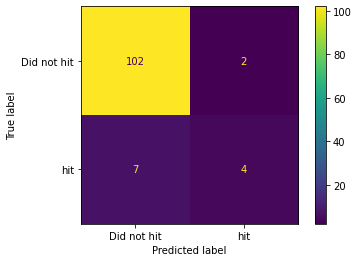

In [303]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [304]:
X.columns

Index(['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami', 'games_played_rate'],
      dtype='object')

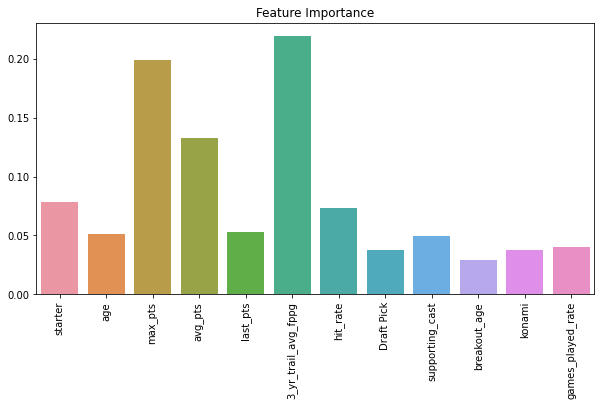

In [305]:
features = ['starter', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'hit_rate', 'Draft Pick', 'supporting_cast',
       'breakout_age', 'konami', 'games_played_rate']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [334]:
df_2022_id[df_2022_id['id']=='Trey Lance']

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
65,1,22.1,66.9198,66.9198,66.9198,11.1533,0.0,1.03,1.596338,NaN,0.166667,0.375,Trey Lance,2022


In [335]:
df_2022.loc[62,'3_yr_trail_avg_fppg'] = 19.6
df_2022.loc[65,'3_yr_trail_avg_fppg'] = 17.6

In [336]:
brady_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022)).set_index(df_2022_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2022.head(20)

,0,1
id,,
Josh Allen,0.110633,0.889367
Lamar Jackson,0.125197,0.874803
Deshaun Watson,0.133238,0.866762
Kyler Murray,0.158847,0.841153
Justin Herbert,0.170236,0.829764
Patrick Mahomes,0.224655,0.775345
Aaron Rodgers,0.298543,0.701457
Jalen Hurts,0.375722,0.624278
Russell Wilson,0.413420,0.586580


In [337]:
brady_scores_2022 = brady_scores_2022.reset_index()

In [353]:
brady_final_2022 = brady_scores_2022.merge(
    qb_2022_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2022

,id,0,1,Full Name,Team,starter
0,Josh Allen,0.110633,0.889367,Josh Allen,Buffalo Bills,1
1,Lamar Jackson,0.125197,0.874803,Lamar Jackson,Baltimore Ravens,1
2,Deshaun Watson,0.133238,0.866762,Deshaun Watson,Cleveland Browns,1
3,Kyler Murray,0.158847,0.841153,Kyler Murray,Arizona Cardinals,1
4,Justin Herbert,0.170236,0.829764,Justin Herbert,Los Angeles Chargers,1
...,...,...,...,...,...,...
88,Logan Woodside,0.993635,0.006365,Logan Woodside,Tennessee Titans,0
89,Nate Sudfeld,0.993635,0.006365,Nate Sudfeld,San Francisco 49ers,0
90,Tim Boyle,0.993635,0.006365,Tim Boyle,Detroit Lions,0
91,Nathan Peterman,0.993635,0.006365,Nathan Peterman,Chicago Bears,0


In [354]:
brady_final_2022.to_csv('hermes_brady_2022.csv')

winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df.csv')

## Backtest

In [355]:
df_2021_X = df_2021.drop(columns=['y'])

In [356]:
brady_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(df_2021_X)).set_index(df_2021_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2021 = brady_scores_2021.reset_index()

brady_final_2021 = brady_scores_2021.merge(
    qb_2021_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2021

brady_final_2021.to_csv('hermes_brady_2021.csv')
brady_final_2021.head(10)

,id,0,1,Full Name,Team,starter
0,Lamar Jackson,0.097843,0.902157,Lamar Jackson,Baltimore Ravens,1
1,Josh Allen,0.132782,0.867218,Josh Allen,Buffalo Bills,1
2,Justin Herbert,0.149144,0.850856,Justin Herbert,Los Angeles Chargers,1
3,Kyler Murray,0.183713,0.816287,Kyler Murray,Arizona Cardinals,1
4,Patrick Mahomes,0.187818,0.812182,Patrick Mahomes,Kansas City Chiefs,1
5,Aaron Rodgers,0.321498,0.678502,Aaron Rodgers,Green Bay Packers,1
6,Dak Prescott,0.325346,0.674654,Dak Prescott,Dallas Cowboys,1
7,Matthew Stafford,0.332571,0.667429,Matthew Stafford,Los Angeles Rams,1
8,Kirk Cousins,0.362175,0.637825,Kirk Cousins,Minnesota Vikings,1
9,Joe Burrow,0.385277,0.614723,Joe Burrow,Cincinnati Bengals,1


In [357]:
df_2020_X = df_2020.drop(columns=['y'])

brady_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(df_2020_X)).set_index(df_2020_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2020 = brady_scores_2020.reset_index()

brady_final_2020 = brady_scores_2020.merge(
    qb_2020_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2020

brady_final_2020.to_csv('hermes_brady_2020.csv')
brady_final_2020.head(10)

,id,0,1,Full Name,Team,starter
0,Deshaun Watson,0.100767,0.899233,Deshaun Watson,Houston Texans,1
1,Lamar Jackson,0.169175,0.830825,Lamar Jackson,Baltimore Ravens,1
2,Tom Brady,0.217104,0.782896,Tom Brady,Tampa Bay Buccaneers,1
3,Aaron Rodgers,0.225609,0.774391,Aaron Rodgers,Green Bay Packers,1
4,Patrick Mahomes,0.282072,0.717928,Patrick Mahomes,Kansas City Chiefs,1
5,Josh Allen,0.440541,0.559459,Josh Allen,Buffalo Bills,1
6,Russell Wilson,0.605468,0.394532,Russell Wilson,Seattle Seahawks,1
7,Drew Brees,0.651937,0.348062,Drew Brees,New Orleans Saints,1
8,Ryan Tannehill,0.730401,0.269599,Ryan Tannehill,Tennessee Titans,1
9,Kyler Murray,0.780333,0.219667,Kyler Murray,Arizona Cardinals,1


In [358]:
df_2019_X = df_2019.drop(columns=['y'])

brady_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(df_2019_X)).set_index(df_2019_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2019 = brady_scores_2019.reset_index()

brady_final_2019 = brady_scores_2019.merge(
    qb_2019_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2019

brady_final_2019.to_csv('hermes_brady_2019.csv')
brady_final_2019.head(10)

,id,0,1,Full Name,Team,starter
0,Deshaun Watson,0.092073,0.907927,Deshaun Watson,Houston Texans,1
1,Russell Wilson,0.350477,0.649523,Russell Wilson,Seattle Seahawks,1
2,Dak Prescott,0.395355,0.604645,Dak Prescott,Dallas Cowboys,1
3,Patrick Mahomes,0.580801,0.419199,Patrick Mahomes,Kansas City Chiefs,1
4,Aaron Rodgers,0.619371,0.380629,Aaron Rodgers,Green Bay Packers,1
5,Josh Allen,0.710938,0.289062,Josh Allen,Buffalo Bills,1
6,Baker Mayfield,0.721676,0.278324,Baker Mayfield,Cleveland Browns,1
7,Cam Newton,0.747739,0.252261,Cam Newton,Carolina Panthers,1
8,Jared Goff,0.757433,0.242567,Jared Goff,Los Angeles Rams,1
9,Drew Brees,0.769690,0.230310,Drew Brees,New Orleans Saints,1


In [359]:
df_2018_X = df_2018.drop(columns=['y'])

brady_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(df_2018_X)).set_index(df_2018_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2018 = brady_scores_2018.reset_index()

brady_final_2018 = brady_scores_2018.merge(
    qb_2018_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2018

brady_final_2018.to_csv('hermes_brady_2018.csv')
brady_final_2018.head(10)

,id,0,1,Full Name,Team,starter
0,Russell Wilson,0.179035,0.820965,Russell Wilson,Seattle Seahawks,1
1,Andrew Luck,0.182778,0.817222,Andrew Luck,Indianapolis Colts,1
2,Cam Newton,0.189427,0.810573,Cam Newton,Carolina Panthers,1
3,Deshaun Watson,0.324782,0.675218,Deshaun Watson,Houston Texans,1
4,Drew Brees,0.357812,0.642188,Drew Brees,New Orleans Saints,1
5,Aaron Rodgers,0.463860,0.536140,Aaron Rodgers,Green Bay Packers,1
6,Matt Ryan,0.495727,0.504273,Matt Ryan,Atlanta Falcons,1
7,Ben Roethlisberger,0.510363,0.489637,Ben Roethlisberger,Pittsburgh Steelers,1
8,Patrick Mahomes,0.591959,0.408041,Patrick Mahomes,Kansas City Chiefs,1
9,Jared Goff,0.699012,0.300988,Jared Goff,Los Angeles Rams,1


In [360]:
df_2017_X = df_2017.drop(columns=['y'])

brady_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(df_2017_X)).set_index(df_2017_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2017 = brady_scores_2017.reset_index()

brady_final_2017 = brady_scores_2017.merge(
    qb_2017_final[['Full Name','Team','starter']], left_on='id',right_on='Full Name',how='left')
brady_final_2017

brady_final_2017.to_csv('hermes_brady_2017.csv')
brady_final_2017.head(10)

,id,0,1,Full Name,Team,starter
0,Russell Wilson,0.134331,0.865669,Russell Wilson,Seattle Seahawks,1
1,Cam Newton,0.489592,0.510408,Cam Newton,Carolina Panthers,1
2,Aaron Rodgers,0.525968,0.474032,Aaron Rodgers,Green Bay Packers,1
3,Dak Prescott,0.656544,0.343456,Dak Prescott,Dallas Cowboys,1
4,Drew Brees,0.687734,0.312266,Drew Brees,New Orleans Saints,1
5,Ben Roethlisberger,0.729019,0.270981,Ben Roethlisberger,Pittsburgh Steelers,1
6,Tom Brady,0.778178,0.221822,Tom Brady,New England Patriots,1
7,Matt Ryan,0.800606,0.199394,Matt Ryan,Atlanta Falcons,1
8,Marcus Mariota,0.903385,0.096615,Marcus Mariota,Tennessee Titans,1
9,Kirk Cousins,0.921787,0.078213,Kirk Cousins,Washington Commanders,1


### 2021

In [315]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,0.125000,0.919643
1,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN
2,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN
3,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,0.102564,0.857143
4,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,0.256944,0.875000
81,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,0.415278,0.958333
82,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000
83,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN


In [316]:
df_2021_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,0.125000,0.919643,Aaron Rodgers,2021
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love,2021
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert,2021
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,0.102564,0.857143,Andy Dalton,2021
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,0.256944,0.875000,Ryan Tannehill,2021
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,0.415278,0.958333,Lamar Jackson,2021
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley,2021
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White,2021


In [317]:
id_2021 = qb_final_df[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
1,Aaron Rodgers,21.0813
5,Andy Dalton,11.6500
7,Baker Mayfield,13.8500
9,Ben Roethlisberger,14.2562
10,Blaine Gabbert,0.3300
...,...,...
167,Trey Lance,11.1533
168,Tua Tagovailoa,14.6862
170,Tyler Huntley,12.3771
171,Tyrod Taylor,14.4567


In [318]:
brady_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(df_2021_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2021

,0,1
id,,
Lamar Jackson,0.097843,0.902157
Josh Allen,0.132782,0.867218
Justin Herbert,0.149144,0.850856
Kyler Murray,0.183713,0.816287
Patrick Mahomes,0.187818,0.812182
...,...,...
Chris Streveler,0.993635,0.006365
David Blough,0.993635,0.006365
Davis Webb,0.993635,0.006365


In [320]:
brady_scores_2021_check = brady_scores_2021.reset_index()
brady_scores_2021_check.head(20)

,id,0,1
0,Lamar Jackson,0.097843,0.902157
1,Josh Allen,0.132782,0.867218
2,Justin Herbert,0.149144,0.850856
3,Kyler Murray,0.183713,0.816287
4,Patrick Mahomes,0.187818,0.812182
5,Aaron Rodgers,0.321498,0.678502
6,Dak Prescott,0.325346,0.674654
7,Matthew Stafford,0.332571,0.667429
8,Kirk Cousins,0.362175,0.637825
9,Joe Burrow,0.385277,0.614723


In [122]:
df_2021['id'] = df_2021_id['id']
df_2021

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,1,1,37.5,388.2592,307.094171,388.2592,20.288733,0.714286,1.24,1.662298,19.8,1.857143,0.919643,Aaron Rodgers
1,0,0,22.6,NaN,NaN,NaN,NaN,NaN,1.26,1.662298,19.8,NaN,NaN,Jordan Love
2,0,0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,1.662298,21.1,NaN,NaN,Kurt Benkert
3,0,1,33.6,268.8000,218.014243,144.8997,15.490900,0.000000,2.03,1.754124,20.9,2.142857,0.857143,Andy Dalton
4,0,0,22.2,NaN,NaN,NaN,NaN,NaN,1.11,1.754124,20.5,NaN,NaN,Justin Fields
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,32.9,351.3600,247.743333,351.3600,18.153333,0.166667,1.08,1.524542,22.1,2.333333,0.875000,Ryan Tannehill
81,0,1,24.4,423.0000,308.259833,341.7795,20.328433,0.666667,1.32,1.224198,18.7,6.333333,0.958333,Lamar Jackson
82,0,0,23.3,2.9000,2.900000,2.9000,1.450000,0.000000,NaN,1.224198,21.6,0.000000,0.125000,Tyler Huntley
83,0,0,26.2,NaN,NaN,NaN,NaN,NaN,5.34,0.989744,21.5,NaN,NaN,Mike White


In [123]:
brady_scores_2021_check2 = brady_scores_2021_check.merge(df_2021, on='id',how='inner')
brady_scores_2021_check2.to_csv('brady_scores_2021_check.csv')

### 2020

In [124]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125
1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667
2,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250
3,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500
4,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500
...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500
78,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN
79,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500
80,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583


In [125]:
df_2020_id

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id,year
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron,2020
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson,2020
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers,2020
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle,2020
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray,2020
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker,2020
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater,2020
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick,2020


In [126]:
brady_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(df_2020_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2020

,0,1
id,,
Deshaun Watson,0.118928,0.881072
Aaron Rodgers,0.175499,0.824501
Lamar Jackson,0.193739,0.806261
Tom Brady,0.231233,0.768767
Patrick Mahomes,0.324724,0.675276
...,...,...
Geno Smith,0.994326,0.005674
P.J. Walker,0.994326,0.005674
Chris Streveler,0.994326,0.005674


In [127]:
brady_scores_2020_check = brady_scores_2020.reset_index()
brady_scores_2020_check

,id,0,1
0,Deshaun Watson,0.118928,0.881072
1,Aaron Rodgers,0.175499,0.824501
2,Lamar Jackson,0.193739,0.806261
3,Tom Brady,0.231233,0.768767
4,Patrick Mahomes,0.324724,0.675276
...,...,...,...
77,Geno Smith,0.994326,0.005674
78,P.J. Walker,0.994326,0.005674
79,Chris Streveler,0.994326,0.005674
80,Easton Stick,0.994326,0.005674


In [128]:
df_2020['id'] = df_2020_id['id']
df_2020

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,0,0,29.7,57.4,19.500000,17.8,3.433333,0.000000,5.24,1.037354,21.0,0.250000,0.203125,A.J. McCarron
1,1,1,24.7,340.8,281.233333,330.0,22.666667,0.666667,1.12,1.037354,20.0,4.666667,0.791667,Deshaun Watson
2,1,1,36.5,382.4,293.566667,276.8,18.666667,0.666667,1.24,1.473486,19.8,1.666667,0.906250,Aaron Rodgers
3,0,0,25.7,0.0,0.000000,0.0,0.000000,0.000000,NaN,1.473486,NaN,0.000000,0.187500,Tim Boyle
4,0,0,36.1,300.0,234.220000,NaN,17.150000,0.000000,1.01,0.865133,19.3,2.000000,0.887500,Alex Smith
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,0,28.4,-2.0,-2.000000,NaN,-2.000000,0.000000,NaN,1.447192,18.7,0.000000,0.062500,Tyler Bray
78,0,0,25.3,NaN,NaN,NaN,NaN,NaN,NaN,1.616799,18.5,NaN,NaN,P.J. Walker
79,0,1,27.6,208.0,99.000000,92.7,3.700000,0.000000,1.32,1.616799,18.8,0.800000,0.537500,Teddy Bridgewater
80,0,1,37.5,300.8,191.133333,252.0,17.200000,0.166667,7.36,0.364208,20.8,1.666667,0.739583,Ryan Fitzpatrick


In [129]:
brady_scores_2020_check2 = brady_scores_2020_check.merge(df_2020, on='id',how='inner')
brady_scores_2020_check2.to_csv('brady_scores_2020_check.csv')

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=30.0, scale_pos_weight=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=20.0, scale_pos_weight=1; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   0.3s
[CV] END gamma=0, learning_rate=0.0

### 2019

In [137]:
X_2019 = df_2019.drop(columns=['y'])
X_2019

,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate
0,0,28.7,57.4,20.066667,0.2,0.700000,0.0,5.24,1.128671,21.0,0.0,0.229167
1,1,23.7,340.8,256.850000,340.8,23.000000,0.5,1.12,1.128671,20.0,3.5,0.718750
2,1,35.5,382.4,296.920000,308.8,20.866667,0.8,1.24,1.073120,19.8,1.8,0.887500
3,0,24.7,NaN,NaN,NaN,NaN,NaN,NaN,1.073120,NaN,NaN,NaN
4,0,31.6,8.0,8.000000,NaN,NaN,0.0,NaN,1.011398,NaN,0.0,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...
65,1,34.1,356.8,298.240000,356.8,19.733333,0.4,1.03,1.238662,20.3,0.6,1.000000
66,0,38.0,30.6,7.275000,0.0,0.050000,0.0,3.27,1.238662,21.2,0.0,0.140625
67,1,37.5,292.8,284.480000,286.4,17.633333,0.0,1.04,1.633534,18.7,0.0,1.000000
68,0,29.8,274.4,163.440000,43.6,14.733333,0.0,6.15,1.633534,20.1,3.0,0.612500


In [138]:
brady_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(X_2019)).set_index(df_2019_id['id']).sort_values(
    1, axis=0, ascending=False)
brady_scores_2019

,0,1
id,,
Deshaun Watson,0.095966,0.904034
Russell Wilson,0.325989,0.674011
Dak Prescott,0.370597,0.629403
Aaron Rodgers,0.636042,0.363958
Baker Mayfield,0.665868,0.334132
...,...,...
Brett Hundley,0.994326,0.005674
Brandon Allen,0.994326,0.005674
Mason Rudolph,0.994326,0.005674


In [139]:
brady_scores_2019_check = brady_scores_2019.reset_index()
brady_scores_2019_check

,id,0,1
0,Deshaun Watson,0.095966,0.904034
1,Russell Wilson,0.325989,0.674011
2,Dak Prescott,0.370597,0.629403
3,Aaron Rodgers,0.636042,0.363958
4,Baker Mayfield,0.665868,0.334132
...,...,...,...
65,Brett Hundley,0.994326,0.005674
66,Brandon Allen,0.994326,0.005674
67,Mason Rudolph,0.994326,0.005674
68,Ryan Finley,0.994326,0.005674


In [140]:
df_2019['id'] = df_2019_id['id']
df_2019

,y,starter,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,supporting_cast,breakout_age,konami,games_played_rate,id
0,0,0,28.7,57.4,20.066667,0.2,0.700000,0.0,5.24,1.128671,21.0,0.0,0.229167,A.J. McCarron
1,1,1,23.7,340.8,256.850000,340.8,23.000000,0.5,1.12,1.128671,20.0,3.5,0.718750,Deshaun Watson
2,0,1,35.5,382.4,296.920000,308.8,20.866667,0.8,1.24,1.073120,19.8,1.8,0.887500,Aaron Rodgers
3,0,0,24.7,NaN,NaN,NaN,NaN,NaN,NaN,1.073120,NaN,NaN,NaN,Tim Boyle
4,0,0,31.6,8.0,8.000000,NaN,NaN,0.0,NaN,1.011398,NaN,0.0,0.062500,Alex Tanney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,1,34.1,356.8,298.240000,356.8,19.733333,0.4,1.03,1.238662,20.3,0.6,1.000000,Matt Ryan
66,0,0,38.0,30.6,7.275000,0.0,0.050000,0.0,3.27,1.238662,21.2,0.0,0.140625,Matt Schaub
67,0,1,37.5,292.8,284.480000,286.4,17.633333,0.0,1.04,1.633534,18.7,0.0,1.000000,Philip Rivers
68,0,0,29.8,274.4,163.440000,43.6,14.733333,0.0,6.15,1.633534,20.1,3.0,0.612500,Tyrod Taylor


In [141]:
brady_scores_2019_check2 = brady_scores_2019_check.merge(df_2019, on='id',how='inner')
brady_scores_2019_check2.to_csv('brady_scores_2019_check.csv')

### 2018

In [142]:
X_2018 = df_2018.drop(columns=['y'])

brady_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(X_2018)).set_index(df_2018_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2018_check = brady_scores_2018.reset_index()
brady_scores_2018_check

df_2018['id'] = df_2018_id['id']

brady_scores_2018_check2 = brady_scores_2018_check.merge(df_2018, on='id',how='inner')
brady_scores_2018_check2.to_csv('brady_scores_2018_check.csv')

In [143]:
brady_scores_2018_check

,id,0,1
0,Russell Wilson,0.126217,0.873783
1,Andrew Luck,0.155311,0.844689
2,Cam Newton,0.253047,0.746953
3,Deshaun Watson,0.319094,0.680906
4,Aaron Rodgers,0.394233,0.605767
...,...,...,...
67,Jeff Driskel,0.994326,0.005674
68,Matt Barkley,0.994326,0.005674
69,Mark Sanchez,0.994326,0.005674
70,Colt McCoy,0.994326,0.005674


### 2017

In [144]:
X_2017 = df_2017.drop(columns=['y'])

brady_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(X_2017)).set_index(df_2017_id['id']).sort_values(
    1, axis=0, ascending=False)

brady_scores_2017_check = brady_scores_2017.reset_index()
brady_scores_2017_check

df_2017['id'] = df_2017_id['id']

brady_scores_2017_check2 = brady_scores_2017_check.merge(df_2017, on='id',how='inner')
brady_scores_2017_check2.to_csv('brady_scores_2017_check.csv')

In [145]:
brady_scores_2017_check

,id,0,1
0,Russell Wilson,0.159666,0.840334
1,Cam Newton,0.471003,0.528997
2,Aaron Rodgers,0.477193,0.522807
3,Dak Prescott,0.647845,0.352155
4,Tom Brady,0.736004,0.263996
...,...,...,...
68,Tyler Bray,0.994326,0.005674
69,Taylor Heinicke,0.994326,0.005674
70,Joe Callahan,0.994326,0.005674
71,Nate Sudfeld,0.994326,0.005674
